<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_22nov2023.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


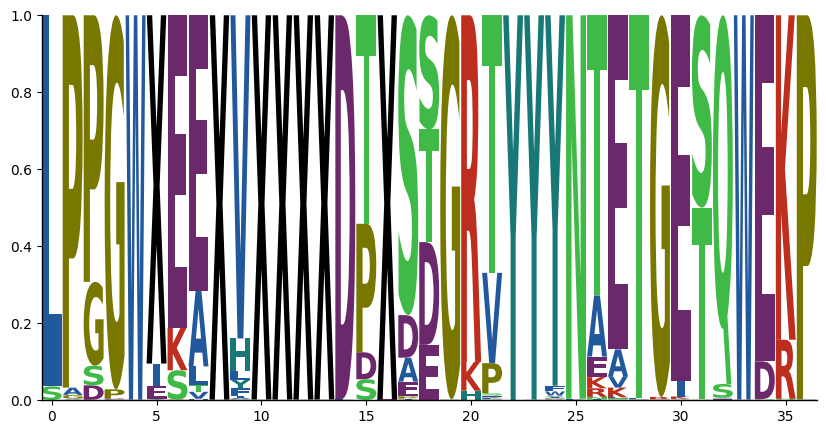

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15])#[-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1500, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=16.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  20


Epoch 1/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1500:  50%|█████     | 10/20 [00:01<00:01,  5.01samples/s]

Epoch 1/1500:  50%|█████     | 10/20 [00:01<00:01,  5.01samples/s, loss=1109.4346923828125]

Epoch 1/1500: 100%|██████████| 20/20 [00:04<00:00,  4.47samples/s, loss=1109.4346923828125]

Epoch 1/1500: 100%|██████████| 20/20 [00:04<00:00,  4.47samples/s, loss=1118.246826171875] 

Epoch 1/1500: 100%|██████████| 20/20 [00:04<00:00,  4.43samples/s, loss=1118.246826171875]

Epoch 2/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 2/1500:  50%|█████     | 10/20 [00:01<00:01,  5.24samples/s]

Epoch 2/1500:  50%|█████     | 10/20 [00:01<00:01,  5.24samples/s, loss=1109.212890625]

Epoch 2/1500: 100%|██████████| 20/20 [00:04<00:00,  4.07samples/s, loss=1109.212890625]

Epoch 2/1500: 100%|██████████| 20/20 [00:04<00:00,  4.07samples/s, loss=1103.3404541015625]

Epoch 2/1500: 100%|██████████| 20/20 [00:04<00:00,  4.10samples/s, loss=1103.3404541015625]

Epoch 3/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 3/1500:  50%|█████     | 10/20 [00:02<00:02,  4.28samples/s]

Epoch 3/1500:  50%|█████     | 10/20 [00:02<00:02,  4.28samples/s, loss=1092.25244140625]

Epoch 3/1500: 100%|██████████| 20/20 [00:04<00:00,  4.09samples/s, loss=1092.25244140625]

Epoch 3/1500: 100%|██████████| 20/20 [00:04<00:00,  4.09samples/s, loss=1080.0526123046875]

Epoch 3/1500: 100%|██████████| 20/20 [00:05<00:00,  3.99samples/s, loss=1080.0526123046875]

Epoch 4/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 4/1500:  50%|█████     | 10/20 [00:01<00:01,  5.77samples/s]

Epoch 4/1500:  50%|█████     | 10/20 [00:01<00:01,  5.77samples/s, loss=1061.0970458984375]

Epoch 4/1500: 100%|██████████| 20/20 [00:04<00:00,  4.50samples/s, loss=1061.0970458984375]

Epoch 4/1500: 100%|██████████| 20/20 [00:04<00:00,  4.50samples/s, loss=1073.0721435546875]

Epoch 4/1500: 100%|██████████| 20/20 [00:04<00:00,  4.53samples/s, loss=1073.0721435546875]

Epoch 5/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 5/1500:  50%|█████     | 10/20 [00:01<00:01,  5.85samples/s]

Epoch 5/1500:  50%|█████     | 10/20 [00:01<00:01,  5.85samples/s, loss=1062.857421875]

Epoch 5/1500: 100%|██████████| 20/20 [00:04<00:00,  4.59samples/s, loss=1062.857421875]

Epoch 5/1500: 100%|██████████| 20/20 [00:04<00:00,  4.59samples/s, loss=1078.4681396484375]

Epoch 5/1500: 100%|██████████| 20/20 [00:04<00:00,  4.62samples/s, loss=1078.4681396484375]

Epoch 6/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 6/1500:  50%|█████     | 10/20 [00:01<00:01,  5.65samples/s]

Epoch 6/1500:  50%|█████     | 10/20 [00:01<00:01,  5.65samples/s, loss=1065.986083984375]

Epoch 6/1500: 100%|██████████| 20/20 [00:04<00:00,  4.54samples/s, loss=1065.986083984375]

Epoch 6/1500: 100%|██████████| 20/20 [00:04<00:00,  4.54samples/s, loss=1066.92431640625] 

Epoch 6/1500: 100%|██████████| 20/20 [00:04<00:00,  4.54samples/s, loss=1066.92431640625]

Epoch 7/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 7/1500:  50%|█████     | 10/20 [00:02<00:02,  4.82samples/s]

Epoch 7/1500:  50%|█████     | 10/20 [00:02<00:02,  4.82samples/s, loss=1057.77587890625]

Epoch 7/1500: 100%|██████████| 20/20 [00:04<00:00,  4.00samples/s, loss=1057.77587890625]

Epoch 7/1500: 100%|██████████| 20/20 [00:04<00:00,  4.00samples/s, loss=1074.548583984375]

Epoch 7/1500: 100%|██████████| 20/20 [00:05<00:00,  3.99samples/s, loss=1074.548583984375]

Epoch 8/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 8/1500:  50%|█████     | 10/20 [00:02<00:02,  4.15samples/s]

Epoch 8/1500:  50%|█████     | 10/20 [00:02<00:02,  4.15samples/s, loss=1088.75537109375]

Epoch 8/1500: 100%|██████████| 20/20 [00:04<00:00,  4.74samples/s, loss=1088.75537109375]

Epoch 8/1500: 100%|██████████| 20/20 [00:04<00:00,  4.74samples/s, loss=1058.37158203125]

Epoch 8/1500: 100%|██████████| 20/20 [00:04<00:00,  4.50samples/s, loss=1058.37158203125]

Epoch 9/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 9/1500:  50%|█████     | 10/20 [00:02<00:02,  3.66samples/s]

Epoch 9/1500:  50%|█████     | 10/20 [00:02<00:02,  3.66samples/s, loss=1071.4901123046875]

Epoch 9/1500: 100%|██████████| 20/20 [00:04<00:00,  5.10samples/s, loss=1071.4901123046875]

Epoch 9/1500: 100%|██████████| 20/20 [00:04<00:00,  5.10samples/s, loss=1068.4000244140625]

Epoch 9/1500: 100%|██████████| 20/20 [00:04<00:00,  4.68samples/s, loss=1068.4000244140625]

Epoch 10/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 10/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 10/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=1057.272216796875]

Epoch 10/1500: 100%|██████████| 20/20 [00:04<00:00,  4.00samples/s, loss=1057.272216796875]

Epoch 10/1500: 100%|██████████| 20/20 [00:04<00:00,  4.00samples/s, loss=1061.8306884765625]

Epoch 10/1500: 100%|██████████| 20/20 [00:04<00:00,  4.24samples/s, loss=1061.8306884765625]

Epoch 11/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 11/1500:  50%|█████     | 10/20 [00:01<00:01,  7.24samples/s]

Epoch 11/1500:  50%|█████     | 10/20 [00:01<00:01,  7.24samples/s, loss=1062.086181640625]

Epoch 11/1500: 100%|██████████| 20/20 [00:03<00:00,  5.26samples/s, loss=1062.086181640625]

Epoch 11/1500: 100%|██████████| 20/20 [00:03<00:00,  5.26samples/s, loss=1073.4739990234375]

Epoch 11/1500: 100%|██████████| 20/20 [00:03<00:00,  5.31samples/s, loss=1073.4739990234375]

Epoch 12/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 12/1500:  50%|█████     | 10/20 [00:01<00:01,  7.46samples/s]

Epoch 12/1500:  50%|█████     | 10/20 [00:01<00:01,  7.46samples/s, loss=1066.5821533203125]

Epoch 12/1500: 100%|██████████| 20/20 [00:02<00:00,  7.16samples/s, loss=1066.5821533203125]

Epoch 12/1500: 100%|██████████| 20/20 [00:02<00:00,  7.16samples/s, loss=1068.9498291015625]

Epoch 12/1500: 100%|██████████| 20/20 [00:02<00:00,  6.89samples/s, loss=1068.9498291015625]

Epoch 13/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 13/1500:  50%|█████     | 10/20 [00:01<00:01,  7.67samples/s]

Epoch 13/1500:  50%|█████     | 10/20 [00:01<00:01,  7.67samples/s, loss=1071.6201171875]

Epoch 13/1500: 100%|██████████| 20/20 [00:02<00:00,  6.71samples/s, loss=1071.6201171875]

Epoch 13/1500: 100%|██████████| 20/20 [00:02<00:00,  6.71samples/s, loss=1072.3985595703125]

Epoch 13/1500: 100%|██████████| 20/20 [00:03<00:00,  6.57samples/s, loss=1072.3985595703125]

Epoch 14/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 14/1500:  50%|█████     | 10/20 [00:01<00:01,  7.45samples/s]

Epoch 14/1500:  50%|█████     | 10/20 [00:01<00:01,  7.45samples/s, loss=1072.91455078125]

Epoch 14/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=1072.91455078125]

Epoch 14/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=1085.852783203125]

Epoch 14/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1085.852783203125]

Epoch 15/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 15/1500:  50%|█████     | 10/20 [00:01<00:01,  7.36samples/s]

Epoch 15/1500:  50%|█████     | 10/20 [00:01<00:01,  7.36samples/s, loss=1073.0618896484375]

Epoch 15/1500: 100%|██████████| 20/20 [00:02<00:00,  6.78samples/s, loss=1073.0618896484375]

Epoch 15/1500: 100%|██████████| 20/20 [00:02<00:00,  6.78samples/s, loss=1084.7099609375]   

Epoch 15/1500: 100%|██████████| 20/20 [00:03<00:00,  6.57samples/s, loss=1084.7099609375]

Epoch 16/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 16/1500:  50%|█████     | 10/20 [00:01<00:01,  7.32samples/s]

Epoch 16/1500:  50%|█████     | 10/20 [00:01<00:01,  7.32samples/s, loss=1074.8704833984375]

Epoch 16/1500: 100%|██████████| 20/20 [00:02<00:00,  7.07samples/s, loss=1074.8704833984375]

Epoch 16/1500: 100%|██████████| 20/20 [00:02<00:00,  7.07samples/s, loss=1079.6998291015625]

Epoch 16/1500: 100%|██████████| 20/20 [00:02<00:00,  6.80samples/s, loss=1079.6998291015625]

Epoch 17/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 17/1500:  50%|█████     | 10/20 [00:01<00:01,  6.94samples/s]

Epoch 17/1500:  50%|█████     | 10/20 [00:01<00:01,  6.94samples/s, loss=1074.7559814453125]

Epoch 17/1500: 100%|██████████| 20/20 [00:02<00:00,  6.70samples/s, loss=1074.7559814453125]

Epoch 17/1500: 100%|██████████| 20/20 [00:02<00:00,  6.70samples/s, loss=1090.4002685546875]

Epoch 17/1500: 100%|██████████| 20/20 [00:03<00:00,  6.47samples/s, loss=1090.4002685546875]

Epoch 18/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 18/1500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s]

Epoch 18/1500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s, loss=1077.540771484375]

Epoch 18/1500: 100%|██████████| 20/20 [00:02<00:00,  7.12samples/s, loss=1077.540771484375]

Epoch 18/1500: 100%|██████████| 20/20 [00:02<00:00,  7.12samples/s, loss=1085.982177734375]

Epoch 18/1500: 100%|██████████| 20/20 [00:02<00:00,  6.85samples/s, loss=1085.982177734375]

Epoch 19/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 19/1500:  50%|█████     | 10/20 [00:01<00:01,  6.59samples/s]

Epoch 19/1500:  50%|█████     | 10/20 [00:01<00:01,  6.59samples/s, loss=1077.777099609375]

Epoch 19/1500: 100%|██████████| 20/20 [00:03<00:00,  6.67samples/s, loss=1077.777099609375]

Epoch 19/1500: 100%|██████████| 20/20 [00:03<00:00,  6.67samples/s, loss=1082.9744873046875]

Epoch 19/1500: 100%|██████████| 20/20 [00:03<00:00,  6.40samples/s, loss=1082.9744873046875]

Epoch 20/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 20/1500:  50%|█████     | 10/20 [00:01<00:01,  7.63samples/s]

Epoch 20/1500:  50%|█████     | 10/20 [00:01<00:01,  7.63samples/s, loss=1071.989013671875]

Epoch 20/1500: 100%|██████████| 20/20 [00:02<00:00,  7.24samples/s, loss=1071.989013671875]

Epoch 20/1500: 100%|██████████| 20/20 [00:02<00:00,  7.24samples/s, loss=1070.8162841796875]

Epoch 20/1500: 100%|██████████| 20/20 [00:02<00:00,  6.96samples/s, loss=1070.8162841796875]

Epoch 21/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 21/1500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s]

Epoch 21/1500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s, loss=1067.862548828125]

Epoch 21/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1067.862548828125]

Epoch 21/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1058.0535888671875]

Epoch 21/1500: 100%|██████████| 20/20 [00:03<00:00,  6.59samples/s, loss=1058.0535888671875]

Epoch 22/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 22/1500:  50%|█████     | 10/20 [00:01<00:01,  7.63samples/s]

Epoch 22/1500:  50%|█████     | 10/20 [00:01<00:01,  7.63samples/s, loss=1065.5787353515625]

Epoch 22/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1065.5787353515625]

Epoch 22/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1074.2303466796875]

Epoch 22/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1074.2303466796875]

Epoch 23/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 23/1500:  50%|█████     | 10/20 [00:01<00:01,  6.61samples/s]

Epoch 23/1500:  50%|█████     | 10/20 [00:01<00:01,  6.61samples/s, loss=1067.9193115234375]

Epoch 23/1500: 100%|██████████| 20/20 [00:02<00:00,  6.74samples/s, loss=1067.9193115234375]

Epoch 23/1500: 100%|██████████| 20/20 [00:02<00:00,  6.74samples/s, loss=1075.352783203125] 

Epoch 23/1500: 100%|██████████| 20/20 [00:03<00:00,  6.46samples/s, loss=1075.352783203125]

Epoch 24/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 24/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s]

Epoch 24/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s, loss=1074.8115234375]

Epoch 24/1500: 100%|██████████| 20/20 [00:02<00:00,  7.09samples/s, loss=1074.8115234375]

Epoch 24/1500: 100%|██████████| 20/20 [00:02<00:00,  7.09samples/s, loss=1091.1871337890625]

Epoch 24/1500: 100%|██████████| 20/20 [00:02<00:00,  6.84samples/s, loss=1091.1871337890625]

Epoch 25/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 25/1500:  50%|█████     | 10/20 [00:01<00:01,  6.90samples/s]

Epoch 25/1500:  50%|█████     | 10/20 [00:01<00:01,  6.90samples/s, loss=1072.1446533203125]

Epoch 25/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1072.1446533203125]

Epoch 25/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1089.2857666015625]

Epoch 25/1500: 100%|██████████| 20/20 [00:03<00:00,  6.60samples/s, loss=1089.2857666015625]

Epoch 26/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 26/1500:  50%|█████     | 10/20 [00:01<00:01,  7.49samples/s]

Epoch 26/1500:  50%|█████     | 10/20 [00:01<00:01,  7.49samples/s, loss=1082.0001220703125]

Epoch 26/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1082.0001220703125]

Epoch 26/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1079.9737548828125]

Epoch 26/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1079.9737548828125]

Epoch 27/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 27/1500:  50%|█████     | 10/20 [00:01<00:01,  6.77samples/s]

Epoch 27/1500:  50%|█████     | 10/20 [00:01<00:01,  6.77samples/s, loss=1078.7244873046875]

Epoch 27/1500: 100%|██████████| 20/20 [00:02<00:00,  6.69samples/s, loss=1078.7244873046875]

Epoch 27/1500: 100%|██████████| 20/20 [00:02<00:00,  6.69samples/s, loss=1098.573486328125] 

Epoch 27/1500: 100%|██████████| 20/20 [00:03<00:00,  6.44samples/s, loss=1098.573486328125]

Epoch 28/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 28/1500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s]

Epoch 28/1500:  50%|█████     | 10/20 [00:01<00:01,  7.40samples/s, loss=1095.63623046875]

Epoch 28/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1095.63623046875]

Epoch 28/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1097.00634765625]

Epoch 28/1500: 100%|██████████| 20/20 [00:03<00:00,  6.61samples/s, loss=1097.00634765625]

Epoch 29/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 29/1500:  50%|█████     | 10/20 [00:01<00:01,  7.52samples/s]

Epoch 29/1500:  50%|█████     | 10/20 [00:01<00:01,  7.52samples/s, loss=1090.844482421875]

Epoch 29/1500: 100%|██████████| 20/20 [00:02<00:00,  7.08samples/s, loss=1090.844482421875]

Epoch 29/1500: 100%|██████████| 20/20 [00:02<00:00,  7.08samples/s, loss=1078.4732666015625]

Epoch 29/1500: 100%|██████████| 20/20 [00:02<00:00,  6.85samples/s, loss=1078.4732666015625]

Epoch 30/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 30/1500:  50%|█████     | 10/20 [00:01<00:01,  7.57samples/s]

Epoch 30/1500:  50%|█████     | 10/20 [00:01<00:01,  7.57samples/s, loss=1077.2425537109375]

Epoch 30/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1077.2425537109375]

Epoch 30/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1072.4248046875]   

Epoch 30/1500: 100%|██████████| 20/20 [00:03<00:00,  6.64samples/s, loss=1072.4248046875]

Epoch 31/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 31/1500:  50%|█████     | 10/20 [00:01<00:01,  7.35samples/s]

Epoch 31/1500:  50%|█████     | 10/20 [00:01<00:01,  7.35samples/s, loss=1072.0450439453125]

Epoch 31/1500: 100%|██████████| 20/20 [00:02<00:00,  6.90samples/s, loss=1072.0450439453125]

Epoch 31/1500: 100%|██████████| 20/20 [00:02<00:00,  6.90samples/s, loss=1075.0555419921875]

Epoch 31/1500: 100%|██████████| 20/20 [00:02<00:00,  6.67samples/s, loss=1075.0555419921875]

Epoch 32/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 32/1500:  50%|█████     | 10/20 [00:01<00:01,  7.50samples/s]

Epoch 32/1500:  50%|█████     | 10/20 [00:01<00:01,  7.50samples/s, loss=1066.60205078125]

Epoch 32/1500: 100%|██████████| 20/20 [00:03<00:00,  6.45samples/s, loss=1066.60205078125]

Epoch 32/1500: 100%|██████████| 20/20 [00:03<00:00,  6.45samples/s, loss=1079.059814453125]

Epoch 32/1500: 100%|██████████| 20/20 [00:03<00:00,  6.34samples/s, loss=1079.059814453125]

Epoch 33/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 33/1500:  50%|█████     | 10/20 [00:01<00:01,  7.36samples/s]

Epoch 33/1500:  50%|█████     | 10/20 [00:01<00:01,  7.36samples/s, loss=1074.8826904296875]

Epoch 33/1500: 100%|██████████| 20/20 [00:02<00:00,  7.05samples/s, loss=1074.8826904296875]

Epoch 33/1500: 100%|██████████| 20/20 [00:02<00:00,  7.05samples/s, loss=1077.6385498046875]

Epoch 33/1500: 100%|██████████| 20/20 [00:02<00:00,  6.81samples/s, loss=1077.6385498046875]

Epoch 34/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 34/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s]

Epoch 34/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s, loss=1069.0084228515625]

Epoch 34/1500: 100%|██████████| 20/20 [00:02<00:00,  6.81samples/s, loss=1069.0084228515625]

Epoch 34/1500: 100%|██████████| 20/20 [00:02<00:00,  6.81samples/s, loss=1070.492919921875] 

Epoch 34/1500: 100%|██████████| 20/20 [00:03<00:00,  6.62samples/s, loss=1070.492919921875]

Epoch 35/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 35/1500:  50%|█████     | 10/20 [00:01<00:01,  7.50samples/s]

Epoch 35/1500:  50%|█████     | 10/20 [00:01<00:01,  7.50samples/s, loss=1076.3560791015625]

Epoch 35/1500: 100%|██████████| 20/20 [00:02<00:00,  7.09samples/s, loss=1076.3560791015625]

Epoch 35/1500: 100%|██████████| 20/20 [00:02<00:00,  7.09samples/s, loss=1063.5958251953125]

Epoch 35/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1063.5958251953125]

Epoch 36/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 36/1500:  50%|█████     | 10/20 [00:01<00:01,  7.53samples/s]

Epoch 36/1500:  50%|█████     | 10/20 [00:01<00:01,  7.53samples/s, loss=1072.3946533203125]

Epoch 36/1500: 100%|██████████| 20/20 [00:02<00:00,  6.81samples/s, loss=1072.3946533203125]

Epoch 36/1500: 100%|██████████| 20/20 [00:02<00:00,  6.81samples/s, loss=1074.7001953125]   

Epoch 36/1500: 100%|██████████| 20/20 [00:03<00:00,  6.62samples/s, loss=1074.7001953125]

Epoch 37/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 37/1500:  50%|█████     | 10/20 [00:01<00:01,  6.81samples/s]

Epoch 37/1500:  50%|█████     | 10/20 [00:01<00:01,  6.81samples/s, loss=1072.3062744140625]

Epoch 37/1500: 100%|██████████| 20/20 [00:02<00:00,  6.80samples/s, loss=1072.3062744140625]

Epoch 37/1500: 100%|██████████| 20/20 [00:02<00:00,  6.80samples/s, loss=1074.8128662109375]

Epoch 37/1500: 100%|██████████| 20/20 [00:03<00:00,  6.50samples/s, loss=1074.8128662109375]

Epoch 38/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 38/1500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s]

Epoch 38/1500:  50%|█████     | 10/20 [00:01<00:01,  6.65samples/s, loss=1069.04541015625]

Epoch 38/1500: 100%|██████████| 20/20 [00:02<00:00,  6.82samples/s, loss=1069.04541015625]

Epoch 38/1500: 100%|██████████| 20/20 [00:02<00:00,  6.82samples/s, loss=1071.545166015625]

Epoch 38/1500: 100%|██████████| 20/20 [00:03<00:00,  6.54samples/s, loss=1071.545166015625]

Epoch 39/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 39/1500:  50%|█████     | 10/20 [00:01<00:01,  7.39samples/s]

Epoch 39/1500:  50%|█████     | 10/20 [00:01<00:01,  7.39samples/s, loss=1076.8046875]

Epoch 39/1500: 100%|██████████| 20/20 [00:02<00:00,  7.03samples/s, loss=1076.8046875]

Epoch 39/1500: 100%|██████████| 20/20 [00:02<00:00,  7.03samples/s, loss=1082.91748046875]

Epoch 39/1500: 100%|██████████| 20/20 [00:02<00:00,  6.75samples/s, loss=1082.91748046875]

Epoch 40/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 40/1500:  50%|█████     | 10/20 [00:01<00:01,  6.98samples/s]

Epoch 40/1500:  50%|█████     | 10/20 [00:01<00:01,  6.98samples/s, loss=1070.717529296875]

Epoch 40/1500: 100%|██████████| 20/20 [00:02<00:00,  6.95samples/s, loss=1070.717529296875]

Epoch 40/1500: 100%|██████████| 20/20 [00:02<00:00,  6.95samples/s, loss=1081.145751953125]

Epoch 40/1500: 100%|██████████| 20/20 [00:03<00:00,  6.66samples/s, loss=1081.145751953125]

Epoch 41/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 41/1500:  50%|█████     | 10/20 [00:01<00:01,  7.54samples/s]

Epoch 41/1500:  50%|█████     | 10/20 [00:01<00:01,  7.54samples/s, loss=1069.657470703125]

Epoch 41/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1069.657470703125]

Epoch 41/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=1066.27685546875] 

Epoch 41/1500: 100%|██████████| 20/20 [00:02<00:00,  6.86samples/s, loss=1066.27685546875]

Epoch 42/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 42/1500:  50%|█████     | 10/20 [00:01<00:01,  6.97samples/s]

Epoch 42/1500:  50%|█████     | 10/20 [00:01<00:01,  6.97samples/s, loss=1061.69580078125]

Epoch 42/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1061.69580078125]

Epoch 42/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1071.3082275390625]

Epoch 42/1500: 100%|██████████| 20/20 [00:03<00:00,  6.55samples/s, loss=1071.3082275390625]

Epoch 43/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 43/1500:  50%|█████     | 10/20 [00:01<00:01,  7.49samples/s]

Epoch 43/1500:  50%|█████     | 10/20 [00:01<00:01,  7.49samples/s, loss=1073.151611328125]

Epoch 43/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1073.151611328125]

Epoch 43/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1066.1937255859375]

Epoch 43/1500: 100%|██████████| 20/20 [00:02<00:00,  6.68samples/s, loss=1066.1937255859375]

Epoch 44/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 44/1500:  50%|█████     | 10/20 [00:01<00:01,  7.41samples/s]

Epoch 44/1500:  50%|█████     | 10/20 [00:01<00:01,  7.41samples/s, loss=1074.277587890625]

Epoch 44/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=1074.277587890625]

Epoch 44/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=1077.601318359375]

Epoch 44/1500: 100%|██████████| 20/20 [00:02<00:00,  6.79samples/s, loss=1077.601318359375]

Epoch 45/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 45/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s]

Epoch 45/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s, loss=1077.6356201171875]

Epoch 45/1500: 100%|██████████| 20/20 [00:02<00:00,  6.83samples/s, loss=1077.6356201171875]

Epoch 45/1500: 100%|██████████| 20/20 [00:02<00:00,  6.83samples/s, loss=1082.7171630859375]

Epoch 45/1500: 100%|██████████| 20/20 [00:03<00:00,  6.63samples/s, loss=1082.7171630859375]

Epoch 46/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 46/1500:  50%|█████     | 10/20 [00:01<00:01,  7.61samples/s]

Epoch 46/1500:  50%|█████     | 10/20 [00:01<00:01,  7.61samples/s, loss=1071.580810546875]

Epoch 46/1500: 100%|██████████| 20/20 [00:02<00:00,  6.99samples/s, loss=1071.580810546875]

Epoch 46/1500: 100%|██████████| 20/20 [00:02<00:00,  6.99samples/s, loss=1078.2431640625]  

Epoch 46/1500: 100%|██████████| 20/20 [00:02<00:00,  6.78samples/s, loss=1078.2431640625]

Epoch 47/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 47/1500:  50%|█████     | 10/20 [00:01<00:01,  7.32samples/s]

Epoch 47/1500:  50%|█████     | 10/20 [00:01<00:01,  7.32samples/s, loss=1072.1461181640625]

Epoch 47/1500: 100%|██████████| 20/20 [00:03<00:00,  6.42samples/s, loss=1072.1461181640625]

Epoch 47/1500: 100%|██████████| 20/20 [00:03<00:00,  6.42samples/s, loss=1080.003173828125] 

Epoch 47/1500: 100%|██████████| 20/20 [00:03<00:00,  6.29samples/s, loss=1080.003173828125]

Epoch 48/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 48/1500:  50%|█████     | 10/20 [00:01<00:01,  7.55samples/s]

Epoch 48/1500:  50%|█████     | 10/20 [00:01<00:01,  7.55samples/s, loss=1070.4735107421875]

Epoch 48/1500: 100%|██████████| 20/20 [00:02<00:00,  7.10samples/s, loss=1070.4735107421875]

Epoch 48/1500: 100%|██████████| 20/20 [00:02<00:00,  7.10samples/s, loss=1076.5997314453125]

Epoch 48/1500: 100%|██████████| 20/20 [00:02<00:00,  6.88samples/s, loss=1076.5997314453125]

Epoch 49/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 49/1500:  50%|█████     | 10/20 [00:01<00:01,  7.28samples/s]

Epoch 49/1500:  50%|█████     | 10/20 [00:01<00:01,  7.28samples/s, loss=1069.1314697265625]

Epoch 49/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1069.1314697265625]

Epoch 49/1500: 100%|██████████| 20/20 [00:02<00:00,  6.87samples/s, loss=1076.68798828125]  

Epoch 49/1500: 100%|██████████| 20/20 [00:03<00:00,  6.66samples/s, loss=1076.68798828125]

Epoch 50/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 50/1500:  50%|█████     | 10/20 [00:01<00:01,  7.47samples/s]

Epoch 50/1500:  50%|█████     | 10/20 [00:01<00:01,  7.47samples/s, loss=1074.2181396484375]

Epoch 50/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=1074.2181396484375]

Epoch 50/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=1068.8900146484375]

Epoch 50/1500: 100%|██████████| 20/20 [00:02<00:00,  7.07samples/s, loss=1068.8900146484375]

Epoch 51/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 51/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 51/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=1065.3487548828125]

Epoch 51/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1065.3487548828125]

Epoch 51/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1070.968994140625] 

Epoch 51/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=1070.968994140625]

Epoch 52/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 52/1500:  50%|█████     | 10/20 [00:01<00:01,  8.41samples/s]

Epoch 52/1500:  50%|█████     | 10/20 [00:01<00:01,  8.41samples/s, loss=1072.2357177734375]

Epoch 52/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1072.2357177734375]

Epoch 52/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1073.8038330078125]

Epoch 52/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=1073.8038330078125]

Epoch 53/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 53/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 53/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=1064.9918212890625]

Epoch 53/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1064.9918212890625]

Epoch 53/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1062.3104248046875]

Epoch 53/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=1062.3104248046875]

Epoch 54/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 54/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 54/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=1064.1448974609375]

Epoch 54/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1064.1448974609375]

Epoch 54/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1065.2264404296875]

Epoch 54/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=1065.2264404296875]

Epoch 55/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 55/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 55/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=1068.197509765625]

Epoch 55/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1068.197509765625]

Epoch 55/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1067.1876220703125]

Epoch 55/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=1067.1876220703125]

Epoch 56/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 56/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 56/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=1058.4390869140625]

Epoch 56/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1058.4390869140625]

Epoch 56/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1063.6444091796875]

Epoch 56/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=1063.6444091796875]

Epoch 57/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 57/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]

Epoch 57/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=1064.3392333984375]

Epoch 57/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1064.3392333984375]

Epoch 57/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1066.220458984375] 

Epoch 57/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=1066.220458984375]

Epoch 58/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 58/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s]

Epoch 58/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s, loss=1063.3192138671875]

Epoch 58/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1063.3192138671875]

Epoch 58/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1064.7684326171875]

Epoch 58/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=1064.7684326171875]

Epoch 59/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 59/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 59/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=1057.8563232421875]

Epoch 59/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1057.8563232421875]

Epoch 59/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1062.5147705078125]

Epoch 59/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=1062.5147705078125]

Epoch 60/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 60/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 60/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=1054.871337890625]

Epoch 60/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1054.871337890625]

Epoch 60/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1061.2020263671875]

Epoch 60/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1061.2020263671875]

Epoch 61/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 61/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s]

Epoch 61/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s, loss=1048.751220703125]

Epoch 61/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1048.751220703125]

Epoch 61/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1062.832275390625]

Epoch 61/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1062.832275390625]

Epoch 62/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 62/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 62/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=1047.4781494140625]

Epoch 62/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1047.4781494140625]

Epoch 62/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1054.3984375]      

Epoch 62/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1054.3984375]

Epoch 63/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 63/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 63/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=1042.4417724609375]

Epoch 63/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1042.4417724609375]

Epoch 63/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1059.053466796875] 

Epoch 63/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1059.053466796875]

Epoch 64/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 64/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s]

Epoch 64/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s, loss=1047.0189208984375]

Epoch 64/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1047.0189208984375]

Epoch 64/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1057.494384765625] 

Epoch 64/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1057.494384765625]

Epoch 65/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 65/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 65/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=1053.1273193359375]

Epoch 65/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1053.1273193359375]

Epoch 65/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1051.4073486328125]

Epoch 65/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=1051.4073486328125]

Epoch 66/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 66/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 66/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=1045.6680908203125]

Epoch 66/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1045.6680908203125]

Epoch 66/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=1047.1392822265625]

Epoch 66/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=1047.1392822265625]

Epoch 67/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 67/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 67/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1054.0946044921875]

Epoch 67/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=1054.0946044921875]

Epoch 67/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=1048.589599609375] 

Epoch 67/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=1048.589599609375]

Epoch 68/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 68/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 68/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=1051.9765625]

Epoch 68/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1051.9765625]

Epoch 68/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=1055.8033447265625]

Epoch 68/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=1055.8033447265625]

Epoch 69/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 69/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 69/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=1051.1314697265625]

Epoch 69/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=1051.1314697265625]

Epoch 69/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=1059.771728515625] 

Epoch 69/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=1059.771728515625]

Epoch 70/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 70/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 70/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=1061.37646484375]

Epoch 70/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1061.37646484375]

Epoch 70/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1053.412841796875]

Epoch 70/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=1053.412841796875]

Epoch 71/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 71/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 71/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1045.07373046875]

Epoch 71/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=1045.07373046875]

Epoch 71/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=1055.76416015625]

Epoch 71/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=1055.76416015625]

Epoch 72/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 72/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 72/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=1052.7012939453125]

Epoch 72/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1052.7012939453125]

Epoch 72/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=1044.1429443359375]

Epoch 72/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1044.1429443359375]

Epoch 73/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 73/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 73/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=1040.8316650390625]

Epoch 73/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1040.8316650390625]

Epoch 73/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1046.7147216796875]

Epoch 73/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1046.7147216796875]

Epoch 74/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 74/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 74/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=1046.90673828125]

Epoch 74/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1046.90673828125]

Epoch 74/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1045.1368408203125]

Epoch 74/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1045.1368408203125]

Epoch 75/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 75/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s]

Epoch 75/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s, loss=1035.5858154296875]

Epoch 75/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1035.5858154296875]

Epoch 75/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1039.4481201171875]

Epoch 75/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=1039.4481201171875]

Epoch 76/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 76/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 76/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=1043.760498046875]

Epoch 76/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1043.760498046875]

Epoch 76/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1038.69580078125] 

Epoch 76/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1038.69580078125]

Epoch 77/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 77/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 77/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=1047.9332275390625]

Epoch 77/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1047.9332275390625]

Epoch 77/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=1036.8759765625]   

Epoch 77/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=1036.8759765625]

Epoch 78/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 78/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 78/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=1037.6427001953125]

Epoch 78/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1037.6427001953125]

Epoch 78/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=1041.63134765625]  

Epoch 78/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=1041.63134765625]

Epoch 79/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 79/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 79/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=1034.4248046875]

Epoch 79/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1034.4248046875]

Epoch 79/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=1046.4615478515625]

Epoch 79/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=1046.4615478515625]

Epoch 80/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 80/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 80/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1038.774658203125]

Epoch 80/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1038.774658203125]

Epoch 80/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1047.07373046875] 

Epoch 80/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=1047.07373046875]

Epoch 81/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 81/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 81/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=1039.0538330078125]

Epoch 81/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=1039.0538330078125]

Epoch 81/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=1040.111328125]    

Epoch 81/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=1040.111328125]

Epoch 82/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 82/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s]

Epoch 82/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s, loss=1035.5767822265625]

Epoch 82/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1035.5767822265625]

Epoch 82/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1041.969970703125] 

Epoch 82/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=1041.969970703125]

Epoch 83/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 83/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 83/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=1034.34619140625]

Epoch 83/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1034.34619140625]

Epoch 83/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1039.6878662109375]

Epoch 83/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1039.6878662109375]

Epoch 84/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 84/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]

Epoch 84/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=1043.6336669921875]

Epoch 84/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=1043.6336669921875]

Epoch 84/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=1041.0706787109375]

Epoch 84/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=1041.0706787109375]

Epoch 85/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 85/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s]

Epoch 85/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s, loss=1029.5233154296875]

Epoch 85/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1029.5233154296875]

Epoch 85/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1033.81298828125]  

Epoch 85/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1033.81298828125]

Epoch 86/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 86/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 86/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=1035.097412109375]

Epoch 86/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1035.097412109375]

Epoch 86/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1041.880859375]   

Epoch 86/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1041.880859375]

Epoch 87/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 87/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 87/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=1033.953369140625]

Epoch 87/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1033.953369140625]

Epoch 87/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1031.7689208984375]

Epoch 87/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1031.7689208984375]

Epoch 88/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 88/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 88/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=1036.5299072265625]

Epoch 88/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1036.5299072265625]

Epoch 88/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1027.75732421875]  

Epoch 88/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1027.75732421875]

Epoch 89/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 89/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 89/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=1034.68701171875]

Epoch 89/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1034.68701171875]

Epoch 89/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1032.06982421875]

Epoch 89/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=1032.06982421875]

Epoch 90/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 90/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 90/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=1029.157958984375]

Epoch 90/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1029.157958984375]

Epoch 90/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1028.6402587890625]

Epoch 90/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=1028.6402587890625]

Epoch 91/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 91/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 91/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=1025.4605712890625]

Epoch 91/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1025.4605712890625]

Epoch 91/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1035.9891357421875]

Epoch 91/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1035.9891357421875]

Epoch 92/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 92/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s]

Epoch 92/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s, loss=1036.7462158203125]

Epoch 92/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1036.7462158203125]

Epoch 92/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1034.648193359375] 

Epoch 92/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1034.648193359375]

Epoch 93/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 93/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 93/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=1028.86767578125]

Epoch 93/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1028.86767578125]

Epoch 93/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1031.962158203125]

Epoch 93/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=1031.962158203125]

Epoch 94/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 94/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s]

Epoch 94/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s, loss=1038.931884765625]

Epoch 94/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1038.931884765625]

Epoch 94/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1029.0836181640625]

Epoch 94/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1029.0836181640625]

Epoch 95/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 95/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 95/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=1032.4210205078125]

Epoch 95/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1032.4210205078125]

Epoch 95/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=1033.3594970703125]

Epoch 95/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1033.3594970703125]

Epoch 96/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 96/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 96/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=1028.0904541015625]

Epoch 96/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1028.0904541015625]

Epoch 96/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=1028.2835693359375]

Epoch 96/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=1028.2835693359375]

Epoch 97/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 97/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 97/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=1029.4334716796875]

Epoch 97/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1029.4334716796875]

Epoch 97/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1033.0726318359375]

Epoch 97/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=1033.0726318359375]

Epoch 98/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 98/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s]

Epoch 98/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s, loss=1027.606201171875]

Epoch 98/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=1027.606201171875]

Epoch 98/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=1027.8193359375]  

Epoch 98/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1027.8193359375]

Epoch 99/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 99/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]

Epoch 99/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=1023.454833984375]

Epoch 99/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1023.454833984375]

Epoch 99/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=1024.509521484375]

Epoch 99/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1024.509521484375]

Epoch 100/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 100/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s]

Epoch 100/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s, loss=1042.0391845703125]

Epoch 100/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1042.0391845703125]

Epoch 100/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1028.37841796875]  

Epoch 100/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1028.37841796875]

Epoch 101/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 101/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 101/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=1033.464111328125]

Epoch 101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1033.464111328125]

Epoch 101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1049.7703857421875]

Epoch 101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=1049.7703857421875]

Epoch 102/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 102/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s]

Epoch 102/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s, loss=1031.843994140625]

Epoch 102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1031.843994140625]

Epoch 102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1030.49169921875] 

Epoch 102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1030.49169921875]

Epoch 103/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 103/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 103/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=1026.071044921875]

Epoch 103/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1026.071044921875]

Epoch 103/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1032.5274658203125]

Epoch 103/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=1032.5274658203125]

Epoch 104/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 104/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s]

Epoch 104/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s, loss=1020.7604370117188]

Epoch 104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1020.7604370117188]

Epoch 104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1023.9148559570312]

Epoch 104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=1023.9148559570312]

Epoch 105/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 105/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s]

Epoch 105/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s, loss=1036.8291015625]

Epoch 105/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1036.8291015625]

Epoch 105/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1039.4356689453125]

Epoch 105/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=1039.4356689453125]

Epoch 106/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 106/1500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s]

Epoch 106/1500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s, loss=1035.2999267578125]

Epoch 106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1035.2999267578125]

Epoch 106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1029.3876953125]   

Epoch 106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=1029.3876953125]

Epoch 107/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 107/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 107/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=1021.1301879882812]

Epoch 107/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1021.1301879882812]

Epoch 107/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1028.5469970703125]

Epoch 107/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=1028.5469970703125]

Epoch 108/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 108/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 108/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1025.1715087890625]

Epoch 108/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=1025.1715087890625]

Epoch 108/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=1023.09716796875]  

Epoch 108/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1023.09716796875]

Epoch 109/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 109/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s]

Epoch 109/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s, loss=1029.6318359375]

Epoch 109/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1029.6318359375]

Epoch 109/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1049.2608642578125]

Epoch 109/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1049.2608642578125]

Epoch 110/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 110/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 110/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=1033.9052734375]

Epoch 110/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1033.9052734375]

Epoch 110/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1030.95556640625]

Epoch 110/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1030.95556640625]

Epoch 111/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 111/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 111/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=1028.096435546875]

Epoch 111/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1028.096435546875]

Epoch 111/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1029.965576171875]

Epoch 111/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=1029.965576171875]

Epoch 112/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 112/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 112/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1029.55029296875]

Epoch 112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1029.55029296875]

Epoch 112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1033.5101318359375]

Epoch 112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=1033.5101318359375]

Epoch 113/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 113/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 113/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1022.0723876953125]

Epoch 113/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=1022.0723876953125]

Epoch 113/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=1035.0001220703125]

Epoch 113/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1035.0001220703125]

Epoch 114/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 114/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s]

Epoch 114/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s, loss=1027.2928466796875]

Epoch 114/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1027.2928466796875]

Epoch 114/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1032.65966796875]  

Epoch 114/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1032.65966796875]

Epoch 115/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 115/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 115/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=1020.9151611328125]

Epoch 115/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=1020.9151611328125]

Epoch 115/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=1027.5684814453125]

Epoch 115/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1027.5684814453125]

Epoch 116/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 116/1500:  50%|█████     | 10/20 [00:01<00:01,  8.91samples/s]

Epoch 116/1500:  50%|█████     | 10/20 [00:01<00:01,  8.91samples/s, loss=1030.562744140625]

Epoch 116/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1030.562744140625]

Epoch 116/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1024.0091552734375]

Epoch 116/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=1024.0091552734375]

Epoch 117/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 117/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s]

Epoch 117/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s, loss=1017.1046752929688]

Epoch 117/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1017.1046752929688]

Epoch 117/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1031.3260498046875]

Epoch 117/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=1031.3260498046875]

Epoch 118/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 118/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 118/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=1015.7020263671875]

Epoch 118/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=1015.7020263671875]

Epoch 118/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=1027.511962890625] 

Epoch 118/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=1027.511962890625]

Epoch 119/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 119/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 119/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=1019.0409545898438]

Epoch 119/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1019.0409545898438]

Epoch 119/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1028.5177001953125]

Epoch 119/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1028.5177001953125]

Epoch 120/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 120/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s]

Epoch 120/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s, loss=1021.2779541015625]

Epoch 120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1021.2779541015625]

Epoch 120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1018.9521484375]   

Epoch 120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=1018.9521484375]

Epoch 121/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 121/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s]

Epoch 121/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s, loss=1011.054931640625]

Epoch 121/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1011.054931640625]

Epoch 121/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1013.2863159179688]

Epoch 121/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1013.2863159179688]

Epoch 122/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 122/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 122/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=1021.4560546875]

Epoch 122/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1021.4560546875]

Epoch 122/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1020.1288452148438]

Epoch 122/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=1020.1288452148438]

Epoch 123/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 123/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 123/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=1015.9738159179688]

Epoch 123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1015.9738159179688]

Epoch 123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1021.6622924804688]

Epoch 123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1021.6622924804688]

Epoch 124/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 124/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 124/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=1019.7822875976562]

Epoch 124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1019.7822875976562]

Epoch 124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1033.1756591796875]

Epoch 124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1033.1756591796875]

Epoch 125/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 125/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s]

Epoch 125/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s, loss=1023.3716430664062]

Epoch 125/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1023.3716430664062]

Epoch 125/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1028.9488525390625]

Epoch 125/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1028.9488525390625]

Epoch 126/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 126/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s]

Epoch 126/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s, loss=1011.6897583007812]

Epoch 126/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1011.6897583007812]

Epoch 126/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1010.5677490234375]

Epoch 126/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1010.5677490234375]

Epoch 127/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 127/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 127/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=1022.5685424804688]

Epoch 127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=1022.5685424804688]

Epoch 127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=1015.4181518554688]

Epoch 127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1015.4181518554688]

Epoch 128/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 128/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s]

Epoch 128/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s, loss=1017.1470947265625]

Epoch 128/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1017.1470947265625]

Epoch 128/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1032.0948486328125]

Epoch 128/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1032.0948486328125]

Epoch 129/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 129/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s]

Epoch 129/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s, loss=1012.7001953125]

Epoch 129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=1012.7001953125]

Epoch 129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=1017.6895141601562]

Epoch 129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=1017.6895141601562]

Epoch 130/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 130/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s]

Epoch 130/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s, loss=1013.77197265625]

Epoch 130/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1013.77197265625]

Epoch 130/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1019.1260986328125]

Epoch 130/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1019.1260986328125]

Epoch 131/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 131/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]

Epoch 131/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=1014.3526611328125]

Epoch 131/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1014.3526611328125]

Epoch 131/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=1019.3224487304688]

Epoch 131/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=1019.3224487304688]

Epoch 132/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 132/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s]

Epoch 132/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s, loss=1026.8023681640625]

Epoch 132/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1026.8023681640625]

Epoch 132/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=1015.8741455078125]

Epoch 132/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=1015.8741455078125]

Epoch 133/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 133/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s]

Epoch 133/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s, loss=1008.0487670898438]

Epoch 133/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1008.0487670898438]

Epoch 133/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1023.619140625]    

Epoch 133/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=1023.619140625]

Epoch 134/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 134/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 134/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=1012.9828491210938]

Epoch 134/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1012.9828491210938]

Epoch 134/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=1027.57958984375]  

Epoch 134/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1027.57958984375]

Epoch 135/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 135/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 135/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=1015.985107421875]

Epoch 135/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1015.985107421875]

Epoch 135/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=1024.455322265625]

Epoch 135/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1024.455322265625]

Epoch 136/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 136/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s]

Epoch 136/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s, loss=1020.3463134765625]

Epoch 136/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=1020.3463134765625]

Epoch 136/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=1004.5745239257812]

Epoch 136/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=1004.5745239257812]

Epoch 137/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 137/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 137/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1011.5689697265625]

Epoch 137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1011.5689697265625]

Epoch 137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1014.27490234375]  

Epoch 137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=1014.27490234375]

Epoch 138/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 138/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s]

Epoch 138/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s, loss=1012.3109130859375]

Epoch 138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1012.3109130859375]

Epoch 138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=1021.5343627929688]

Epoch 138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1021.5343627929688]

Epoch 139/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 139/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 139/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=1024.2132568359375]

Epoch 139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1024.2132568359375]

Epoch 139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1027.515869140625] 

Epoch 139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=1027.515869140625]

Epoch 140/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 140/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s]

Epoch 140/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s, loss=998.924560546875]

Epoch 140/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=998.924560546875]

Epoch 140/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=1032.162353515625]

Epoch 140/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1032.162353515625]

Epoch 141/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 141/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 141/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=1023.7583618164062]

Epoch 141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=1023.7583618164062]

Epoch 141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=1022.2174072265625]

Epoch 141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=1022.2174072265625]

Epoch 142/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 142/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s]

Epoch 142/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s, loss=1014.8609619140625]

Epoch 142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1014.8609619140625]

Epoch 142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=1014.05224609375]  

Epoch 142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1014.05224609375]

Epoch 143/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 143/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s]

Epoch 143/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s, loss=1029.4444580078125]

Epoch 143/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1029.4444580078125]

Epoch 143/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1009.1039428710938]

Epoch 143/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=1009.1039428710938]

Epoch 144/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 144/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s]

Epoch 144/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s, loss=1005.7493286132812]

Epoch 144/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=1005.7493286132812]

Epoch 144/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=1019.7091674804688]

Epoch 144/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=1019.7091674804688]

Epoch 145/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 145/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s]

Epoch 145/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s, loss=1007.3341064453125]

Epoch 145/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=1007.3341064453125]

Epoch 145/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=1032.0435791015625]

Epoch 145/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=1032.0435791015625]

Epoch 146/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 146/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s]

Epoch 146/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s, loss=1011.4968872070312]

Epoch 146/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1011.4968872070312]

Epoch 146/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1021.8643188476562]

Epoch 146/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=1021.8643188476562]

Epoch 147/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 147/1500:  50%|█████     | 10/20 [00:01<00:01,  8.45samples/s]

Epoch 147/1500:  50%|█████     | 10/20 [00:01<00:01,  8.45samples/s, loss=1010.7496948242188]

Epoch 147/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=1010.7496948242188]

Epoch 147/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=1016.7047729492188]

Epoch 147/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=1016.7047729492188]

Epoch 148/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 148/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s]

Epoch 148/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s, loss=998.0678100585938]

Epoch 148/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=998.0678100585938]

Epoch 148/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1005.6255493164062]

Epoch 148/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=1005.6255493164062]

Epoch 149/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 149/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s]

Epoch 149/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s, loss=1002.3052978515625]

Epoch 149/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=1002.3052978515625]

Epoch 149/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=1007.1141967773438]

Epoch 149/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1007.1141967773438]

Epoch 150/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 150/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s]

Epoch 150/1500:  50%|█████     | 10/20 [00:01<00:01,  8.72samples/s, loss=1002.7840576171875]

Epoch 150/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1002.7840576171875]

Epoch 150/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=1012.7371826171875]

Epoch 150/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=1012.7371826171875]

Epoch 151/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 151/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 151/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=1017.916015625]

Epoch 151/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1017.916015625]

Epoch 151/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1011.8045043945312]

Epoch 151/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1011.8045043945312]

Epoch 152/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 152/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s]

Epoch 152/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s, loss=1024.391357421875]

Epoch 152/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=1024.391357421875]

Epoch 152/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=1020.2275390625]  

Epoch 152/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1020.2275390625]

Epoch 153/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 153/1500:  50%|█████     | 10/20 [00:01<00:01,  8.18samples/s]

Epoch 153/1500:  50%|█████     | 10/20 [00:01<00:01,  8.18samples/s, loss=998.8609008789062]

Epoch 153/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=998.8609008789062]

Epoch 153/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=1031.6982421875]  

Epoch 153/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=1031.6982421875]

Epoch 154/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 154/1500:  50%|█████     | 10/20 [00:01<00:01,  8.23samples/s]

Epoch 154/1500:  50%|█████     | 10/20 [00:01<00:01,  8.23samples/s, loss=1012.7151489257812]

Epoch 154/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=1012.7151489257812]

Epoch 154/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=1022.4254150390625]

Epoch 154/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=1022.4254150390625]

Epoch 155/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 155/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s]

Epoch 155/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s, loss=1012.8192749023438]

Epoch 155/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=1012.8192749023438]

Epoch 155/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=1020.31396484375]  

Epoch 155/1500: 100%|██████████| 20/20 [00:02<00:00,  7.64samples/s, loss=1020.31396484375]

Epoch 156/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 156/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s]

Epoch 156/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s, loss=1028.822998046875]

Epoch 156/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1028.822998046875]

Epoch 156/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1022.302734375]   

Epoch 156/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=1022.302734375]

Epoch 157/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 157/1500:  50%|█████     | 10/20 [00:01<00:01,  8.42samples/s]

Epoch 157/1500:  50%|█████     | 10/20 [00:01<00:01,  8.42samples/s, loss=1004.3795166015625]

Epoch 157/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1004.3795166015625]

Epoch 157/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1014.1234741210938]

Epoch 157/1500: 100%|██████████| 20/20 [00:02<00:00,  7.58samples/s, loss=1014.1234741210938]

Epoch 158/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 158/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s]

Epoch 158/1500:  50%|█████     | 10/20 [00:01<00:01,  8.73samples/s, loss=1036.366943359375]

Epoch 158/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=1036.366943359375]

Epoch 158/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=1025.8701171875]  

Epoch 158/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=1025.8701171875]

Epoch 159/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 159/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 159/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=1019.5426025390625]

Epoch 159/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1019.5426025390625]

Epoch 159/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1018.6229858398438]

Epoch 159/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=1018.6229858398438]

Epoch 160/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 160/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 160/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=1014.9003295898438]

Epoch 160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=1014.9003295898438]

Epoch 160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=1047.495361328125] 

Epoch 160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=1047.495361328125]

Epoch 161/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 161/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s]

Epoch 161/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s, loss=1016.1226196289062]

Epoch 161/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1016.1226196289062]

Epoch 161/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1015.1452026367188]

Epoch 161/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=1015.1452026367188]

Epoch 162/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 162/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 162/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=1006.4617919921875]

Epoch 162/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1006.4617919921875]

Epoch 162/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=1030.7890625]      

Epoch 162/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=1030.7890625]

Epoch 163/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 163/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 163/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=1021.1826782226562]

Epoch 163/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1021.1826782226562]

Epoch 163/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1018.3851318359375]

Epoch 163/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=1018.3851318359375]

Epoch 164/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 164/1500:  50%|█████     | 10/20 [00:01<00:01,  8.76samples/s]

Epoch 164/1500:  50%|█████     | 10/20 [00:01<00:01,  8.76samples/s, loss=1007.2334594726562]

Epoch 164/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=1007.2334594726562]

Epoch 164/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=1026.0301513671875]

Epoch 164/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=1026.0301513671875]

Epoch 165/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 165/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s]

Epoch 165/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s, loss=1009.2989501953125]

Epoch 165/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=1009.2989501953125]

Epoch 165/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=1009.9407958984375]

Epoch 165/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=1009.9407958984375]

Epoch 166/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 166/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s]

Epoch 166/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s, loss=1004.07763671875]

Epoch 166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1004.07763671875]

Epoch 166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1014.3223876953125]

Epoch 166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=1014.3223876953125]

Epoch 167/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 167/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 167/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=1013.483642578125]

Epoch 167/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1013.483642578125]

Epoch 167/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=1013.3746337890625]

Epoch 167/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=1013.3746337890625]

Epoch 168/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 168/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s]

Epoch 168/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s, loss=1016.5787963867188]

Epoch 168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1016.5787963867188]

Epoch 168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1006.0145263671875]

Epoch 168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=1006.0145263671875]

Epoch 169/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 169/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s]

Epoch 169/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s, loss=1003.89794921875]

Epoch 169/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1003.89794921875]

Epoch 169/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1018.86865234375]

Epoch 169/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1018.86865234375]

Epoch 170/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 170/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 170/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=1001.162841796875]

Epoch 170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1001.162841796875]

Epoch 170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=1004.3154907226562]

Epoch 170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1004.3154907226562]

Epoch 171/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 171/1500:  50%|█████     | 10/20 [00:01<00:01,  8.70samples/s]

Epoch 171/1500:  50%|█████     | 10/20 [00:01<00:01,  8.70samples/s, loss=1013.9342041015625]

Epoch 171/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=1013.9342041015625]

Epoch 171/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=1008.8829956054688]

Epoch 171/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1008.8829956054688]

Epoch 172/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 172/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s]

Epoch 172/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s, loss=997.0696411132812]

Epoch 172/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=997.0696411132812]

Epoch 172/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=998.460693359375] 

Epoch 172/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=998.460693359375]

Epoch 173/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 173/1500:  50%|█████     | 10/20 [00:01<00:01,  8.51samples/s]

Epoch 173/1500:  50%|█████     | 10/20 [00:01<00:01,  8.51samples/s, loss=1040.8326416015625]

Epoch 173/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=1040.8326416015625]

Epoch 173/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=1021.1760864257812]

Epoch 173/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=1021.1760864257812]

Epoch 174/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 174/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s]

Epoch 174/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s, loss=1011.9913330078125]

Epoch 174/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1011.9913330078125]

Epoch 174/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=1005.6494140625]   

Epoch 174/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=1005.6494140625]

Epoch 175/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 175/1500:  50%|█████     | 10/20 [00:01<00:01,  8.54samples/s]

Epoch 175/1500:  50%|█████     | 10/20 [00:01<00:01,  8.54samples/s, loss=1031.8231201171875]

Epoch 175/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=1031.8231201171875]

Epoch 175/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=1034.3560791015625]

Epoch 175/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1034.3560791015625]

Epoch 176/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 176/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s]

Epoch 176/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s, loss=1022.5034790039062]

Epoch 176/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=1022.5034790039062]

Epoch 176/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=1015.078369140625] 

Epoch 176/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=1015.078369140625]

Epoch 177/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 177/1500:  50%|█████     | 10/20 [00:01<00:01,  8.42samples/s]

Epoch 177/1500:  50%|█████     | 10/20 [00:01<00:01,  8.42samples/s, loss=999.5433959960938]

Epoch 177/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=999.5433959960938]

Epoch 177/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=1022.4996948242188]

Epoch 177/1500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=1022.4996948242188]

Epoch 178/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 178/1500:  50%|█████     | 10/20 [00:01<00:01,  8.20samples/s]

Epoch 178/1500:  50%|█████     | 10/20 [00:01<00:01,  8.20samples/s, loss=1031.1649169921875]

Epoch 178/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=1031.1649169921875]

Epoch 178/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=1038.9271240234375]

Epoch 178/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=1038.9271240234375]

Epoch 179/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 179/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s]

Epoch 179/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s, loss=1014.2711791992188]

Epoch 179/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=1014.2711791992188]

Epoch 179/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=1007.4618530273438]

Epoch 179/1500: 100%|██████████| 20/20 [00:02<00:00,  7.58samples/s, loss=1007.4618530273438]

Epoch 180/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 180/1500:  50%|█████     | 10/20 [00:01<00:01,  8.59samples/s]

Epoch 180/1500:  50%|█████     | 10/20 [00:01<00:01,  8.59samples/s, loss=1004.9229125976562]

Epoch 180/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=1004.9229125976562]

Epoch 180/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=1013.9585571289062]

Epoch 180/1500: 100%|██████████| 20/20 [00:02<00:00,  7.51samples/s, loss=1013.9585571289062]

Epoch 181/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 181/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s]

Epoch 181/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s, loss=999.3800048828125]

Epoch 181/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=999.3800048828125]

Epoch 181/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=1024.1259765625]  

Epoch 181/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=1024.1259765625]

Epoch 182/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 182/1500:  50%|█████     | 10/20 [00:01<00:01,  8.55samples/s]

Epoch 182/1500:  50%|█████     | 10/20 [00:01<00:01,  8.55samples/s, loss=1024.580810546875]

Epoch 182/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1024.580810546875]

Epoch 182/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=1011.9476928710938]

Epoch 182/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=1011.9476928710938]

Epoch 183/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 183/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s]

Epoch 183/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s, loss=1013.2761840820312]

Epoch 183/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=1013.2761840820312]

Epoch 183/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=1015.1741943359375]

Epoch 183/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=1015.1741943359375]

Epoch 184/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 184/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 184/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=995.3738403320312]

Epoch 184/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=995.3738403320312]

Epoch 184/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=1004.8237915039062]

Epoch 184/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=1004.8237915039062]

Epoch 185/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 185/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 185/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=1002.847900390625]

Epoch 185/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1002.847900390625]

Epoch 185/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=1014.1812744140625]

Epoch 185/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=1014.1812744140625]

Epoch 186/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 186/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s]

Epoch 186/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s, loss=991.9048461914062]

Epoch 186/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=991.9048461914062]

Epoch 186/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=1005.6467895507812]

Epoch 186/1500: 100%|██████████| 20/20 [00:02<00:00,  7.52samples/s, loss=1005.6467895507812]

Epoch 187/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 187/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s]

Epoch 187/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s, loss=1017.5269775390625]

Epoch 187/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=1017.5269775390625]

Epoch 187/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=1012.9108276367188]

Epoch 187/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=1012.9108276367188]

Epoch 188/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 188/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s]

Epoch 188/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s, loss=1012.8480834960938]

Epoch 188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=1012.8480834960938]

Epoch 188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=998.7997436523438] 

Epoch 188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=998.7997436523438]

Epoch 189/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 189/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s]

Epoch 189/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s, loss=1007.5367431640625]

Epoch 189/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1007.5367431640625]

Epoch 189/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=1006.7115478515625]

Epoch 189/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1006.7115478515625]

Epoch 190/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 190/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 190/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=991.5139770507812]

Epoch 190/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=991.5139770507812]

Epoch 190/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=1018.982666015625]

Epoch 190/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=1018.982666015625]

Epoch 191/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 191/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 191/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=1007.3636474609375]

Epoch 191/1500: 100%|██████████| 20/20 [00:02<00:00,  7.55samples/s, loss=1007.3636474609375]

Epoch 191/1500: 100%|██████████| 20/20 [00:02<00:00,  7.55samples/s, loss=1005.8928833007812]

Epoch 191/1500: 100%|██████████| 20/20 [00:02<00:00,  7.41samples/s, loss=1005.8928833007812]

Epoch 192/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 192/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s]

Epoch 192/1500:  50%|█████     | 10/20 [00:01<00:01,  8.94samples/s, loss=992.538330078125]

Epoch 192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=992.538330078125]

Epoch 192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1027.907958984375]

Epoch 192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=1027.907958984375]

Epoch 193/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 193/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s]

Epoch 193/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s, loss=1006.3228149414062]

Epoch 193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=1006.3228149414062]

Epoch 193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=1002.7625732421875]

Epoch 193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=1002.7625732421875]

Epoch 194/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 194/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 194/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=996.9127197265625]

Epoch 194/1500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=996.9127197265625]

Epoch 194/1500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=1003.5183715820312]

Epoch 194/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=1003.5183715820312]

Epoch 195/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 195/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 195/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=1001.4159545898438]

Epoch 195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1001.4159545898438]

Epoch 195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=1000.0469360351562]

Epoch 195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=1000.0469360351562]

Epoch 196/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 196/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]

Epoch 196/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=998.99609375]

Epoch 196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=998.99609375]

Epoch 196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=1002.2454223632812]

Epoch 196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=1002.2454223632812]

Epoch 197/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 197/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 197/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=999.389892578125]

Epoch 197/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=999.389892578125]

Epoch 197/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=1002.3494873046875]

Epoch 197/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=1002.3494873046875]

Epoch 198/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 198/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s]

Epoch 198/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s, loss=1005.9959106445312]

Epoch 198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1005.9959106445312]

Epoch 198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=1000.2669067382812]

Epoch 198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=1000.2669067382812]

Epoch 199/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 199/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 199/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=988.8414916992188]

Epoch 199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=988.8414916992188]

Epoch 199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=1005.2037963867188]

Epoch 199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=1005.2037963867188]

Epoch 200/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 200/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 200/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=988.4884643554688]

Epoch 200/1500: 100%|██████████| 20/20 [00:02<00:00,  7.04samples/s, loss=988.4884643554688]

Epoch 200/1500: 100%|██████████| 20/20 [00:02<00:00,  7.04samples/s, loss=1000.2388305664062]

Epoch 200/1500: 100%|██████████| 20/20 [00:02<00:00,  7.01samples/s, loss=1000.2388305664062]

Epoch 201/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 201/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 201/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=1000.7731323242188]

Epoch 201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=1000.7731323242188]

Epoch 201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=998.5177612304688] 

Epoch 201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=998.5177612304688]

Epoch 202/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 202/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s]

Epoch 202/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s, loss=990.6143798828125]

Epoch 202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=990.6143798828125]

Epoch 202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=997.2112426757812]

Epoch 202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=997.2112426757812]

Epoch 203/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 203/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s]

Epoch 203/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s, loss=981.1402587890625]

Epoch 203/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=981.1402587890625]

Epoch 203/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=996.7019653320312]

Epoch 203/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=996.7019653320312]

Epoch 204/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 204/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 204/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=981.9847412109375]

Epoch 204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=981.9847412109375]

Epoch 204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=995.4008178710938]

Epoch 204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=995.4008178710938]

Epoch 205/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

From Here


Epoch 205/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 205/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=984.4508056640625]

Epoch 205/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=984.4508056640625]

Epoch 205/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=1000.2733764648438]

Epoch 205/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=1000.2733764648438]

Epoch 206/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 206/1500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s]

Epoch 206/1500:  50%|█████     | 10/20 [00:01<00:01,  8.89samples/s, loss=982.9656982421875]

Epoch 206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=982.9656982421875]

Epoch 206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=988.8645629882812]

Epoch 206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=988.8645629882812]

Epoch 207/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 207/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 207/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=978.4467163085938]

Epoch 207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=978.4467163085938]

Epoch 207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=987.797119140625] 

Epoch 207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=987.797119140625]

Epoch 208/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 208/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 208/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=976.6436767578125]

Epoch 208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=976.6436767578125]

Epoch 208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=985.4871826171875]

Epoch 208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=985.4871826171875]

Epoch 209/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 209/1500:  50%|█████     | 10/20 [00:01<00:01,  7.41samples/s]

Epoch 209/1500:  50%|█████     | 10/20 [00:01<00:01,  7.41samples/s, loss=984.4862060546875]

Epoch 209/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=984.4862060546875]

Epoch 209/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=987.545166015625] 

Epoch 209/1500: 100%|██████████| 20/20 [00:02<00:00,  7.57samples/s, loss=987.545166015625]

Epoch 210/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 210/1500:  50%|█████     | 10/20 [00:01<00:01,  7.65samples/s]

Epoch 210/1500:  50%|█████     | 10/20 [00:01<00:01,  7.65samples/s, loss=971.709716796875]

Epoch 210/1500: 100%|██████████| 20/20 [00:02<00:00,  7.21samples/s, loss=971.709716796875]

Epoch 210/1500: 100%|██████████| 20/20 [00:02<00:00,  7.21samples/s, loss=997.2295532226562]

Epoch 210/1500: 100%|██████████| 20/20 [00:02<00:00,  6.98samples/s, loss=997.2295532226562]

Epoch 211/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 211/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 211/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=988.3451538085938]

Epoch 211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=988.3451538085938]

Epoch 211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=985.7029418945312]

Epoch 211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=985.7029418945312]

Epoch 212/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 212/1500:  50%|█████     | 10/20 [00:01<00:01,  6.43samples/s]

Epoch 212/1500:  50%|█████     | 10/20 [00:01<00:01,  6.43samples/s, loss=981.89501953125]

Epoch 212/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=981.89501953125]

Epoch 212/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=997.4378662109375]

Epoch 212/1500: 100%|██████████| 20/20 [00:02<00:00,  6.95samples/s, loss=997.4378662109375]

Epoch 213/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 213/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 213/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=980.6976318359375]

Epoch 213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=980.6976318359375]

Epoch 213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=999.0369873046875]

Epoch 213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=999.0369873046875]

Epoch 214/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 214/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 214/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=977.9367065429688]

Epoch 214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=977.9367065429688]

Epoch 214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=990.3146362304688]

Epoch 214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=990.3146362304688]

Epoch 215/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 215/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 215/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=981.75341796875]

Epoch 215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=981.75341796875]

Epoch 215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=981.5808715820312]

Epoch 215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=981.5808715820312]

Epoch 216/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 216/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 216/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=976.9716796875]

Epoch 216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=976.9716796875]

Epoch 216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=997.070068359375]

Epoch 216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=997.070068359375]

Epoch 217/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 217/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 217/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=985.2271728515625]

Epoch 217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=985.2271728515625]

Epoch 217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=988.4917602539062]

Epoch 217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=988.4917602539062]

Epoch 218/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 218/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 218/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=971.54345703125]

Epoch 218/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=971.54345703125]

Epoch 218/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=993.3869018554688]

Epoch 218/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=993.3869018554688]

Epoch 219/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 219/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]

Epoch 219/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=975.3865966796875]

Epoch 219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=975.3865966796875]

Epoch 219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=994.8756713867188]

Epoch 219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=994.8756713867188]

Epoch 220/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 220/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 220/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=1003.0474243164062]

Epoch 220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=1003.0474243164062]

Epoch 220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=984.8639526367188] 

Epoch 220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=984.8639526367188]

Epoch 221/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 221/1500:  50%|█████     | 10/20 [00:01<00:01,  7.47samples/s]

Epoch 221/1500:  50%|█████     | 10/20 [00:01<00:01,  7.47samples/s, loss=972.7677612304688]

Epoch 221/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=972.7677612304688]

Epoch 221/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=986.9419555664062]

Epoch 221/1500: 100%|██████████| 20/20 [00:02<00:00,  7.33samples/s, loss=986.9419555664062]

Epoch 222/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 222/1500:  50%|█████     | 10/20 [00:01<00:01,  8.70samples/s]

Epoch 222/1500:  50%|█████     | 10/20 [00:01<00:01,  8.70samples/s, loss=965.6826171875]

Epoch 222/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=965.6826171875]

Epoch 222/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=991.958740234375]

Epoch 222/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=991.958740234375]

Epoch 223/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 223/1500:  50%|█████     | 10/20 [00:01<00:01,  6.13samples/s]

Epoch 223/1500:  50%|█████     | 10/20 [00:01<00:01,  6.13samples/s, loss=991.2434692382812]

Epoch 223/1500: 100%|██████████| 20/20 [00:02<00:00,  7.30samples/s, loss=991.2434692382812]

Epoch 223/1500: 100%|██████████| 20/20 [00:02<00:00,  7.30samples/s, loss=981.6566772460938]

Epoch 223/1500: 100%|██████████| 20/20 [00:02<00:00,  6.82samples/s, loss=981.6566772460938]

Epoch 224/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 224/1500:  50%|█████     | 10/20 [00:01<00:01,  6.93samples/s]

Epoch 224/1500:  50%|█████     | 10/20 [00:01<00:01,  6.93samples/s, loss=987.304443359375]

Epoch 224/1500: 100%|██████████| 20/20 [00:02<00:00,  6.65samples/s, loss=987.304443359375]

Epoch 224/1500: 100%|██████████| 20/20 [00:02<00:00,  6.65samples/s, loss=997.5629272460938]

Epoch 224/1500: 100%|██████████| 20/20 [00:03<00:00,  6.43samples/s, loss=997.5629272460938]

Epoch 225/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 225/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 225/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=975.0997924804688]

Epoch 225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=975.0997924804688]

Epoch 225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=989.82666015625]  

Epoch 225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=989.82666015625]

Epoch 226/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 226/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s]

Epoch 226/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s, loss=990.919677734375]

Epoch 226/1500: 100%|██████████| 20/20 [00:02<00:00,  6.70samples/s, loss=990.919677734375]

Epoch 226/1500: 100%|██████████| 20/20 [00:02<00:00,  6.70samples/s, loss=993.1473999023438]

Epoch 226/1500: 100%|██████████| 20/20 [00:03<00:00,  6.56samples/s, loss=993.1473999023438]

Epoch 227/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 227/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 227/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=976.6181640625]

Epoch 227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=976.6181640625]

Epoch 227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=990.385498046875]

Epoch 227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=990.385498046875]

Epoch 228/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 228/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 228/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=984.9168090820312]

Epoch 228/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=984.9168090820312]

Epoch 228/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=989.7536010742188]

Epoch 228/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=989.7536010742188]

Epoch 229/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 229/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 229/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=971.2654418945312]

Epoch 229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=971.2654418945312]

Epoch 229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=988.714599609375] 

Epoch 229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=988.714599609375]

Epoch 230/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 230/1500:  50%|█████     | 10/20 [00:01<00:01,  7.43samples/s]

Epoch 230/1500:  50%|█████     | 10/20 [00:01<00:01,  7.43samples/s, loss=976.2272338867188]

Epoch 230/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=976.2272338867188]

Epoch 230/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=982.9076538085938]

Epoch 230/1500: 100%|██████████| 20/20 [00:02<00:00,  7.46samples/s, loss=982.9076538085938]

Epoch 231/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 231/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s]

Epoch 231/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s, loss=980.2383422851562]

Epoch 231/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=980.2383422851562]

Epoch 231/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=985.8046875]      

Epoch 231/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=985.8046875]

Epoch 232/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 232/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 232/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=968.6494750976562]

Epoch 232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=968.6494750976562]

Epoch 232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=984.403564453125] 

Epoch 232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=984.403564453125]

Epoch 233/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 233/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s]

Epoch 233/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s, loss=973.3043212890625]

Epoch 233/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=973.3043212890625]

Epoch 233/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=986.6263427734375]

Epoch 233/1500: 100%|██████████| 20/20 [00:02<00:00,  7.48samples/s, loss=986.6263427734375]

Epoch 234/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 234/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s]

Epoch 234/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s, loss=976.87158203125]

Epoch 234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=976.87158203125]

Epoch 234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=984.2769775390625]

Epoch 234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=984.2769775390625]

Epoch 235/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 235/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 235/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=968.931640625]

Epoch 235/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=968.931640625]

Epoch 235/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=983.7239379882812]

Epoch 235/1500: 100%|██████████| 20/20 [00:02<00:00,  7.46samples/s, loss=983.7239379882812]

Epoch 236/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 236/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s]

Epoch 236/1500:  50%|█████     | 10/20 [00:01<00:01,  9.25samples/s, loss=969.1512451171875]

Epoch 236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=969.1512451171875]

Epoch 236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=988.1487426757812]

Epoch 236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=988.1487426757812]

Epoch 237/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 237/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 237/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=968.5265502929688]

Epoch 237/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=968.5265502929688]

Epoch 237/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=984.5386352539062]

Epoch 237/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=984.5386352539062]

Epoch 238/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 238/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 238/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=975.586669921875]

Epoch 238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.586669921875]

Epoch 238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=981.1430053710938]

Epoch 238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=981.1430053710938]

Epoch 239/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 239/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 239/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=969.7011108398438]

Epoch 239/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=969.7011108398438]

Epoch 239/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=988.109375]       

Epoch 239/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=988.109375]

Epoch 240/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 240/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 240/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=967.6204223632812]

Epoch 240/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=967.6204223632812]

Epoch 240/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=985.20263671875]  

Epoch 240/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=985.20263671875]

Epoch 241/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 241/1500:  50%|█████     | 10/20 [00:01<00:01,  7.52samples/s]

Epoch 241/1500:  50%|█████     | 10/20 [00:01<00:01,  7.52samples/s, loss=973.7312622070312]

Epoch 241/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=973.7312622070312]

Epoch 241/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=980.5114135742188]

Epoch 241/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=980.5114135742188]

Epoch 242/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 242/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 242/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=971.3226318359375]

Epoch 242/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=971.3226318359375]

Epoch 242/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=988.5355834960938]

Epoch 242/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=988.5355834960938]

Epoch 243/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 243/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s]

Epoch 243/1500:  50%|█████     | 10/20 [00:01<00:01,  7.42samples/s, loss=967.8551025390625]

Epoch 243/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=967.8551025390625]

Epoch 243/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=984.190673828125] 

Epoch 243/1500: 100%|██████████| 20/20 [00:02<00:00,  7.45samples/s, loss=984.190673828125]

Epoch 244/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 244/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s]

Epoch 244/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s, loss=971.4642333984375]

Epoch 244/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=971.4642333984375]

Epoch 244/1500: 100%|██████████| 20/20 [00:02<00:00,  7.14samples/s, loss=985.6693725585938]

Epoch 244/1500: 100%|██████████| 20/20 [00:02<00:00,  7.05samples/s, loss=985.6693725585938]

Epoch 245/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 245/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 245/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=973.6378173828125]

Epoch 245/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=973.6378173828125]

Epoch 245/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=981.35009765625]  

Epoch 245/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=981.35009765625]

Epoch 246/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 246/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s]

Epoch 246/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s, loss=984.2613525390625]

Epoch 246/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=984.2613525390625]

Epoch 246/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=984.3729248046875]

Epoch 246/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=984.3729248046875]

Epoch 247/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 247/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s]

Epoch 247/1500:  50%|█████     | 10/20 [00:01<00:01,  8.83samples/s, loss=966.573974609375]

Epoch 247/1500: 100%|██████████| 20/20 [00:02<00:00,  7.57samples/s, loss=966.573974609375]

Epoch 247/1500: 100%|██████████| 20/20 [00:02<00:00,  7.57samples/s, loss=987.8810424804688]

Epoch 247/1500: 100%|██████████| 20/20 [00:02<00:00,  7.37samples/s, loss=987.8810424804688]

Epoch 248/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 248/1500:  50%|█████     | 10/20 [00:01<00:01,  7.33samples/s]

Epoch 248/1500:  50%|█████     | 10/20 [00:01<00:01,  7.33samples/s, loss=972.0271606445312]

Epoch 248/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=972.0271606445312]

Epoch 248/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=981.4251708984375]

Epoch 248/1500: 100%|██████████| 20/20 [00:02<00:00,  7.51samples/s, loss=981.4251708984375]

Epoch 249/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 249/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 249/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=976.5055541992188]

Epoch 249/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=976.5055541992188]

Epoch 249/1500: 100%|██████████| 20/20 [00:02<00:00,  7.02samples/s, loss=982.6273193359375]

Epoch 249/1500: 100%|██████████| 20/20 [00:02<00:00,  6.98samples/s, loss=982.6273193359375]

Epoch 250/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 250/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 250/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=968.4677124023438]

Epoch 250/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=968.4677124023438]

Epoch 250/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=984.9804077148438]

Epoch 250/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=984.9804077148438]

Epoch 251/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 251/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s]

Epoch 251/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s, loss=969.460205078125]

Epoch 251/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=969.460205078125]

Epoch 251/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=981.8099365234375]

Epoch 251/1500: 100%|██████████| 20/20 [00:02<00:00,  7.35samples/s, loss=981.8099365234375]

Epoch 252/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 252/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 252/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=977.4921264648438]

Epoch 252/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=977.4921264648438]

Epoch 252/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=981.9338989257812]

Epoch 252/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=981.9338989257812]

Epoch 253/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 253/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 253/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=967.5208740234375]

Epoch 253/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=967.5208740234375]

Epoch 253/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=986.16748046875]  

Epoch 253/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=986.16748046875]

Epoch 254/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 254/1500:  50%|█████     | 10/20 [00:01<00:01,  7.54samples/s]

Epoch 254/1500:  50%|█████     | 10/20 [00:01<00:01,  7.54samples/s, loss=966.2919921875]

Epoch 254/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=966.2919921875]

Epoch 254/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=983.0908813476562]

Epoch 254/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=983.0908813476562]

Epoch 255/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 255/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s]

Epoch 255/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s, loss=969.1444091796875]

Epoch 255/1500: 100%|██████████| 20/20 [00:02<00:00,  7.23samples/s, loss=969.1444091796875]

Epoch 255/1500: 100%|██████████| 20/20 [00:02<00:00,  7.23samples/s, loss=980.440673828125] 

Epoch 255/1500: 100%|██████████| 20/20 [00:02<00:00,  6.98samples/s, loss=980.440673828125]

Epoch 256/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 256/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 256/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=965.585205078125]

Epoch 256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=965.585205078125]

Epoch 256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=986.7348022460938]

Epoch 256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=986.7348022460938]

Epoch 257/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 257/1500:  50%|█████     | 10/20 [00:01<00:01,  7.84samples/s]

Epoch 257/1500:  50%|█████     | 10/20 [00:01<00:01,  7.84samples/s, loss=965.606689453125]

Epoch 257/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=965.606689453125]

Epoch 257/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=981.7877807617188]

Epoch 257/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=981.7877807617188]

Epoch 258/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 258/1500:  50%|█████     | 10/20 [00:01<00:01,  7.66samples/s]

Epoch 258/1500:  50%|█████     | 10/20 [00:01<00:01,  7.66samples/s, loss=972.99560546875]

Epoch 258/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=972.99560546875]

Epoch 258/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=984.0684204101562]

Epoch 258/1500: 100%|██████████| 20/20 [00:02<00:00,  7.44samples/s, loss=984.0684204101562]

Epoch 259/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 259/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s]

Epoch 259/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s, loss=966.8907470703125]

Epoch 259/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=966.8907470703125]

Epoch 259/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=982.69482421875]  

Epoch 259/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=982.69482421875]

Epoch 260/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 260/1500:  50%|█████     | 10/20 [00:01<00:01,  8.05samples/s]

Epoch 260/1500:  50%|█████     | 10/20 [00:01<00:01,  8.05samples/s, loss=975.1444091796875]

Epoch 260/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=975.1444091796875]

Epoch 260/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=980.7947998046875]

Epoch 260/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=980.7947998046875]

Epoch 261/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 261/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 261/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=965.3894653320312]

Epoch 261/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=965.3894653320312]

Epoch 261/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=982.0740966796875]

Epoch 261/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=982.0740966796875]

Epoch 262/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 262/1500:  50%|█████     | 10/20 [00:01<00:01,  7.04samples/s]

Epoch 262/1500:  50%|█████     | 10/20 [00:01<00:01,  7.04samples/s, loss=964.1102905273438]

Epoch 262/1500: 100%|██████████| 20/20 [00:02<00:00,  7.27samples/s, loss=964.1102905273438]

Epoch 262/1500: 100%|██████████| 20/20 [00:02<00:00,  7.27samples/s, loss=979.0689697265625]

Epoch 262/1500: 100%|██████████| 20/20 [00:02<00:00,  6.91samples/s, loss=979.0689697265625]

Epoch 263/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 263/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s]

Epoch 263/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s, loss=971.506591796875]

Epoch 263/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=971.506591796875]

Epoch 263/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=979.8952026367188]

Epoch 263/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=979.8952026367188]

Epoch 264/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 264/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 264/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=965.505615234375]

Epoch 264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=965.505615234375]

Epoch 264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=980.8011474609375]

Epoch 264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=980.8011474609375]

Epoch 265/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 265/1500:  50%|█████     | 10/20 [00:01<00:01,  7.59samples/s]

Epoch 265/1500:  50%|█████     | 10/20 [00:01<00:01,  7.59samples/s, loss=966.6055297851562]

Epoch 265/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=966.6055297851562]

Epoch 265/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=980.7239990234375]

Epoch 265/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=980.7239990234375]

Epoch 266/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 266/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 266/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=966.3621826171875]

Epoch 266/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=966.3621826171875]

Epoch 266/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=980.2398681640625]

Epoch 266/1500: 100%|██████████| 20/20 [00:02<00:00,  7.58samples/s, loss=980.2398681640625]

Epoch 267/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 267/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 267/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=967.2376708984375]

Epoch 267/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=967.2376708984375]

Epoch 267/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=979.7625122070312]

Epoch 267/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=979.7625122070312]

Epoch 268/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 268/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s]

Epoch 268/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s, loss=966.5706176757812]

Epoch 268/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=966.5706176757812]

Epoch 268/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=981.1526489257812]

Epoch 268/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=981.1526489257812]

Epoch 269/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 269/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 269/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=964.5277099609375]

Epoch 269/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=964.5277099609375]

Epoch 269/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=979.7990112304688]

Epoch 269/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.7990112304688]

Epoch 270/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 270/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 270/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=965.005859375]

Epoch 270/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=965.005859375]

Epoch 270/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=980.8944702148438]

Epoch 270/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=980.8944702148438]

Epoch 271/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 271/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 271/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=963.7224731445312]

Epoch 271/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=963.7224731445312]

Epoch 271/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=981.1316528320312]

Epoch 271/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=981.1316528320312]

Epoch 272/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 272/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s]

Epoch 272/1500:  50%|█████     | 10/20 [00:01<00:01,  8.96samples/s, loss=963.2913208007812]

Epoch 272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=963.2913208007812]

Epoch 272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.0670166015625]

Epoch 272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=979.0670166015625]

Epoch 273/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 273/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 273/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=962.94873046875]

Epoch 273/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=962.94873046875]

Epoch 273/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=980.951171875]  

Epoch 273/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=980.951171875]

Epoch 274/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 274/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 274/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=966.241943359375]

Epoch 274/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=966.241943359375]

Epoch 274/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=979.7732543945312]

Epoch 274/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=979.7732543945312]

Epoch 275/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 275/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 275/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=965.96923828125]

Epoch 275/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=965.96923828125]

Epoch 275/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=981.8736572265625]

Epoch 275/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=981.8736572265625]

Epoch 276/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 276/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 276/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=965.6641235351562]

Epoch 276/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=965.6641235351562]

Epoch 276/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=979.1038208007812]

Epoch 276/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=979.1038208007812]

Epoch 277/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 277/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s]

Epoch 277/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s, loss=967.4879760742188]

Epoch 277/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=967.4879760742188]

Epoch 277/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=980.7386474609375]

Epoch 277/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=980.7386474609375]

Epoch 278/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 278/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 278/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=965.4171752929688]

Epoch 278/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=965.4171752929688]

Epoch 278/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.6109619140625]

Epoch 278/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=979.6109619140625]

Epoch 279/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 279/1500:  50%|█████     | 10/20 [00:01<00:01,  8.29samples/s]

Epoch 279/1500:  50%|█████     | 10/20 [00:01<00:01,  8.29samples/s, loss=967.0032348632812]

Epoch 279/1500: 100%|██████████| 20/20 [00:02<00:00,  7.82samples/s, loss=967.0032348632812]

Epoch 279/1500: 100%|██████████| 20/20 [00:02<00:00,  7.82samples/s, loss=980.2196655273438]

Epoch 279/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=980.2196655273438]

Epoch 280/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 280/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 280/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=964.9448852539062]

Epoch 280/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=964.9448852539062]

Epoch 280/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=981.37744140625]  

Epoch 280/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=981.37744140625]

Epoch 281/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 281/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 281/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=963.3701782226562]

Epoch 281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=963.3701782226562]

Epoch 281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=979.8324584960938]

Epoch 281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=979.8324584960938]

Epoch 282/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 282/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 282/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=965.682861328125]

Epoch 282/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=965.682861328125]

Epoch 282/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=980.2688598632812]

Epoch 282/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=980.2688598632812]

Epoch 283/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 283/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 283/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=962.9071044921875]

Epoch 283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=962.9071044921875]

Epoch 283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=979.7138061523438]

Epoch 283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=979.7138061523438]

Epoch 284/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 284/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 284/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=963.8138427734375]

Epoch 284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=963.8138427734375]

Epoch 284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=980.09765625]     

Epoch 284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=980.09765625]

Epoch 285/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 285/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 285/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=968.0328979492188]

Epoch 285/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=968.0328979492188]

Epoch 285/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=980.9539794921875]

Epoch 285/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=980.9539794921875]

Epoch 286/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 286/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 286/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=963.9229736328125]

Epoch 286/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=963.9229736328125]

Epoch 286/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=980.352783203125] 

Epoch 286/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=980.352783203125]

Epoch 287/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 287/1500:  50%|█████     | 10/20 [00:01<00:01,  6.99samples/s]

Epoch 287/1500:  50%|█████     | 10/20 [00:01<00:01,  6.99samples/s, loss=964.3682861328125]

Epoch 287/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=964.3682861328125]

Epoch 287/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=978.4692993164062]

Epoch 287/1500: 100%|██████████| 20/20 [00:02<00:00,  7.34samples/s, loss=978.4692993164062]

Epoch 288/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 288/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 288/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=963.8953857421875]

Epoch 288/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.8953857421875]

Epoch 288/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=980.5384521484375]

Epoch 288/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=980.5384521484375]

Epoch 289/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 289/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 289/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=965.1622314453125]

Epoch 289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=965.1622314453125]

Epoch 289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=980.5064086914062]

Epoch 289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=980.5064086914062]

Epoch 290/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 290/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s]

Epoch 290/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s, loss=966.3470458984375]

Epoch 290/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=966.3470458984375]

Epoch 290/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=979.88720703125]  

Epoch 290/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=979.88720703125]

Epoch 291/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 291/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 291/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.34033203125]

Epoch 291/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=964.34033203125]

Epoch 291/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.3683471679688]

Epoch 291/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=978.3683471679688]

Epoch 292/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 292/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 292/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=963.6286010742188]

Epoch 292/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=963.6286010742188]

Epoch 292/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=980.217041015625] 

Epoch 292/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=980.217041015625]

Epoch 293/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 293/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 293/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=964.6283569335938]

Epoch 293/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=964.6283569335938]

Epoch 293/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=979.5137329101562]

Epoch 293/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=979.5137329101562]

Epoch 294/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 294/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 294/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=964.708740234375]

Epoch 294/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=964.708740234375]

Epoch 294/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.153564453125]

Epoch 294/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=978.153564453125]

Epoch 295/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 295/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s]

Epoch 295/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s, loss=964.888916015625]

Epoch 295/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=964.888916015625]

Epoch 295/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=980.165283203125]

Epoch 295/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=980.165283203125]

Epoch 296/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 296/1500:  50%|█████     | 10/20 [00:01<00:01,  8.33samples/s]

Epoch 296/1500:  50%|█████     | 10/20 [00:01<00:01,  8.33samples/s, loss=964.3564453125]

Epoch 296/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=964.3564453125]

Epoch 296/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=978.5836791992188]

Epoch 296/1500: 100%|██████████| 20/20 [00:02<00:00,  7.64samples/s, loss=978.5836791992188]

Epoch 297/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 297/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 297/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=964.8519287109375]

Epoch 297/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=964.8519287109375]

Epoch 297/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.8084716796875]

Epoch 297/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=977.8084716796875]

Epoch 298/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 298/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 298/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=964.6290283203125]

Epoch 298/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=964.6290283203125]

Epoch 298/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=981.5806884765625]

Epoch 298/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=981.5806884765625]

Epoch 299/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 299/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 299/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=964.5089721679688]

Epoch 299/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=964.5089721679688]

Epoch 299/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.6327514648438]

Epoch 299/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=977.6327514648438]

Epoch 300/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 300/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 300/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=963.7503662109375]

Epoch 300/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=963.7503662109375]

Epoch 300/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=978.4168090820312]

Epoch 300/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=978.4168090820312]

Epoch 301/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 301/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 301/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=965.1304931640625]

Epoch 301/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=965.1304931640625]

Epoch 301/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=980.9741821289062]

Epoch 301/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=980.9741821289062]

Epoch 302/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 302/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s]

Epoch 302/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s, loss=965.0357055664062]

Epoch 302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=965.0357055664062]

Epoch 302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=979.7792358398438]

Epoch 302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=979.7792358398438]

Epoch 303/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 303/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 303/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=966.5516967773438]

Epoch 303/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=966.5516967773438]

Epoch 303/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=980.9443969726562]

Epoch 303/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=980.9443969726562]

Epoch 304/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 304/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 304/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=965.4899291992188]

Epoch 304/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.4899291992188]

Epoch 304/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.6348266601562]

Epoch 304/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.6348266601562]

Epoch 305/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 305/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 305/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=964.2445678710938]

Epoch 305/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=964.2445678710938]

Epoch 305/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=978.777099609375] 

Epoch 305/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=978.777099609375]

Epoch 306/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 306/1500:  50%|█████     | 10/20 [00:01<00:01,  7.86samples/s]

Epoch 306/1500:  50%|█████     | 10/20 [00:01<00:01,  7.86samples/s, loss=963.8023071289062]

Epoch 306/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=963.8023071289062]

Epoch 306/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=978.7820434570312]

Epoch 306/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=978.7820434570312]

Epoch 307/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 307/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 307/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=965.3841552734375]

Epoch 307/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=965.3841552734375]

Epoch 307/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.7769165039062]

Epoch 307/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=978.7769165039062]

Epoch 308/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 308/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 308/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=964.802734375]

Epoch 308/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=964.802734375]

Epoch 308/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=979.1417846679688]

Epoch 308/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=979.1417846679688]

Epoch 309/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 309/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 309/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=965.088623046875]

Epoch 309/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=965.088623046875]

Epoch 309/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=979.3643188476562]

Epoch 309/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=979.3643188476562]

Epoch 310/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 310/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]

Epoch 310/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=964.5999145507812]

Epoch 310/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=964.5999145507812]

Epoch 310/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=979.3629150390625]

Epoch 310/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=979.3629150390625]

Epoch 311/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 311/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 311/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=964.9110107421875]

Epoch 311/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=964.9110107421875]

Epoch 311/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=980.0240478515625]

Epoch 311/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=980.0240478515625]

Epoch 312/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 312/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 312/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=962.4021606445312]

Epoch 312/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.4021606445312]

Epoch 312/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=982.6904296875]   

Epoch 312/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=982.6904296875]

Epoch 313/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 313/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 313/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=963.2978515625]

Epoch 313/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=963.2978515625]

Epoch 313/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=978.7250366210938]

Epoch 313/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=978.7250366210938]

Epoch 314/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 314/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 314/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=963.624755859375]

Epoch 314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=963.624755859375]

Epoch 314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=980.7179565429688]

Epoch 314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=980.7179565429688]

Epoch 315/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 315/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 315/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=963.6838989257812]

Epoch 315/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=963.6838989257812]

Epoch 315/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=977.44384765625]  

Epoch 315/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.44384765625]

Epoch 316/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 316/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 316/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=964.6185913085938]

Epoch 316/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=964.6185913085938]

Epoch 316/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=979.7503662109375]

Epoch 316/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=979.7503662109375]

Epoch 317/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 317/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 317/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=964.1221313476562]

Epoch 317/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=964.1221313476562]

Epoch 317/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.4656982421875]

Epoch 317/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=978.4656982421875]

Epoch 318/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 318/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 318/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=966.8313598632812]

Epoch 318/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=966.8313598632812]

Epoch 318/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=978.920166015625] 

Epoch 318/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=978.920166015625]

Epoch 319/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 319/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 319/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=963.9273071289062]

Epoch 319/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=963.9273071289062]

Epoch 319/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=980.1871337890625]

Epoch 319/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=980.1871337890625]

Epoch 320/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 320/1500:  50%|█████     | 10/20 [00:01<00:01,  6.76samples/s]

Epoch 320/1500:  50%|█████     | 10/20 [00:01<00:01,  6.76samples/s, loss=966.7237548828125]

Epoch 320/1500: 100%|██████████| 20/20 [00:02<00:00,  7.66samples/s, loss=966.7237548828125]

Epoch 320/1500: 100%|██████████| 20/20 [00:02<00:00,  7.66samples/s, loss=978.3822021484375]

Epoch 320/1500: 100%|██████████| 20/20 [00:02<00:00,  7.21samples/s, loss=978.3822021484375]

Epoch 321/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 321/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 321/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=964.7395629882812]

Epoch 321/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=964.7395629882812]

Epoch 321/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=979.8530883789062]

Epoch 321/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.8530883789062]

Epoch 322/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 322/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 322/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=966.2883911132812]

Epoch 322/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=966.2883911132812]

Epoch 322/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=979.400634765625] 

Epoch 322/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=979.400634765625]

Epoch 323/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 323/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 323/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=964.1177368164062]

Epoch 323/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=964.1177368164062]

Epoch 323/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=978.8929443359375]

Epoch 323/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=978.8929443359375]

Epoch 324/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 324/1500:  50%|█████     | 10/20 [00:01<00:01,  8.17samples/s]

Epoch 324/1500:  50%|█████     | 10/20 [00:01<00:01,  8.17samples/s, loss=963.5671997070312]

Epoch 324/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=963.5671997070312]

Epoch 324/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=978.1726684570312]

Epoch 324/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=978.1726684570312]

Epoch 325/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 325/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 325/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=964.55859375]

Epoch 325/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=964.55859375]

Epoch 325/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=978.6305541992188]

Epoch 325/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=978.6305541992188]

Epoch 326/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 326/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 326/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=963.301025390625]

Epoch 326/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=963.301025390625]

Epoch 326/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=979.539794921875]

Epoch 326/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=979.539794921875]

Epoch 327/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 327/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 327/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=963.9978637695312]

Epoch 327/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=963.9978637695312]

Epoch 327/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3064575195312]

Epoch 327/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=978.3064575195312]

Epoch 328/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 328/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s]

Epoch 328/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s, loss=963.70947265625]

Epoch 328/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=963.70947265625]

Epoch 328/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=979.6482543945312]

Epoch 328/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=979.6482543945312]

Epoch 329/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 329/1500:  50%|█████     | 10/20 [00:01<00:01,  7.62samples/s]

Epoch 329/1500:  50%|█████     | 10/20 [00:01<00:01,  7.62samples/s, loss=965.904541015625]

Epoch 329/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=965.904541015625]

Epoch 329/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=978.9898681640625]

Epoch 329/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=978.9898681640625]

Epoch 330/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 330/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 330/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=964.160400390625]

Epoch 330/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=964.160400390625]

Epoch 330/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.7232666015625]

Epoch 330/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=977.7232666015625]

Epoch 331/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 331/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s]

Epoch 331/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s, loss=963.54833984375]

Epoch 331/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=963.54833984375]

Epoch 331/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=978.2606811523438]

Epoch 331/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=978.2606811523438]

Epoch 332/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 332/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 332/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=963.510009765625]

Epoch 332/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=963.510009765625]

Epoch 332/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=980.37890625]    

Epoch 332/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=980.37890625]

Epoch 333/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 333/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s]

Epoch 333/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s, loss=963.0750122070312]

Epoch 333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=963.0750122070312]

Epoch 333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=979.41162109375]  

Epoch 333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=979.41162109375]

Epoch 334/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 334/1500:  50%|█████     | 10/20 [00:01<00:01,  8.45samples/s]

Epoch 334/1500:  50%|█████     | 10/20 [00:01<00:01,  8.45samples/s, loss=964.30224609375]

Epoch 334/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=964.30224609375]

Epoch 334/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=979.7510375976562]

Epoch 334/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=979.7510375976562]

Epoch 335/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 335/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 335/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=963.9895629882812]

Epoch 335/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=963.9895629882812]

Epoch 335/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=980.8328247070312]

Epoch 335/1500: 100%|██████████| 20/20 [00:02<00:00,  7.55samples/s, loss=980.8328247070312]

Epoch 336/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 336/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 336/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=965.8917846679688]

Epoch 336/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=965.8917846679688]

Epoch 336/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=978.7086791992188]

Epoch 336/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=978.7086791992188]

Epoch 337/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 337/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 337/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=962.5877685546875]

Epoch 337/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=962.5877685546875]

Epoch 337/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.9200439453125]

Epoch 337/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=978.9200439453125]

Epoch 338/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 338/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s]

Epoch 338/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s, loss=965.0439453125]

Epoch 338/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=965.0439453125]

Epoch 338/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=978.5283813476562]

Epoch 338/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=978.5283813476562]

Epoch 339/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 339/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 339/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=965.9249267578125]

Epoch 339/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=965.9249267578125]

Epoch 339/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=978.51171875]     

Epoch 339/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=978.51171875]

Epoch 340/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 340/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s]

Epoch 340/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s, loss=963.2561645507812]

Epoch 340/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=963.2561645507812]

Epoch 340/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=979.6805419921875]

Epoch 340/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=979.6805419921875]

Epoch 341/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 341/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s]

Epoch 341/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s, loss=965.5185546875]

Epoch 341/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=965.5185546875]

Epoch 341/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.74072265625]

Epoch 341/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=976.74072265625]

Epoch 342/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 342/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 342/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.0064697265625]

Epoch 342/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=964.0064697265625]

Epoch 342/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=979.2598876953125]

Epoch 342/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=979.2598876953125]

Epoch 343/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 343/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s]

Epoch 343/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s, loss=964.3869018554688]

Epoch 343/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=964.3869018554688]

Epoch 343/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.5570068359375]

Epoch 343/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=978.5570068359375]

Epoch 344/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 344/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 344/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=963.7958374023438]

Epoch 344/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=963.7958374023438]

Epoch 344/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.7734985351562]

Epoch 344/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=978.7734985351562]

Epoch 345/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 345/1500:  50%|█████     | 10/20 [00:01<00:01,  7.85samples/s]

Epoch 345/1500:  50%|█████     | 10/20 [00:01<00:01,  7.85samples/s, loss=963.722900390625]

Epoch 345/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=963.722900390625]

Epoch 345/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=978.057373046875]

Epoch 345/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=978.057373046875]

Epoch 346/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 346/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 346/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=965.319091796875]

Epoch 346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=965.319091796875]

Epoch 346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.9342651367188]

Epoch 346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=978.9342651367188]

Epoch 347/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 347/1500:  50%|█████     | 10/20 [00:01<00:01,  8.19samples/s]

Epoch 347/1500:  50%|█████     | 10/20 [00:01<00:01,  8.19samples/s, loss=963.1994018554688]

Epoch 347/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=963.1994018554688]

Epoch 347/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=977.559814453125] 

Epoch 347/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=977.559814453125]

Epoch 348/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 348/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 348/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=964.1006469726562]

Epoch 348/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=964.1006469726562]

Epoch 348/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.9137573242188]

Epoch 348/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=978.9137573242188]

Epoch 349/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 349/1500:  50%|█████     | 10/20 [00:01<00:01,  8.24samples/s]

Epoch 349/1500:  50%|█████     | 10/20 [00:01<00:01,  8.24samples/s, loss=964.6419677734375]

Epoch 349/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=964.6419677734375]

Epoch 349/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=978.375244140625] 

Epoch 349/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=978.375244140625]

Epoch 350/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 350/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 350/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=962.9729614257812]

Epoch 350/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=962.9729614257812]

Epoch 350/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.8574829101562]

Epoch 350/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=978.8574829101562]

Epoch 351/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 351/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 351/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=961.512451171875]

Epoch 351/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=961.512451171875]

Epoch 351/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=979.2762451171875]

Epoch 351/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=979.2762451171875]

Epoch 352/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 352/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 352/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=964.3175659179688]

Epoch 352/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.3175659179688]

Epoch 352/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=978.5237426757812]

Epoch 352/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=978.5237426757812]

Epoch 353/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 353/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 353/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=964.1342163085938]

Epoch 353/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=964.1342163085938]

Epoch 353/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=978.1752319335938]

Epoch 353/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=978.1752319335938]

Epoch 354/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 354/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 354/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=964.2141723632812]

Epoch 354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=964.2141723632812]

Epoch 354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.9342041015625]

Epoch 354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=976.9342041015625]

Epoch 355/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 355/1500:  50%|█████     | 10/20 [00:01<00:01,  8.17samples/s]

Epoch 355/1500:  50%|█████     | 10/20 [00:01<00:01,  8.17samples/s, loss=964.4738159179688]

Epoch 355/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=964.4738159179688]

Epoch 355/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=978.170166015625] 

Epoch 355/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=978.170166015625]

Epoch 356/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 356/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 356/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=963.3971557617188]

Epoch 356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=963.3971557617188]

Epoch 356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=977.9061279296875]

Epoch 356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=977.9061279296875]

Epoch 357/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 357/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 357/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=963.3394165039062]

Epoch 357/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=963.3394165039062]

Epoch 357/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=979.3782348632812]

Epoch 357/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=979.3782348632812]

Epoch 358/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 358/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 358/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=962.163818359375]

Epoch 358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=962.163818359375]

Epoch 358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=978.0800170898438]

Epoch 358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=978.0800170898438]

Epoch 359/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 359/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s]

Epoch 359/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s, loss=964.3147583007812]

Epoch 359/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=964.3147583007812]

Epoch 359/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.3379516601562]

Epoch 359/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=979.3379516601562]

Epoch 360/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 360/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 360/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=963.0732421875]

Epoch 360/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=963.0732421875]

Epoch 360/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=978.5721435546875]

Epoch 360/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=978.5721435546875]

Epoch 361/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 361/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s]

Epoch 361/1500:  50%|█████     | 10/20 [00:01<00:01,  8.75samples/s, loss=963.3196411132812]

Epoch 361/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=963.3196411132812]

Epoch 361/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=979.416748046875] 

Epoch 361/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=979.416748046875]

Epoch 362/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 362/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s]

Epoch 362/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s, loss=963.5740966796875]

Epoch 362/1500: 100%|██████████| 20/20 [00:02<00:00,  7.84samples/s, loss=963.5740966796875]

Epoch 362/1500: 100%|██████████| 20/20 [00:02<00:00,  7.84samples/s, loss=976.357177734375] 

Epoch 362/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=976.357177734375]

Epoch 363/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 363/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s]

Epoch 363/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s, loss=964.2374267578125]

Epoch 363/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=964.2374267578125]

Epoch 363/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=977.902587890625] 

Epoch 363/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=977.902587890625]

Epoch 364/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 364/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 364/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=963.1378784179688]

Epoch 364/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=963.1378784179688]

Epoch 364/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=979.230712890625] 

Epoch 364/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=979.230712890625]

Epoch 365/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 365/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s]

Epoch 365/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s, loss=964.2564086914062]

Epoch 365/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=964.2564086914062]

Epoch 365/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=978.7948608398438]

Epoch 365/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=978.7948608398438]

Epoch 366/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 366/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 366/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=963.63720703125]

Epoch 366/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=963.63720703125]

Epoch 366/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=978.5641479492188]

Epoch 366/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=978.5641479492188]

Epoch 367/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 367/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 367/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=965.7205810546875]

Epoch 367/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=965.7205810546875]

Epoch 367/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=979.4756469726562]

Epoch 367/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=979.4756469726562]

Epoch 368/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 368/1500:  50%|█████     | 10/20 [00:01<00:01,  8.74samples/s]

Epoch 368/1500:  50%|█████     | 10/20 [00:01<00:01,  8.74samples/s, loss=964.1268920898438]

Epoch 368/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=964.1268920898438]

Epoch 368/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=977.6023559570312]

Epoch 368/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=977.6023559570312]

Epoch 369/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 369/1500:  50%|█████     | 10/20 [00:01<00:01,  7.87samples/s]

Epoch 369/1500:  50%|█████     | 10/20 [00:01<00:01,  7.87samples/s, loss=967.1505126953125]

Epoch 369/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=967.1505126953125]

Epoch 369/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=978.3321533203125]

Epoch 369/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=978.3321533203125]

Epoch 370/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 370/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s]

Epoch 370/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s, loss=964.0416870117188]

Epoch 370/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=964.0416870117188]

Epoch 370/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=978.7814331054688]

Epoch 370/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=978.7814331054688]

Epoch 371/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 371/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 371/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=968.4629516601562]

Epoch 371/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=968.4629516601562]

Epoch 371/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=978.4296264648438]

Epoch 371/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=978.4296264648438]

Epoch 372/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 372/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 372/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=963.2969970703125]

Epoch 372/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=963.2969970703125]

Epoch 372/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=977.71533203125]  

Epoch 372/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=977.71533203125]

Epoch 373/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 373/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s]

Epoch 373/1500:  50%|█████     | 10/20 [00:01<00:01,  8.78samples/s, loss=965.779052734375]

Epoch 373/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=965.779052734375]

Epoch 373/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.3313598632812]

Epoch 373/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=978.3313598632812]

Epoch 374/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 374/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s]

Epoch 374/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s, loss=964.9439697265625]

Epoch 374/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=964.9439697265625]

Epoch 374/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=976.8560180664062]

Epoch 374/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=976.8560180664062]

Epoch 375/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 375/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 375/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=967.8809204101562]

Epoch 375/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=967.8809204101562]

Epoch 375/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=978.4940795898438]

Epoch 375/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=978.4940795898438]

Epoch 376/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 376/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 376/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=964.2811279296875]

Epoch 376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=964.2811279296875]

Epoch 376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.9341430664062]

Epoch 376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=978.9341430664062]

Epoch 377/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 377/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 377/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=966.2791137695312]

Epoch 377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=966.2791137695312]

Epoch 377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=980.5661010742188]

Epoch 377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=980.5661010742188]

Epoch 378/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 378/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s]

Epoch 378/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s, loss=964.28173828125]

Epoch 378/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=964.28173828125]

Epoch 378/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.8853759765625]

Epoch 378/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=977.8853759765625]

Epoch 379/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 379/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 379/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=967.3499755859375]

Epoch 379/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=967.3499755859375]

Epoch 379/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=979.435791015625] 

Epoch 379/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=979.435791015625]

Epoch 380/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 380/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 380/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=964.5377807617188]

Epoch 380/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=964.5377807617188]

Epoch 380/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.9650268554688]

Epoch 380/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=978.9650268554688]

Epoch 381/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 381/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 381/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=966.6141357421875]

Epoch 381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=966.6141357421875]

Epoch 381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=978.4359130859375]

Epoch 381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=978.4359130859375]

Epoch 382/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 382/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 382/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=963.7981567382812]

Epoch 382/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=963.7981567382812]

Epoch 382/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.5526733398438]

Epoch 382/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=978.5526733398438]

Epoch 383/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 383/1500:  50%|█████     | 10/20 [00:01<00:01,  7.43samples/s]

Epoch 383/1500:  50%|█████     | 10/20 [00:01<00:01,  7.43samples/s, loss=969.5313720703125]

Epoch 383/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=969.5313720703125]

Epoch 383/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=978.6361694335938]

Epoch 383/1500: 100%|██████████| 20/20 [00:02<00:00,  7.55samples/s, loss=978.6361694335938]

Epoch 384/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 384/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 384/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=964.16650390625]

Epoch 384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=964.16650390625]

Epoch 384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=978.6580200195312]

Epoch 384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.6580200195312]

Epoch 385/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 385/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 385/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=966.859130859375]

Epoch 385/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=966.859130859375]

Epoch 385/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.35400390625] 

Epoch 385/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=977.35400390625]

Epoch 386/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 386/1500:  50%|█████     | 10/20 [00:01<00:01,  7.87samples/s]

Epoch 386/1500:  50%|█████     | 10/20 [00:01<00:01,  7.87samples/s, loss=963.2205200195312]

Epoch 386/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=963.2205200195312]

Epoch 386/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=978.88427734375]  

Epoch 386/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=978.88427734375]

Epoch 387/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 387/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s]

Epoch 387/1500:  50%|█████     | 10/20 [00:01<00:01,  9.23samples/s, loss=965.8400268554688]

Epoch 387/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=965.8400268554688]

Epoch 387/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.9351196289062]

Epoch 387/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.9351196289062]

Epoch 388/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 388/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s]

Epoch 388/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s, loss=963.2845458984375]

Epoch 388/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=963.2845458984375]

Epoch 388/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=979.1132202148438]

Epoch 388/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=979.1132202148438]

Epoch 389/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 389/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 389/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=964.697998046875]

Epoch 389/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=964.697998046875]

Epoch 389/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.83154296875] 

Epoch 389/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=977.83154296875]

Epoch 390/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 390/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 390/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=962.664794921875]

Epoch 390/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=962.664794921875]

Epoch 390/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=980.1314697265625]

Epoch 390/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=980.1314697265625]

Epoch 391/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 391/1500:  50%|█████     | 10/20 [00:01<00:01,  7.44samples/s]

Epoch 391/1500:  50%|█████     | 10/20 [00:01<00:01,  7.44samples/s, loss=965.552978515625]

Epoch 391/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=965.552978515625]

Epoch 391/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=977.1762084960938]

Epoch 391/1500: 100%|██████████| 20/20 [00:02<00:00,  7.51samples/s, loss=977.1762084960938]

Epoch 392/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 392/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s]

Epoch 392/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s, loss=964.1807861328125]

Epoch 392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=964.1807861328125]

Epoch 392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=976.3760375976562]

Epoch 392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=976.3760375976562]

Epoch 393/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 393/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 393/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=963.3228759765625]

Epoch 393/1500: 100%|██████████| 20/20 [00:02<00:00,  7.68samples/s, loss=963.3228759765625]

Epoch 393/1500: 100%|██████████| 20/20 [00:02<00:00,  7.68samples/s, loss=977.0995483398438]

Epoch 393/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=977.0995483398438]

Epoch 394/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 394/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 394/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=964.7144165039062]

Epoch 394/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=964.7144165039062]

Epoch 394/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=977.2681274414062]

Epoch 394/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=977.2681274414062]

Epoch 395/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 395/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 395/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=963.2736206054688]

Epoch 395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=963.2736206054688]

Epoch 395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=978.68994140625]  

Epoch 395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=978.68994140625]

Epoch 396/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 396/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s]

Epoch 396/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s, loss=962.8486938476562]

Epoch 396/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=962.8486938476562]

Epoch 396/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=977.291748046875] 

Epoch 396/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=977.291748046875]

Epoch 397/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 397/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 397/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=963.5872192382812]

Epoch 397/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=963.5872192382812]

Epoch 397/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=979.3121337890625]

Epoch 397/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=979.3121337890625]

Epoch 398/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 398/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 398/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=963.8358764648438]

Epoch 398/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=963.8358764648438]

Epoch 398/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=977.8843994140625]

Epoch 398/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=977.8843994140625]

Epoch 399/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 399/1500:  50%|█████     | 10/20 [00:01<00:01,  6.98samples/s]

Epoch 399/1500:  50%|█████     | 10/20 [00:01<00:01,  6.98samples/s, loss=963.2699584960938]

Epoch 399/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=963.2699584960938]

Epoch 399/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=976.260986328125] 

Epoch 399/1500: 100%|██████████| 20/20 [00:02<00:00,  7.27samples/s, loss=976.260986328125]

Epoch 400/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 400/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s]

Epoch 400/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s, loss=964.161865234375]

Epoch 400/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=964.161865234375]

Epoch 400/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.6384887695312]

Epoch 400/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=977.6384887695312]

Epoch 401/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 401/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 401/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=964.620849609375]

Epoch 401/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=964.620849609375]

Epoch 401/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=977.4153442382812]

Epoch 401/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=977.4153442382812]

Epoch 402/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 402/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s]

Epoch 402/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s, loss=962.8524780273438]

Epoch 402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=962.8524780273438]

Epoch 402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=977.1732177734375]

Epoch 402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=977.1732177734375]

Epoch 403/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 403/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 403/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=962.6615600585938]

Epoch 403/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=962.6615600585938]

Epoch 403/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=977.656005859375] 

Epoch 403/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=977.656005859375]

Epoch 404/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 404/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 404/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=964.2052612304688]

Epoch 404/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=964.2052612304688]

Epoch 404/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=978.0352783203125]

Epoch 404/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=978.0352783203125]

Epoch 405/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 405/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 405/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=964.6194458007812]

Epoch 405/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=964.6194458007812]

Epoch 405/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=978.570068359375] 

Epoch 405/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=978.570068359375]

Epoch 406/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 406/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s]

Epoch 406/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s, loss=962.6583251953125]

Epoch 406/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=962.6583251953125]

Epoch 406/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.5606689453125]

Epoch 406/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.5606689453125]

Epoch 407/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 407/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s]

Epoch 407/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s, loss=964.7421875]

Epoch 407/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=964.7421875]

Epoch 407/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=979.2568359375]

Epoch 407/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=979.2568359375]

Epoch 408/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 408/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s]

Epoch 408/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s, loss=964.925537109375]

Epoch 408/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=964.925537109375]

Epoch 408/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=978.4048461914062]

Epoch 408/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=978.4048461914062]

Epoch 409/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 409/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]

Epoch 409/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=968.0748901367188]

Epoch 409/1500: 100%|██████████| 20/20 [00:02<00:00,  7.08samples/s, loss=968.0748901367188]

Epoch 409/1500: 100%|██████████| 20/20 [00:02<00:00,  7.08samples/s, loss=980.4144897460938]

Epoch 409/1500: 100%|██████████| 20/20 [00:02<00:00,  6.96samples/s, loss=980.4144897460938]

Epoch 410/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 410/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 410/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=965.6538696289062]

Epoch 410/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=965.6538696289062]

Epoch 410/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=977.1565551757812]

Epoch 410/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=977.1565551757812]

Epoch 411/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 411/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 411/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=967.7613525390625]

Epoch 411/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=967.7613525390625]

Epoch 411/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=978.4065551757812]

Epoch 411/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=978.4065551757812]

Epoch 412/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 412/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s]

Epoch 412/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s, loss=963.6190185546875]

Epoch 412/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=963.6190185546875]

Epoch 412/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=978.0118408203125]

Epoch 412/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=978.0118408203125]

Epoch 413/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 413/1500:  50%|█████     | 10/20 [00:01<00:01,  7.59samples/s]

Epoch 413/1500:  50%|█████     | 10/20 [00:01<00:01,  7.59samples/s, loss=969.268798828125]

Epoch 413/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=969.268798828125]

Epoch 413/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=977.97021484375] 

Epoch 413/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=977.97021484375]

Epoch 414/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 414/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 414/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=967.2252197265625]

Epoch 414/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=967.2252197265625]

Epoch 414/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.4705810546875]

Epoch 414/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.4705810546875]

Epoch 415/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 415/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 415/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=967.8812255859375]

Epoch 415/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=967.8812255859375]

Epoch 415/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=977.6587524414062]

Epoch 415/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=977.6587524414062]

Epoch 416/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 416/1500:  50%|█████     | 10/20 [00:01<00:01,  7.76samples/s]

Epoch 416/1500:  50%|█████     | 10/20 [00:01<00:01,  7.76samples/s, loss=965.2171020507812]

Epoch 416/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=965.2171020507812]

Epoch 416/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=978.0054931640625]

Epoch 416/1500: 100%|██████████| 20/20 [00:02<00:00,  7.64samples/s, loss=978.0054931640625]

Epoch 417/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 417/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 417/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=967.3836669921875]

Epoch 417/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=967.3836669921875]

Epoch 417/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=978.6442260742188]

Epoch 417/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=978.6442260742188]

Epoch 418/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 418/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s]

Epoch 418/1500:  50%|█████     | 10/20 [00:01<00:01,  9.19samples/s, loss=965.1044311523438]

Epoch 418/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=965.1044311523438]

Epoch 418/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=977.4598999023438]

Epoch 418/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=977.4598999023438]

Epoch 419/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 419/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 419/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=970.9998779296875]

Epoch 419/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=970.9998779296875]

Epoch 419/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.9697875976562]

Epoch 419/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=977.9697875976562]

Epoch 420/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 420/1500:  50%|█████     | 10/20 [00:01<00:01,  7.02samples/s]

Epoch 420/1500:  50%|█████     | 10/20 [00:01<00:01,  7.02samples/s, loss=968.5025024414062]

Epoch 420/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=968.5025024414062]

Epoch 420/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=977.2603149414062]

Epoch 420/1500: 100%|██████████| 20/20 [00:02<00:00,  7.31samples/s, loss=977.2603149414062]

Epoch 421/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 421/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 421/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=968.2935180664062]

Epoch 421/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=968.2935180664062]

Epoch 421/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=978.091552734375] 

Epoch 421/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=978.091552734375]

Epoch 422/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 422/1500:  50%|█████     | 10/20 [00:01<00:01,  7.73samples/s]

Epoch 422/1500:  50%|█████     | 10/20 [00:01<00:01,  7.73samples/s, loss=967.150390625]

Epoch 422/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=967.150390625]

Epoch 422/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=979.8865966796875]

Epoch 422/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=979.8865966796875]

Epoch 423/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 423/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 423/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=970.7120361328125]

Epoch 423/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=970.7120361328125]

Epoch 423/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=977.0012817382812]

Epoch 423/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=977.0012817382812]

Epoch 424/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 424/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 424/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=966.36962890625]

Epoch 424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=966.36962890625]

Epoch 424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.8900146484375]

Epoch 424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=977.8900146484375]

Epoch 425/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 425/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s]

Epoch 425/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s, loss=967.4201049804688]

Epoch 425/1500: 100%|██████████| 20/20 [00:02<00:00,  7.03samples/s, loss=967.4201049804688]

Epoch 425/1500: 100%|██████████| 20/20 [00:02<00:00,  7.03samples/s, loss=977.2971801757812]

Epoch 425/1500: 100%|██████████| 20/20 [00:02<00:00,  6.93samples/s, loss=977.2971801757812]

Epoch 426/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 426/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 426/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=964.2994384765625]

Epoch 426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=964.2994384765625]

Epoch 426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=977.7764282226562]

Epoch 426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=977.7764282226562]

Epoch 427/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 427/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 427/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=964.3939208984375]

Epoch 427/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=964.3939208984375]

Epoch 427/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=978.6959838867188]

Epoch 427/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=978.6959838867188]

Epoch 428/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 428/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s]

Epoch 428/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s, loss=963.5953369140625]

Epoch 428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=963.5953369140625]

Epoch 428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=979.903564453125] 

Epoch 428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=979.903564453125]

Epoch 429/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 429/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 429/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=962.861572265625]

Epoch 429/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=962.861572265625]

Epoch 429/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.6303100585938]

Epoch 429/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=978.6303100585938]

Epoch 430/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 430/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 430/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=964.5563354492188]

Epoch 430/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=964.5563354492188]

Epoch 430/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.350341796875] 

Epoch 430/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=980.350341796875]

Epoch 431/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 431/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 431/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=964.4738159179688]

Epoch 431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=964.4738159179688]

Epoch 431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=976.390625]       

Epoch 431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=976.390625]

Epoch 432/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 432/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 432/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=964.5765380859375]

Epoch 432/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=964.5765380859375]

Epoch 432/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=978.0438842773438]

Epoch 432/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=978.0438842773438]

Epoch 433/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 433/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s]

Epoch 433/1500:  50%|█████     | 10/20 [00:01<00:01,  9.04samples/s, loss=963.7350463867188]

Epoch 433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=963.7350463867188]

Epoch 433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.0264892578125]

Epoch 433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=977.0264892578125]

Epoch 434/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 434/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s]

Epoch 434/1500:  50%|█████     | 10/20 [00:01<00:01,  9.09samples/s, loss=967.1724243164062]

Epoch 434/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=967.1724243164062]

Epoch 434/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=979.8436279296875]

Epoch 434/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=979.8436279296875]

Epoch 435/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 435/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s]

Epoch 435/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s, loss=964.8435668945312]

Epoch 435/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=964.8435668945312]

Epoch 435/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=976.2687377929688]

Epoch 435/1500: 100%|██████████| 20/20 [00:02<00:00,  7.26samples/s, loss=976.2687377929688]

Epoch 436/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 436/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s]

Epoch 436/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s, loss=967.7286987304688]

Epoch 436/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=967.7286987304688]

Epoch 436/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=978.3211059570312]

Epoch 436/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=978.3211059570312]

Epoch 437/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 437/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s]

Epoch 437/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s, loss=965.191650390625]

Epoch 437/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=965.191650390625]

Epoch 437/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=978.7409057617188]

Epoch 437/1500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=978.7409057617188]

Epoch 438/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 438/1500:  50%|█████     | 10/20 [00:01<00:01,  8.60samples/s]

Epoch 438/1500:  50%|█████     | 10/20 [00:01<00:01,  8.60samples/s, loss=966.5036010742188]

Epoch 438/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=966.5036010742188]

Epoch 438/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=976.5703125]      

Epoch 438/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=976.5703125]

Epoch 439/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 439/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s]

Epoch 439/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s, loss=964.4758911132812]

Epoch 439/1500: 100%|██████████| 20/20 [00:02<00:00,  7.12samples/s, loss=964.4758911132812]

Epoch 439/1500: 100%|██████████| 20/20 [00:02<00:00,  7.12samples/s, loss=978.0771484375]   

Epoch 439/1500: 100%|██████████| 20/20 [00:02<00:00,  6.92samples/s, loss=978.0771484375]

Epoch 440/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 440/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 440/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=967.9401245117188]

Epoch 440/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=967.9401245117188]

Epoch 440/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=977.0020141601562]

Epoch 440/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=977.0020141601562]

Epoch 441/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 441/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 441/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=965.3946533203125]

Epoch 441/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=965.3946533203125]

Epoch 441/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=977.9927368164062]

Epoch 441/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=977.9927368164062]

Epoch 442/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 442/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 442/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=967.4949951171875]

Epoch 442/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=967.4949951171875]

Epoch 442/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=978.13037109375]  

Epoch 442/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=978.13037109375]

Epoch 443/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 443/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s]

Epoch 443/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s, loss=965.259033203125]

Epoch 443/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=965.259033203125]

Epoch 443/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=977.3128051757812]

Epoch 443/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=977.3128051757812]

Epoch 444/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 444/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s]

Epoch 444/1500:  50%|█████     | 10/20 [00:01<00:01,  8.87samples/s, loss=967.3592529296875]

Epoch 444/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=967.3592529296875]

Epoch 444/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.0108032226562]

Epoch 444/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=977.0108032226562]

Epoch 445/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 445/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 445/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=964.2188720703125]

Epoch 445/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=964.2188720703125]

Epoch 445/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.8115234375]   

Epoch 445/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=977.8115234375]

Epoch 446/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 446/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 446/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=966.2777099609375]

Epoch 446/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=966.2777099609375]

Epoch 446/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=976.3302612304688]

Epoch 446/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=976.3302612304688]

Epoch 447/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 447/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 447/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=963.1751708984375]

Epoch 447/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=963.1751708984375]

Epoch 447/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=976.4558715820312]

Epoch 447/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=976.4558715820312]

Epoch 448/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 448/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s]

Epoch 448/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s, loss=966.3320922851562]

Epoch 448/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=966.3320922851562]

Epoch 448/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=977.9808959960938]

Epoch 448/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=977.9808959960938]

Epoch 449/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 449/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 449/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=963.2913818359375]

Epoch 449/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=963.2913818359375]

Epoch 449/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.6467895507812]

Epoch 449/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=976.6467895507812]

Epoch 450/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 450/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 450/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=965.3499145507812]

Epoch 450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=965.3499145507812]

Epoch 450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=977.118408203125] 

Epoch 450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=977.118408203125]

Epoch 451/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 451/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s]

Epoch 451/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s, loss=964.0390625]

Epoch 451/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=964.0390625]

Epoch 451/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=976.6922607421875]

Epoch 451/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=976.6922607421875]

Epoch 452/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 452/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s]

Epoch 452/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s, loss=963.564697265625]

Epoch 452/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=963.564697265625]

Epoch 452/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=976.6650390625]  

Epoch 452/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=976.6650390625]

Epoch 453/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 453/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 453/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=963.2155151367188]

Epoch 453/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=963.2155151367188]

Epoch 453/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=977.7654418945312]

Epoch 453/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=977.7654418945312]

Epoch 454/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 454/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s]

Epoch 454/1500:  50%|█████     | 10/20 [00:01<00:01,  8.80samples/s, loss=964.9661254882812]

Epoch 454/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=964.9661254882812]

Epoch 454/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=978.074951171875] 

Epoch 454/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=978.074951171875]

Epoch 455/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 455/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 455/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=963.6805419921875]

Epoch 455/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=963.6805419921875]

Epoch 455/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=976.864990234375] 

Epoch 455/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=976.864990234375]

Epoch 456/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 456/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 456/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=965.3311767578125]

Epoch 456/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=965.3311767578125]

Epoch 456/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.9525756835938]

Epoch 456/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=976.9525756835938]

Epoch 457/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 457/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 457/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=965.9688720703125]

Epoch 457/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=965.9688720703125]

Epoch 457/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=977.8232421875]   

Epoch 457/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=977.8232421875]

Epoch 458/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 458/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 458/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=964.2202758789062]

Epoch 458/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=964.2202758789062]

Epoch 458/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=977.4102783203125]

Epoch 458/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=977.4102783203125]

Epoch 459/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 459/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s]

Epoch 459/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s, loss=962.993408203125]

Epoch 459/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=962.993408203125]

Epoch 459/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=977.6907348632812]

Epoch 459/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=977.6907348632812]

Epoch 460/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 460/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 460/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=963.493408203125]

Epoch 460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=963.493408203125]

Epoch 460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=977.8178100585938]

Epoch 460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=977.8178100585938]

Epoch 461/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 461/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s]

Epoch 461/1500:  50%|█████     | 10/20 [00:01<00:01,  9.03samples/s, loss=963.5807495117188]

Epoch 461/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=963.5807495117188]

Epoch 461/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=975.5226440429688]

Epoch 461/1500: 100%|██████████| 20/20 [00:02<00:00,  7.55samples/s, loss=975.5226440429688]

Epoch 462/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 462/1500:  50%|█████     | 10/20 [00:01<00:01,  8.27samples/s]

Epoch 462/1500:  50%|█████     | 10/20 [00:01<00:01,  8.27samples/s, loss=963.8566284179688]

Epoch 462/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=963.8566284179688]

Epoch 462/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=978.0855712890625]

Epoch 462/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=978.0855712890625]

Epoch 463/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 463/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s]

Epoch 463/1500:  50%|█████     | 10/20 [00:01<00:01,  9.08samples/s, loss=963.2510986328125]

Epoch 463/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=963.2510986328125]

Epoch 463/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=976.713134765625] 

Epoch 463/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=976.713134765625]

Epoch 464/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 464/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 464/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=964.1344604492188]

Epoch 464/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=964.1344604492188]

Epoch 464/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=976.8184814453125]

Epoch 464/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=976.8184814453125]

Epoch 465/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 465/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s]

Epoch 465/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s, loss=963.2603759765625]

Epoch 465/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=963.2603759765625]

Epoch 465/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=977.0040893554688]

Epoch 465/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=977.0040893554688]

Epoch 466/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 466/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s]

Epoch 466/1500:  50%|█████     | 10/20 [00:01<00:01,  8.71samples/s, loss=963.8798828125]

Epoch 466/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=963.8798828125]

Epoch 466/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=977.4614868164062]

Epoch 466/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=977.4614868164062]

Epoch 467/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 467/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 467/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=962.9605712890625]

Epoch 467/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=962.9605712890625]

Epoch 467/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=977.130126953125] 

Epoch 467/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=977.130126953125]

Epoch 468/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 468/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 468/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=964.118408203125]

Epoch 468/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=964.118408203125]

Epoch 468/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.1428833007812]

Epoch 468/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=976.1428833007812]

Epoch 469/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 469/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 469/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=963.3549194335938]

Epoch 469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=963.3549194335938]

Epoch 469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=977.0472412109375]

Epoch 469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=977.0472412109375]

Epoch 470/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 470/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s]

Epoch 470/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s, loss=963.8115844726562]

Epoch 470/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=963.8115844726562]

Epoch 470/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=976.7301025390625]

Epoch 470/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=976.7301025390625]

Epoch 471/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 471/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 471/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=963.6969604492188]

Epoch 471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=963.6969604492188]

Epoch 471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.4781494140625]

Epoch 471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=976.4781494140625]

Epoch 472/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 472/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 472/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=966.1693115234375]

Epoch 472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=966.1693115234375]

Epoch 472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=979.1265869140625]

Epoch 472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=979.1265869140625]

Epoch 473/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 473/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 473/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=964.5272827148438]

Epoch 473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=964.5272827148438]

Epoch 473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=976.7645263671875]

Epoch 473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=976.7645263671875]

Epoch 474/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 474/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 474/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=963.1749877929688]

Epoch 474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=963.1749877929688]

Epoch 474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=978.4140625]      

Epoch 474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=978.4140625]

Epoch 475/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 475/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 475/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=963.970947265625]

Epoch 475/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=963.970947265625]

Epoch 475/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.3239135742188]

Epoch 475/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=976.3239135742188]

Epoch 476/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 476/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 476/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=965.8170776367188]

Epoch 476/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=965.8170776367188]

Epoch 476/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=978.9049072265625]

Epoch 476/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=978.9049072265625]

Epoch 477/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 477/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 477/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=963.9530029296875]

Epoch 477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=963.9530029296875]

Epoch 477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=975.9703369140625]

Epoch 477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=975.9703369140625]

Epoch 478/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 478/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 478/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=967.3837890625]

Epoch 478/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=967.3837890625]

Epoch 478/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=980.529541015625]

Epoch 478/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=980.529541015625]

Epoch 479/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 479/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 479/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.2794799804688]

Epoch 479/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=964.2794799804688]

Epoch 479/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.5055541992188]

Epoch 479/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=976.5055541992188]

Epoch 480/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 480/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 480/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=964.4722290039062]

Epoch 480/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=964.4722290039062]

Epoch 480/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=979.1813354492188]

Epoch 480/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=979.1813354492188]

Epoch 481/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 481/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 481/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=964.76416015625]

Epoch 481/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.76416015625]

Epoch 481/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=977.1571655273438]

Epoch 481/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.1571655273438]

Epoch 482/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 482/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 482/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=967.7344970703125]

Epoch 482/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=967.7344970703125]

Epoch 482/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=978.634765625]    

Epoch 482/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=978.634765625]

Epoch 483/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 483/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 483/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=965.38671875]

Epoch 483/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=965.38671875]

Epoch 483/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.41796875]

Epoch 483/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=976.41796875]

Epoch 484/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 484/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 484/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=968.953857421875]

Epoch 484/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=968.953857421875]

Epoch 484/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.0877685546875]

Epoch 484/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.0877685546875]

Epoch 485/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 485/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 485/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=965.5014038085938]

Epoch 485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=965.5014038085938]

Epoch 485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.9761352539062]

Epoch 485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.9761352539062]

Epoch 486/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 486/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 486/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=967.8436889648438]

Epoch 486/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=967.8436889648438]

Epoch 486/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.37158203125]  

Epoch 486/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.37158203125]

Epoch 487/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 487/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 487/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=965.62548828125]

Epoch 487/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=965.62548828125]

Epoch 487/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.0704345703125]

Epoch 487/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.0704345703125]

Epoch 488/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 488/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s]

Epoch 488/1500:  50%|█████     | 10/20 [00:01<00:01,  9.27samples/s, loss=968.6032104492188]

Epoch 488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=968.6032104492188]

Epoch 488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.94140625]     

Epoch 488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=977.94140625]

Epoch 489/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 489/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 489/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=964.9892578125]

Epoch 489/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=964.9892578125]

Epoch 489/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=976.844970703125]

Epoch 489/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=976.844970703125]

Epoch 490/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 490/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 490/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=970.287353515625]

Epoch 490/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=970.287353515625]

Epoch 490/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=977.9617919921875]

Epoch 490/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.9617919921875]

Epoch 491/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 491/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 491/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=966.9576416015625]

Epoch 491/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=966.9576416015625]

Epoch 491/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=977.1912841796875]

Epoch 491/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=977.1912841796875]

Epoch 492/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 492/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 492/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=969.4569702148438]

Epoch 492/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=969.4569702148438]

Epoch 492/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=977.1129150390625]

Epoch 492/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.1129150390625]

Epoch 493/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 493/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 493/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=964.0151977539062]

Epoch 493/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=964.0151977539062]

Epoch 493/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.6578369140625]

Epoch 493/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.6578369140625]

Epoch 494/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 494/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 494/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=967.306884765625]

Epoch 494/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=967.306884765625]

Epoch 494/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.2015380859375]

Epoch 494/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.2015380859375]

Epoch 495/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 495/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 495/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=965.0049438476562]

Epoch 495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=965.0049438476562]

Epoch 495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=975.3292846679688]

Epoch 495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=975.3292846679688]

Epoch 496/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 496/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 496/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=969.23974609375]

Epoch 496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=969.23974609375]

Epoch 496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=975.092529296875]

Epoch 496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=975.092529296875]

Epoch 497/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 497/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 497/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=965.7444458007812]

Epoch 497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=965.7444458007812]

Epoch 497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=974.7765502929688]

Epoch 497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=974.7765502929688]

Epoch 498/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 498/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 498/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=966.4800415039062]

Epoch 498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=966.4800415039062]

Epoch 498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=975.0529174804688]

Epoch 498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=975.0529174804688]

Epoch 499/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 499/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 499/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=966.128173828125]

Epoch 499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=966.128173828125]

Epoch 499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.7753295898438]

Epoch 499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.7753295898438]

Epoch 500/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 500/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 500/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=966.5554809570312]

Epoch 500/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=966.5554809570312]

Epoch 500/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=975.4276123046875]

Epoch 500/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.4276123046875]

Epoch 501/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 501/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 501/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=964.6505126953125]

Epoch 501/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=964.6505126953125]

Epoch 501/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=976.5008544921875]

Epoch 501/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.5008544921875]

Epoch 502/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 502/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 502/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=966.181884765625]

Epoch 502/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=966.181884765625]

Epoch 502/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.879638671875]

Epoch 502/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.879638671875]

Epoch 503/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 503/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 503/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=964.826904296875]

Epoch 503/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.826904296875]

Epoch 503/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=977.23095703125] 

Epoch 503/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=977.23095703125]

Epoch 504/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 504/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 504/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=966.26513671875]

Epoch 504/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=966.26513671875]

Epoch 504/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=974.4368286132812]

Epoch 504/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=974.4368286132812]

Epoch 505/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 505/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 505/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=963.20751953125]

Epoch 505/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=963.20751953125]

Epoch 505/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=975.3762817382812]

Epoch 505/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=975.3762817382812]

Epoch 506/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 506/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 506/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=964.76904296875]

Epoch 506/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=964.76904296875]

Epoch 506/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=975.403076171875]

Epoch 506/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.403076171875]

Epoch 507/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 507/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s]

Epoch 507/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s, loss=963.3884887695312]

Epoch 507/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=963.3884887695312]

Epoch 507/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=977.4849853515625]

Epoch 507/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=977.4849853515625]

Epoch 508/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 508/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 508/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=964.0428466796875]

Epoch 508/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=964.0428466796875]

Epoch 508/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=976.1415405273438]

Epoch 508/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=976.1415405273438]

Epoch 509/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 509/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 509/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=963.593017578125]

Epoch 509/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=963.593017578125]

Epoch 509/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.332275390625]

Epoch 509/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.332275390625]

Epoch 510/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 510/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 510/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.0211791992188]

Epoch 510/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.0211791992188]

Epoch 510/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=975.1517333984375]

Epoch 510/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=975.1517333984375]

Epoch 511/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 511/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 511/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=962.9014282226562]

Epoch 511/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=962.9014282226562]

Epoch 511/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=975.9150390625]   

Epoch 511/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=975.9150390625]

Epoch 512/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 512/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s]

Epoch 512/1500:  50%|█████     | 10/20 [00:01<00:01,  9.01samples/s, loss=964.238525390625]

Epoch 512/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=964.238525390625]

Epoch 512/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.247314453125]

Epoch 512/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=976.247314453125]

Epoch 513/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 513/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 513/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=964.1976928710938]

Epoch 513/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=964.1976928710938]

Epoch 513/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=976.982421875]    

Epoch 513/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=976.982421875]

Epoch 514/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 514/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 514/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.5783081054688]

Epoch 514/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=964.5783081054688]

Epoch 514/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=975.9351806640625]

Epoch 514/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=975.9351806640625]

Epoch 515/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 515/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 515/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=963.5708618164062]

Epoch 515/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=963.5708618164062]

Epoch 515/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=976.4605712890625]

Epoch 515/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=976.4605712890625]

Epoch 516/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 516/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 516/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=963.3948364257812]

Epoch 516/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=963.3948364257812]

Epoch 516/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=976.0570678710938]

Epoch 516/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=976.0570678710938]

Epoch 517/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 517/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 517/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=963.1141357421875]

Epoch 517/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=963.1141357421875]

Epoch 517/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.1263427734375]

Epoch 517/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.1263427734375]

Epoch 518/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 518/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 518/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=965.8306274414062]

Epoch 518/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=965.8306274414062]

Epoch 518/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=977.4889526367188]

Epoch 518/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.4889526367188]

Epoch 519/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 519/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 519/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=961.363037109375]

Epoch 519/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.363037109375]

Epoch 519/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=975.8560791015625]

Epoch 519/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=975.8560791015625]

Epoch 520/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 520/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 520/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=963.6150512695312]

Epoch 520/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=963.6150512695312]

Epoch 520/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=976.4816284179688]

Epoch 520/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=976.4816284179688]

Epoch 521/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 521/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 521/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=962.5972290039062]

Epoch 521/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=962.5972290039062]

Epoch 521/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=976.3111572265625]

Epoch 521/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.3111572265625]

Epoch 522/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 522/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 522/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=962.931396484375]

Epoch 522/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=962.931396484375]

Epoch 522/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=976.0701293945312]

Epoch 522/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.0701293945312]

Epoch 523/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 523/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 523/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.31103515625]

Epoch 523/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.31103515625]

Epoch 523/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=976.3278198242188]

Epoch 523/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.3278198242188]

Epoch 524/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 524/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 524/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=965.3687744140625]

Epoch 524/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=965.3687744140625]

Epoch 524/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.3151245117188]

Epoch 524/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.3151245117188]

Epoch 525/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 525/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 525/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=963.4259643554688]

Epoch 525/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=963.4259643554688]

Epoch 525/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.1770629882812]

Epoch 525/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=976.1770629882812]

Epoch 526/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 526/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 526/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=962.905517578125]

Epoch 526/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=962.905517578125]

Epoch 526/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=976.6778564453125]

Epoch 526/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=976.6778564453125]

Epoch 527/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 527/1500:  50%|█████     | 10/20 [00:01<00:01,  8.00samples/s]

Epoch 527/1500:  50%|█████     | 10/20 [00:01<00:01,  8.00samples/s, loss=962.4486694335938]

Epoch 527/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=962.4486694335938]

Epoch 527/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=976.9537353515625]

Epoch 527/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=976.9537353515625]

Epoch 528/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 528/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 528/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=963.9909057617188]

Epoch 528/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=963.9909057617188]

Epoch 528/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=977.8602905273438]

Epoch 528/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=977.8602905273438]

Epoch 529/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 529/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 529/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.8283081054688]

Epoch 529/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.8283081054688]

Epoch 529/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=976.4586181640625]

Epoch 529/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.4586181640625]

Epoch 530/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 530/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 530/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=963.8956909179688]

Epoch 530/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=963.8956909179688]

Epoch 530/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=977.1954345703125]

Epoch 530/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=977.1954345703125]

Epoch 531/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 531/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 531/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=962.1130981445312]

Epoch 531/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.1130981445312]

Epoch 531/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.1358032226562]

Epoch 531/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=976.1358032226562]

Epoch 532/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 532/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 532/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.0413208007812]

Epoch 532/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=964.0413208007812]

Epoch 532/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.3057250976562]

Epoch 532/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=978.3057250976562]

Epoch 533/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 533/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 533/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=963.6310424804688]

Epoch 533/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=963.6310424804688]

Epoch 533/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.2747802734375]

Epoch 533/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.2747802734375]

Epoch 534/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 534/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 534/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.565673828125]

Epoch 534/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=962.565673828125]

Epoch 534/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=977.856689453125]

Epoch 534/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=977.856689453125]

Epoch 535/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 535/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 535/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.1121826171875]

Epoch 535/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.1121826171875]

Epoch 535/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=977.4795532226562]

Epoch 535/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.4795532226562]

Epoch 536/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 536/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 536/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=963.089599609375]

Epoch 536/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=963.089599609375]

Epoch 536/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=979.860595703125]

Epoch 536/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=979.860595703125]

Epoch 537/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 537/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 537/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=962.9371337890625]

Epoch 537/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=962.9371337890625]

Epoch 537/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=977.5487670898438]

Epoch 537/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=977.5487670898438]

Epoch 538/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 538/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 538/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=964.3260498046875]

Epoch 538/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=964.3260498046875]

Epoch 538/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=980.8958129882812]

Epoch 538/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=980.8958129882812]

Epoch 539/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 539/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 539/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=964.005859375]

Epoch 539/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=964.005859375]

Epoch 539/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.866943359375]

Epoch 539/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=976.866943359375]

Epoch 540/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 540/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 540/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=963.027587890625]

Epoch 540/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=963.027587890625]

Epoch 540/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.8855590820312]

Epoch 540/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=978.8855590820312]

Epoch 541/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 541/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 541/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.9978637695312]

Epoch 541/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=963.9978637695312]

Epoch 541/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.0211181640625]

Epoch 541/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.0211181640625]

Epoch 542/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 542/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 542/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=967.082763671875]

Epoch 542/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=967.082763671875]

Epoch 542/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=980.1654663085938]

Epoch 542/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=980.1654663085938]

Epoch 543/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 543/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 543/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=965.3167724609375]

Epoch 543/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=965.3167724609375]

Epoch 543/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.1746826171875]

Epoch 543/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=978.1746826171875]

Epoch 544/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 544/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 544/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=965.072021484375]

Epoch 544/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=965.072021484375]

Epoch 544/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=981.6461791992188]

Epoch 544/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=981.6461791992188]

Epoch 545/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 545/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 545/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=965.8855590820312]

Epoch 545/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.8855590820312]

Epoch 545/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=980.73779296875]  

Epoch 545/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=980.73779296875]

Epoch 546/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 546/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 546/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=969.7962646484375]

Epoch 546/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=969.7962646484375]

Epoch 546/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=985.0269165039062]

Epoch 546/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=985.0269165039062]

Epoch 547/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 547/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 547/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=967.0908203125]

Epoch 547/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=967.0908203125]

Epoch 547/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=979.3798828125]

Epoch 547/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=979.3798828125]

Epoch 548/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 548/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 548/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=976.45166015625]

Epoch 548/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.45166015625]

Epoch 548/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=982.9085083007812]

Epoch 548/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=982.9085083007812]

Epoch 549/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 549/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 549/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=972.7910766601562]

Epoch 549/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=972.7910766601562]

Epoch 549/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.4000244140625]

Epoch 549/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=977.4000244140625]

Epoch 550/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 550/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 550/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=978.122802734375]

Epoch 550/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=978.122802734375]

Epoch 550/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=978.0692749023438]

Epoch 550/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=978.0692749023438]

Epoch 551/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 551/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 551/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=970.0065307617188]

Epoch 551/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=970.0065307617188]

Epoch 551/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=976.5861206054688]

Epoch 551/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.5861206054688]

Epoch 552/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 552/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 552/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=974.6301879882812]

Epoch 552/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=974.6301879882812]

Epoch 552/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=976.711181640625] 

Epoch 552/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.711181640625]

Epoch 553/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 553/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 553/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=969.8590698242188]

Epoch 553/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=969.8590698242188]

Epoch 553/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.7494506835938]

Epoch 553/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.7494506835938]

Epoch 554/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 554/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 554/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=966.09912109375]

Epoch 554/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=966.09912109375]

Epoch 554/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.662841796875]

Epoch 554/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.662841796875]

Epoch 555/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 555/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 555/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=967.12939453125]

Epoch 555/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=967.12939453125]

Epoch 555/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.1455078125] 

Epoch 555/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.1455078125]

Epoch 556/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 556/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 556/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=964.8260498046875]

Epoch 556/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=964.8260498046875]

Epoch 556/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.6937255859375]

Epoch 556/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.6937255859375]

Epoch 557/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 557/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 557/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.8847045898438]

Epoch 557/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.8847045898438]

Epoch 557/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.911376953125] 

Epoch 557/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=975.911376953125]

Epoch 558/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 558/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 558/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=964.681640625]

Epoch 558/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.681640625]

Epoch 558/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=976.2664794921875]

Epoch 558/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.2664794921875]

Epoch 559/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 559/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 559/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.2289428710938]

Epoch 559/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=963.2289428710938]

Epoch 559/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.5424194335938]

Epoch 559/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.5424194335938]

Epoch 560/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 560/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 560/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=963.6267700195312]

Epoch 560/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=963.6267700195312]

Epoch 560/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=975.5545043945312]

Epoch 560/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=975.5545043945312]

Epoch 561/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 561/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 561/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=966.8145751953125]

Epoch 561/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=966.8145751953125]

Epoch 561/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=977.330322265625] 

Epoch 561/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.330322265625]

Epoch 562/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 562/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 562/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=965.69482421875]

Epoch 562/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=965.69482421875]

Epoch 562/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.1314086914062]

Epoch 562/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.1314086914062]

Epoch 563/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 563/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 563/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=968.48388671875]

Epoch 563/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=968.48388671875]

Epoch 563/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=976.2669067382812]

Epoch 563/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.2669067382812]

Epoch 564/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 564/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 564/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=966.7125244140625]

Epoch 564/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=966.7125244140625]

Epoch 564/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=975.367919921875] 

Epoch 564/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.367919921875]

Epoch 565/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 565/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 565/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=969.9088745117188]

Epoch 565/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=969.9088745117188]

Epoch 565/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=976.4505004882812]

Epoch 565/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=976.4505004882812]

Epoch 566/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 566/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 566/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=967.4443359375]

Epoch 566/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=967.4443359375]

Epoch 566/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=975.064697265625]

Epoch 566/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=975.064697265625]

Epoch 567/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 567/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 567/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=968.3504028320312]

Epoch 567/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=968.3504028320312]

Epoch 567/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.407958984375] 

Epoch 567/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=975.407958984375]

Epoch 568/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 568/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 568/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=965.1812133789062]

Epoch 568/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=965.1812133789062]

Epoch 568/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.8814086914062]

Epoch 568/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=975.8814086914062]

Epoch 569/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 569/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 569/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=966.728271484375]

Epoch 569/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=966.728271484375]

Epoch 569/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=976.935791015625]

Epoch 569/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=976.935791015625]

Epoch 570/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 570/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 570/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=964.4647216796875]

Epoch 570/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=964.4647216796875]

Epoch 570/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=975.802978515625] 

Epoch 570/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=975.802978515625]

Epoch 571/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 571/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 571/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.2401123046875]

Epoch 571/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=964.2401123046875]

Epoch 571/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.6459350585938]

Epoch 571/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.6459350585938]

Epoch 572/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 572/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 572/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.1107788085938]

Epoch 572/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=964.1107788085938]

Epoch 572/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=976.56640625]     

Epoch 572/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=976.56640625]

Epoch 573/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 573/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 573/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.2476806640625]

Epoch 573/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=963.2476806640625]

Epoch 573/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.34228515625]  

Epoch 573/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=975.34228515625]

Epoch 574/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 574/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 574/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.6463623046875]

Epoch 574/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.6463623046875]

Epoch 574/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.5155029296875]

Epoch 574/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.5155029296875]

Epoch 575/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 575/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 575/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=963.3217163085938]

Epoch 575/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.3217163085938]

Epoch 575/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.195556640625] 

Epoch 575/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.195556640625]

Epoch 576/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 576/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 576/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.6576538085938]

Epoch 576/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=961.6576538085938]

Epoch 576/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.5501098632812]

Epoch 576/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.5501098632812]

Epoch 577/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 577/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 577/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.7247314453125]

Epoch 577/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.7247314453125]

Epoch 577/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.17578125]     

Epoch 577/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=976.17578125]

Epoch 578/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 578/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s]

Epoch 578/1500:  50%|█████     | 10/20 [00:01<00:01,  8.63samples/s, loss=963.5985107421875]

Epoch 578/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=963.5985107421875]

Epoch 578/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.045654296875] 

Epoch 578/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=976.045654296875]

Epoch 579/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 579/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 579/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.5156860351562]

Epoch 579/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.5156860351562]

Epoch 579/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=974.1317138671875]

Epoch 579/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=974.1317138671875]

Epoch 580/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 580/1500:  50%|█████     | 10/20 [00:01<00:01,  7.33samples/s]

Epoch 580/1500:  50%|█████     | 10/20 [00:01<00:01,  7.33samples/s, loss=964.578369140625]

Epoch 580/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=964.578369140625]

Epoch 580/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=975.3908081054688]

Epoch 580/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=975.3908081054688]

Epoch 581/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 581/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 581/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=963.3251342773438]

Epoch 581/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.3251342773438]

Epoch 581/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=974.0486450195312]

Epoch 581/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=974.0486450195312]

Epoch 582/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 582/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 582/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=961.8899536132812]

Epoch 582/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=961.8899536132812]

Epoch 582/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.7189331054688]

Epoch 582/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.7189331054688]

Epoch 583/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 583/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s]

Epoch 583/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s, loss=963.6408081054688]

Epoch 583/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=963.6408081054688]

Epoch 583/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=975.4828491210938]

Epoch 583/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=975.4828491210938]

Epoch 584/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 584/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 584/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.6089477539062]

Epoch 584/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=963.6089477539062]

Epoch 584/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=975.9867553710938]

Epoch 584/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=975.9867553710938]

Epoch 585/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 585/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 585/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=963.8191528320312]

Epoch 585/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=963.8191528320312]

Epoch 585/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=975.4588012695312]

Epoch 585/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=975.4588012695312]

Epoch 586/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 586/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 586/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.778076171875]

Epoch 586/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.778076171875]

Epoch 586/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=975.30908203125] 

Epoch 586/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.30908203125]

Epoch 587/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 587/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 587/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=964.6279296875]

Epoch 587/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=964.6279296875]

Epoch 587/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.1062622070312]

Epoch 587/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.1062622070312]

Epoch 588/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 588/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 588/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=962.2745361328125]

Epoch 588/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=962.2745361328125]

Epoch 588/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=975.7835083007812]

Epoch 588/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=975.7835083007812]

Epoch 589/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 589/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 589/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=964.9066772460938]

Epoch 589/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=964.9066772460938]

Epoch 589/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.0642700195312]

Epoch 589/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.0642700195312]

Epoch 590/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 590/1500:  50%|█████     | 10/20 [00:01<00:01,  7.85samples/s]

Epoch 590/1500:  50%|█████     | 10/20 [00:01<00:01,  7.85samples/s, loss=963.389404296875]

Epoch 590/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=963.389404296875]

Epoch 590/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=974.4290771484375]

Epoch 590/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=974.4290771484375]

Epoch 591/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 591/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s]

Epoch 591/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s, loss=962.9798583984375]

Epoch 591/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=962.9798583984375]

Epoch 591/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=976.612548828125] 

Epoch 591/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=976.612548828125]

Epoch 592/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 592/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 592/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.5650634765625]

Epoch 592/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.5650634765625]

Epoch 592/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=975.025634765625] 

Epoch 592/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.025634765625]

Epoch 593/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 593/1500:  50%|█████     | 10/20 [00:01<00:01,  7.86samples/s]

Epoch 593/1500:  50%|█████     | 10/20 [00:01<00:01,  7.86samples/s, loss=967.832275390625]

Epoch 593/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=967.832275390625]

Epoch 593/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=975.6315307617188]

Epoch 593/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=975.6315307617188]

Epoch 594/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 594/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 594/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.54248046875]

Epoch 594/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.54248046875]

Epoch 594/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=974.3231201171875]

Epoch 594/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=974.3231201171875]

Epoch 595/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 595/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 595/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=963.30224609375]

Epoch 595/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=963.30224609375]

Epoch 595/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.5717163085938]

Epoch 595/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.5717163085938]

Epoch 596/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 596/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 596/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=963.0733642578125]

Epoch 596/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=963.0733642578125]

Epoch 596/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=975.3719482421875]

Epoch 596/1500: 100%|██████████| 20/20 [00:02<00:00,  7.84samples/s, loss=975.3719482421875]

Epoch 597/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 597/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 597/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.64599609375]

Epoch 597/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=964.64599609375]

Epoch 597/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.3308715820312]

Epoch 597/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=976.3308715820312]

Epoch 598/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 598/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 598/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.794921875]

Epoch 598/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=964.794921875]

Epoch 598/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=974.7059936523438]

Epoch 598/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=974.7059936523438]

Epoch 599/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 599/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 599/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=964.4492797851562]

Epoch 599/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=964.4492797851562]

Epoch 599/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=978.1454467773438]

Epoch 599/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=978.1454467773438]

Epoch 600/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 600/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 600/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.770263671875]

Epoch 600/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=963.770263671875]

Epoch 600/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=977.1409301757812]

Epoch 600/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.1409301757812]

Epoch 601/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 601/1500:  50%|█████     | 10/20 [00:01<00:01,  7.69samples/s]

Epoch 601/1500:  50%|█████     | 10/20 [00:01<00:01,  7.69samples/s, loss=964.9114990234375]

Epoch 601/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=964.9114990234375]

Epoch 601/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=978.4340209960938]

Epoch 601/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=978.4340209960938]

Epoch 602/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 602/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 602/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.4637451171875]

Epoch 602/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=962.4637451171875]

Epoch 602/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.3970336914062]

Epoch 602/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=976.3970336914062]

Epoch 603/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 603/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 603/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=963.3150634765625]

Epoch 603/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=963.3150634765625]

Epoch 603/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.2755737304688]

Epoch 603/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=977.2755737304688]

Epoch 604/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 604/1500:  50%|█████     | 10/20 [00:01<00:01,  8.06samples/s]

Epoch 604/1500:  50%|█████     | 10/20 [00:01<00:01,  8.06samples/s, loss=963.460693359375]

Epoch 604/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=963.460693359375]

Epoch 604/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=975.5120849609375]

Epoch 604/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=975.5120849609375]

Epoch 605/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 605/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 605/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=964.510498046875]

Epoch 605/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.510498046875]

Epoch 605/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=976.5142822265625]

Epoch 605/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.5142822265625]

Epoch 606/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 606/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 606/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=963.3397216796875]

Epoch 606/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.3397216796875]

Epoch 606/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.5274658203125]

Epoch 606/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.5274658203125]

Epoch 607/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 607/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 607/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=965.0594482421875]

Epoch 607/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=965.0594482421875]

Epoch 607/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.7348022460938]

Epoch 607/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.7348022460938]

Epoch 608/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 608/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s]

Epoch 608/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s, loss=965.1607666015625]

Epoch 608/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=965.1607666015625]

Epoch 608/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=976.9923706054688]

Epoch 608/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=976.9923706054688]

Epoch 609/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 609/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 609/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=965.9723510742188]

Epoch 609/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=965.9723510742188]

Epoch 609/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=979.0742797851562]

Epoch 609/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=979.0742797851562]

Epoch 610/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 610/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 610/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=963.961669921875]

Epoch 610/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=963.961669921875]

Epoch 610/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=975.5640258789062]

Epoch 610/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=975.5640258789062]

Epoch 611/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 611/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 611/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=965.773681640625]

Epoch 611/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=965.773681640625]

Epoch 611/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=975.884765625]   

Epoch 611/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=975.884765625]

Epoch 612/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 612/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 612/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=965.2388916015625]

Epoch 612/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=965.2388916015625]

Epoch 612/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.3864135742188]

Epoch 612/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=976.3864135742188]

Epoch 613/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 613/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 613/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=965.7904052734375]

Epoch 613/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=965.7904052734375]

Epoch 613/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=978.0122680664062]

Epoch 613/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=978.0122680664062]

Epoch 614/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 614/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 614/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.94873046875]

Epoch 614/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=963.94873046875]

Epoch 614/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=976.982666015625]

Epoch 614/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.982666015625]

Epoch 615/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 615/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 615/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=964.834716796875]

Epoch 615/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=964.834716796875]

Epoch 615/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.5460815429688]

Epoch 615/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.5460815429688]

Epoch 616/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 616/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 616/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=965.73193359375]

Epoch 616/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=965.73193359375]

Epoch 616/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=977.233154296875]

Epoch 616/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=977.233154296875]

Epoch 617/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 617/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 617/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=965.0859375]

Epoch 617/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=965.0859375]

Epoch 617/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=978.136962890625]

Epoch 617/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=978.136962890625]

Epoch 618/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 618/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 618/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=965.58544921875]

Epoch 618/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=965.58544921875]

Epoch 618/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=977.2520141601562]

Epoch 618/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=977.2520141601562]

Epoch 619/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 619/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 619/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=966.2130126953125]

Epoch 619/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=966.2130126953125]

Epoch 619/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.3079223632812]

Epoch 619/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.3079223632812]

Epoch 620/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 620/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 620/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=964.8436889648438]

Epoch 620/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=964.8436889648438]

Epoch 620/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.851806640625] 

Epoch 620/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=976.851806640625]

Epoch 621/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 621/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 621/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.3101196289062]

Epoch 621/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=964.3101196289062]

Epoch 621/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=976.8599853515625]

Epoch 621/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.8599853515625]

Epoch 622/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 622/1500:  50%|█████     | 10/20 [00:01<00:01,  7.19samples/s]

Epoch 622/1500:  50%|█████     | 10/20 [00:01<00:01,  7.19samples/s, loss=963.694091796875]

Epoch 622/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=963.694091796875]

Epoch 622/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=974.778076171875]

Epoch 622/1500: 100%|██████████| 20/20 [00:02<00:00,  7.52samples/s, loss=974.778076171875]

Epoch 623/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 623/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 623/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=966.673583984375]

Epoch 623/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=966.673583984375]

Epoch 623/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=976.5397338867188]

Epoch 623/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.5397338867188]

Epoch 624/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 624/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 624/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.3961181640625]

Epoch 624/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=962.3961181640625]

Epoch 624/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.7791137695312]

Epoch 624/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.7791137695312]

Epoch 625/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 625/1500:  50%|█████     | 10/20 [00:01<00:01,  7.39samples/s]

Epoch 625/1500:  50%|█████     | 10/20 [00:01<00:01,  7.39samples/s, loss=963.9577026367188]

Epoch 625/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=963.9577026367188]

Epoch 625/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=976.828857421875] 

Epoch 625/1500: 100%|██████████| 20/20 [00:02<00:00,  7.57samples/s, loss=976.828857421875]

Epoch 626/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 626/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 626/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.9212036132812]

Epoch 626/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=962.9212036132812]

Epoch 626/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=975.1188354492188]

Epoch 626/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=975.1188354492188]

Epoch 627/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 627/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 627/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=967.28955078125]

Epoch 627/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=967.28955078125]

Epoch 627/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.20947265625]

Epoch 627/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.20947265625]

Epoch 628/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 628/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 628/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=965.6932373046875]

Epoch 628/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=965.6932373046875]

Epoch 628/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=976.7022705078125]

Epoch 628/1500: 100%|██████████| 20/20 [00:02<00:00,  7.45samples/s, loss=976.7022705078125]

Epoch 629/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 629/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s]

Epoch 629/1500:  50%|█████     | 10/20 [00:01<00:01,  9.16samples/s, loss=966.3706665039062]

Epoch 629/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=966.3706665039062]

Epoch 629/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=975.9010009765625]

Epoch 629/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=975.9010009765625]

Epoch 630/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 630/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 630/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=966.40283203125]

Epoch 630/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=966.40283203125]

Epoch 630/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=976.3956909179688]

Epoch 630/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=976.3956909179688]

Epoch 631/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 631/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 631/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=968.7083129882812]

Epoch 631/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=968.7083129882812]

Epoch 631/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=975.52685546875]  

Epoch 631/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=975.52685546875]

Epoch 632/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 632/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 632/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=965.3428955078125]

Epoch 632/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=965.3428955078125]

Epoch 632/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=975.800048828125] 

Epoch 632/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=975.800048828125]

Epoch 633/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 633/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s]

Epoch 633/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s, loss=966.679443359375]

Epoch 633/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=966.679443359375]

Epoch 633/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=976.0856323242188]

Epoch 633/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=976.0856323242188]

Epoch 634/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 634/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 634/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=964.3633422851562]

Epoch 634/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=964.3633422851562]

Epoch 634/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=976.025390625]    

Epoch 634/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=976.025390625]

Epoch 635/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 635/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 635/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.6541137695312]

Epoch 635/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=963.6541137695312]

Epoch 635/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=977.4117431640625]

Epoch 635/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=977.4117431640625]

Epoch 636/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 636/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 636/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=963.8013305664062]

Epoch 636/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=963.8013305664062]

Epoch 636/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.7200927734375]

Epoch 636/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.7200927734375]

Epoch 637/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 637/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 637/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=965.3085327148438]

Epoch 637/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=965.3085327148438]

Epoch 637/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=976.2747802734375]

Epoch 637/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=976.2747802734375]

Epoch 638/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 638/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 638/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=964.1641235351562]

Epoch 638/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=964.1641235351562]

Epoch 638/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=975.2764892578125]

Epoch 638/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=975.2764892578125]

Epoch 639/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 639/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 639/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=965.5859985351562]

Epoch 639/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=965.5859985351562]

Epoch 639/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.8616333007812]

Epoch 639/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=977.8616333007812]

Epoch 640/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 640/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 640/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=964.020263671875]

Epoch 640/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=964.020263671875]

Epoch 640/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=974.9092407226562]

Epoch 640/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=974.9092407226562]

Epoch 641/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 641/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 641/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=965.4851684570312]

Epoch 641/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=965.4851684570312]

Epoch 641/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.5383911132812]

Epoch 641/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.5383911132812]

Epoch 642/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 642/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 642/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=963.0694580078125]

Epoch 642/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=963.0694580078125]

Epoch 642/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=976.5947265625]   

Epoch 642/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=976.5947265625]

Epoch 643/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 643/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 643/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=963.88427734375]

Epoch 643/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=963.88427734375]

Epoch 643/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.245849609375]

Epoch 643/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=976.245849609375]

Epoch 644/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 644/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 644/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=964.4263305664062]

Epoch 644/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=964.4263305664062]

Epoch 644/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=975.094970703125] 

Epoch 644/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=975.094970703125]

Epoch 645/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 645/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 645/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=965.184326171875]

Epoch 645/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=965.184326171875]

Epoch 645/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=976.2713012695312]

Epoch 645/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=976.2713012695312]

Epoch 646/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 646/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 646/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.1995239257812]

Epoch 646/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=963.1995239257812]

Epoch 646/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=974.95361328125]  

Epoch 646/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=974.95361328125]

Epoch 647/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 647/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 647/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.4328002929688]

Epoch 647/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=964.4328002929688]

Epoch 647/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=975.5491333007812]

Epoch 647/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=975.5491333007812]

Epoch 648/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 648/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 648/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=964.6390380859375]

Epoch 648/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=964.6390380859375]

Epoch 648/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=975.9019775390625]

Epoch 648/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=975.9019775390625]

Epoch 649/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 649/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 649/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=965.1045532226562]

Epoch 649/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=965.1045532226562]

Epoch 649/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=975.570556640625] 

Epoch 649/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=975.570556640625]

Epoch 650/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 650/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 650/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=964.0330810546875]

Epoch 650/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=964.0330810546875]

Epoch 650/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=976.6548461914062]

Epoch 650/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.6548461914062]

Epoch 651/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 651/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 651/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=962.5847778320312]

Epoch 651/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=962.5847778320312]

Epoch 651/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=975.3025512695312]

Epoch 651/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=975.3025512695312]

Epoch 652/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 652/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 652/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=963.8432006835938]

Epoch 652/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=963.8432006835938]

Epoch 652/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=977.5372924804688]

Epoch 652/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=977.5372924804688]

Epoch 653/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 653/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 653/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=965.9547729492188]

Epoch 653/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=965.9547729492188]

Epoch 653/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=975.2305297851562]

Epoch 653/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=975.2305297851562]

Epoch 654/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 654/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 654/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=965.4893188476562]

Epoch 654/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=965.4893188476562]

Epoch 654/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=976.0966186523438]

Epoch 654/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.0966186523438]

Epoch 655/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 655/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 655/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=964.1218872070312]

Epoch 655/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.1218872070312]

Epoch 655/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=976.8118896484375]

Epoch 655/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.8118896484375]

Epoch 656/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 656/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 656/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.3353271484375]

Epoch 656/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=963.3353271484375]

Epoch 656/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.5789794921875]

Epoch 656/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=976.5789794921875]

Epoch 657/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 657/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 657/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=964.2001953125]

Epoch 657/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=964.2001953125]

Epoch 657/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=975.9929809570312]

Epoch 657/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=975.9929809570312]

Epoch 658/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 658/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 658/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=962.85546875]

Epoch 658/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=962.85546875]

Epoch 658/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=977.0294799804688]

Epoch 658/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=977.0294799804688]

Epoch 659/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 659/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 659/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.0968627929688]

Epoch 659/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=964.0968627929688]

Epoch 659/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=976.2886352539062]

Epoch 659/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=976.2886352539062]

Epoch 660/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 660/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 660/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=963.66943359375]

Epoch 660/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=963.66943359375]

Epoch 660/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=974.3267822265625]

Epoch 660/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=974.3267822265625]

Epoch 661/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 661/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 661/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=965.6988525390625]

Epoch 661/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=965.6988525390625]

Epoch 661/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=976.3097534179688]

Epoch 661/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=976.3097534179688]

Epoch 662/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 662/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 662/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.8648681640625]

Epoch 662/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=963.8648681640625]

Epoch 662/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=975.3231811523438]

Epoch 662/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=975.3231811523438]

Epoch 663/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 663/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 663/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=962.5086059570312]

Epoch 663/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=962.5086059570312]

Epoch 663/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=977.9625854492188]

Epoch 663/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=977.9625854492188]

Epoch 664/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 664/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 664/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=961.399169921875]

Epoch 664/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=961.399169921875]

Epoch 664/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=976.859375]      

Epoch 664/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=976.859375]

Epoch 665/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 665/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 665/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=964.377685546875]

Epoch 665/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=964.377685546875]

Epoch 665/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=978.023193359375]

Epoch 665/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=978.023193359375]

Epoch 666/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 666/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 666/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=962.521484375]

Epoch 666/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.521484375]

Epoch 666/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=977.0258178710938]

Epoch 666/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=977.0258178710938]

Epoch 667/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 667/1500:  50%|█████     | 10/20 [00:01<00:01,  7.97samples/s]

Epoch 667/1500:  50%|█████     | 10/20 [00:01<00:01,  7.97samples/s, loss=965.9191284179688]

Epoch 667/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=965.9191284179688]

Epoch 667/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=976.893798828125] 

Epoch 667/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=976.893798828125]

Epoch 668/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 668/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 668/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.7171630859375]

Epoch 668/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=964.7171630859375]

Epoch 668/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=978.9203491210938]

Epoch 668/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=978.9203491210938]

Epoch 669/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 669/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 669/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=967.5990600585938]

Epoch 669/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=967.5990600585938]

Epoch 669/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=978.978271484375] 

Epoch 669/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.978271484375]

Epoch 670/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 670/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 670/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=965.8245239257812]

Epoch 670/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=965.8245239257812]

Epoch 670/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.330810546875] 

Epoch 670/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.330810546875]

Epoch 671/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 671/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 671/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=969.427978515625]

Epoch 671/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=969.427978515625]

Epoch 671/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=979.8839111328125]

Epoch 671/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=979.8839111328125]

Epoch 672/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 672/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 672/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=967.38232421875]

Epoch 672/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=967.38232421875]

Epoch 672/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=979.2811279296875]

Epoch 672/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=979.2811279296875]

Epoch 673/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 673/1500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]

Epoch 673/1500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=971.4140014648438]

Epoch 673/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=971.4140014648438]

Epoch 673/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=979.6550903320312]

Epoch 673/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.6550903320312]

Epoch 674/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 674/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 674/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=968.7374267578125]

Epoch 674/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=968.7374267578125]

Epoch 674/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=977.2169799804688]

Epoch 674/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=977.2169799804688]

Epoch 675/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 675/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 675/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=970.3916015625]

Epoch 675/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=970.3916015625]

Epoch 675/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=977.7702026367188]

Epoch 675/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.7702026367188]

Epoch 676/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 676/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 676/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=967.7169189453125]

Epoch 676/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=967.7169189453125]

Epoch 676/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=977.0792236328125]

Epoch 676/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.0792236328125]

Epoch 677/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 677/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 677/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=971.6846313476562]

Epoch 677/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=971.6846313476562]

Epoch 677/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=978.1234130859375]

Epoch 677/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=978.1234130859375]

Epoch 678/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 678/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 678/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=966.6954956054688]

Epoch 678/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=966.6954956054688]

Epoch 678/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=975.2911376953125]

Epoch 678/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=975.2911376953125]

Epoch 679/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 679/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 679/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=969.8374633789062]

Epoch 679/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=969.8374633789062]

Epoch 679/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=974.950439453125] 

Epoch 679/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=974.950439453125]

Epoch 680/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 680/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 680/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=965.491943359375]

Epoch 680/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.491943359375]

Epoch 680/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.1831665039062]

Epoch 680/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.1831665039062]

Epoch 681/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 681/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 681/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=967.7694091796875]

Epoch 681/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=967.7694091796875]

Epoch 681/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.6016845703125]

Epoch 681/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.6016845703125]

Epoch 682/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 682/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 682/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=965.30859375]

Epoch 682/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.30859375]

Epoch 682/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.4794311523438]

Epoch 682/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=976.4794311523438]

Epoch 683/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 683/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 683/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=964.6680297851562]

Epoch 683/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=964.6680297851562]

Epoch 683/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=975.9925537109375]

Epoch 683/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=975.9925537109375]

Epoch 684/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 684/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s]

Epoch 684/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s, loss=963.1448974609375]

Epoch 684/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=963.1448974609375]

Epoch 684/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=976.7754516601562]

Epoch 684/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=976.7754516601562]

Epoch 685/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 685/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 685/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.1903686523438]

Epoch 685/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.1903686523438]

Epoch 685/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=974.9620971679688]

Epoch 685/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=974.9620971679688]

Epoch 686/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 686/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 686/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=963.544677734375]

Epoch 686/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=963.544677734375]

Epoch 686/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=977.0203247070312]

Epoch 686/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.0203247070312]

Epoch 687/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 687/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 687/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=963.195556640625]

Epoch 687/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=963.195556640625]

Epoch 687/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=976.0185546875]  

Epoch 687/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.0185546875]

Epoch 688/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 688/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 688/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=964.4121704101562]

Epoch 688/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=964.4121704101562]

Epoch 688/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.0366821289062]

Epoch 688/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.0366821289062]

Epoch 689/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 689/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 689/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=962.6569213867188]

Epoch 689/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=962.6569213867188]

Epoch 689/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.3255004882812]

Epoch 689/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.3255004882812]

Epoch 690/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 690/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 690/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.1824951171875]

Epoch 690/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=964.1824951171875]

Epoch 690/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=977.0370483398438]

Epoch 690/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.0370483398438]

Epoch 691/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 691/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 691/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=963.0826416015625]

Epoch 691/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=963.0826416015625]

Epoch 691/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=976.0355224609375]

Epoch 691/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.0355224609375]

Epoch 692/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 692/1500:  50%|█████     | 10/20 [00:01<00:01,  8.56samples/s]

Epoch 692/1500:  50%|█████     | 10/20 [00:01<00:01,  8.56samples/s, loss=963.138427734375]

Epoch 692/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=963.138427734375]

Epoch 692/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=977.5035400390625]

Epoch 692/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=977.5035400390625]

Epoch 693/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 693/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 693/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=962.4075927734375]

Epoch 693/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=962.4075927734375]

Epoch 693/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=976.9203491210938]

Epoch 693/1500: 100%|██████████| 20/20 [00:02<00:00,  7.68samples/s, loss=976.9203491210938]

Epoch 694/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 694/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 694/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.7935180664062]

Epoch 694/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.7935180664062]

Epoch 694/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=975.8489990234375]

Epoch 694/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=975.8489990234375]

Epoch 695/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 695/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 695/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=962.0388793945312]

Epoch 695/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=962.0388793945312]

Epoch 695/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=976.5009765625]   

Epoch 695/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=976.5009765625]

Epoch 696/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 696/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 696/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=961.162109375]

Epoch 696/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=961.162109375]

Epoch 696/1500: 100%|██████████| 20/20 [00:02<00:00,  7.72samples/s, loss=976.4441528320312]

Epoch 696/1500: 100%|██████████| 20/20 [00:02<00:00,  7.64samples/s, loss=976.4441528320312]

Epoch 697/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 697/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 697/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=963.9568481445312]

Epoch 697/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=963.9568481445312]

Epoch 697/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=975.2568969726562]

Epoch 697/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=975.2568969726562]

Epoch 698/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 698/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 698/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=961.8485717773438]

Epoch 698/1500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=961.8485717773438]

Epoch 698/1500: 100%|██████████| 20/20 [00:02<00:00,  9.22samples/s, loss=975.7305908203125]

Epoch 698/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=975.7305908203125]

Epoch 699/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 699/1500:  50%|█████     | 10/20 [00:01<00:01,  9.83samples/s]

Epoch 699/1500:  50%|█████     | 10/20 [00:01<00:01,  9.83samples/s, loss=961.4326782226562]

Epoch 699/1500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=961.4326782226562]

Epoch 699/1500: 100%|██████████| 20/20 [00:02<00:00,  9.24samples/s, loss=976.1118774414062]

Epoch 699/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.1118774414062]

Epoch 700/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 700/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 700/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.099853515625]

Epoch 700/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=964.099853515625]

Epoch 700/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=975.606689453125]

Epoch 700/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=975.606689453125]

Epoch 701/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 701/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 701/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=965.0372924804688]

Epoch 701/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=965.0372924804688]

Epoch 701/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=974.1688232421875]

Epoch 701/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=974.1688232421875]

Epoch 702/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 702/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 702/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=962.0963745117188]

Epoch 702/1500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=962.0963745117188]

Epoch 702/1500: 100%|██████████| 20/20 [00:02<00:00,  9.23samples/s, loss=976.087158203125] 

Epoch 702/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=976.087158203125]

Epoch 703/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 703/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 703/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=961.494873046875]

Epoch 703/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=961.494873046875]

Epoch 703/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=975.7492065429688]

Epoch 703/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=975.7492065429688]

Epoch 704/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 704/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 704/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=962.80859375]

Epoch 704/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=962.80859375]

Epoch 704/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=975.34814453125]

Epoch 704/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=975.34814453125]

Epoch 705/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 705/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 705/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=963.38671875]

Epoch 705/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=963.38671875]

Epoch 705/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=975.7060546875]

Epoch 705/1500: 100%|██████████| 20/20 [00:02<00:00,  8.06samples/s, loss=975.7060546875]

Epoch 706/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 706/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 706/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.2091674804688]

Epoch 706/1500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=962.2091674804688]

Epoch 706/1500: 100%|██████████| 20/20 [00:02<00:00,  9.25samples/s, loss=976.0570068359375]

Epoch 706/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.0570068359375]

Epoch 707/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 707/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 707/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=961.993408203125]

Epoch 707/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=961.993408203125]

Epoch 707/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=975.9625244140625]

Epoch 707/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=975.9625244140625]

Epoch 708/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 708/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 708/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=963.064208984375]

Epoch 708/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=963.064208984375]

Epoch 708/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=976.7286987304688]

Epoch 708/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.7286987304688]

Epoch 709/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 709/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 709/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=960.2426147460938]

Epoch 709/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=960.2426147460938]

Epoch 709/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=976.4335327148438]

Epoch 709/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.4335327148438]

Epoch 710/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 710/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 710/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=963.6298217773438]

Epoch 710/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=963.6298217773438]

Epoch 710/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=977.2300415039062]

Epoch 710/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.2300415039062]

Epoch 711/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 711/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 711/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=960.7366333007812]

Epoch 711/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=960.7366333007812]

Epoch 711/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=976.3692016601562]

Epoch 711/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=976.3692016601562]

Epoch 712/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 712/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 712/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=961.3530883789062]

Epoch 712/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=961.3530883789062]

Epoch 712/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=973.9969482421875]

Epoch 712/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=973.9969482421875]

Epoch 713/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 713/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]

Epoch 713/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=963.234619140625]

Epoch 713/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=963.234619140625]

Epoch 713/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=976.7481689453125]

Epoch 713/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=976.7481689453125]

Epoch 714/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 714/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 714/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.6832885742188]

Epoch 714/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=962.6832885742188]

Epoch 714/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=976.9859619140625]

Epoch 714/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=976.9859619140625]

Epoch 715/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 715/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 715/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.9524536132812]

Epoch 715/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=962.9524536132812]

Epoch 715/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=976.3487548828125]

Epoch 715/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=976.3487548828125]

Epoch 716/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 716/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 716/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=963.8711547851562]

Epoch 716/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=963.8711547851562]

Epoch 716/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=974.41796875]     

Epoch 716/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=974.41796875]

Epoch 717/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 717/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 717/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=961.6046142578125]

Epoch 717/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=961.6046142578125]

Epoch 717/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=975.5841064453125]

Epoch 717/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=975.5841064453125]

Epoch 718/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 718/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 718/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=963.0262451171875]

Epoch 718/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.0262451171875]

Epoch 718/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.33544921875]  

Epoch 718/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=976.33544921875]

Epoch 719/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 719/1500:  50%|█████     | 10/20 [00:01<00:01,  7.37samples/s]

Epoch 719/1500:  50%|█████     | 10/20 [00:01<00:01,  7.37samples/s, loss=962.4021606445312]

Epoch 719/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=962.4021606445312]

Epoch 719/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=975.982421875]    

Epoch 719/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=975.982421875]

Epoch 720/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 720/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 720/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.6767578125]

Epoch 720/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=962.6767578125]

Epoch 720/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=977.5505981445312]

Epoch 720/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=977.5505981445312]

Epoch 721/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 721/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 721/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=962.118896484375]

Epoch 721/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.118896484375]

Epoch 721/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=976.0878295898438]

Epoch 721/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=976.0878295898438]

Epoch 722/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 722/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 722/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=960.5550537109375]

Epoch 722/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=960.5550537109375]

Epoch 722/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=975.8084716796875]

Epoch 722/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=975.8084716796875]

Epoch 723/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 723/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 723/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=961.1870727539062]

Epoch 723/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=961.1870727539062]

Epoch 723/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=976.6868286132812]

Epoch 723/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.6868286132812]

Epoch 724/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 724/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 724/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=961.6830444335938]

Epoch 724/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=961.6830444335938]

Epoch 724/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=975.8060913085938]

Epoch 724/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=975.8060913085938]

Epoch 725/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 725/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 725/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.4191284179688]

Epoch 725/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=962.4191284179688]

Epoch 725/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=976.64501953125]  

Epoch 725/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.64501953125]

Epoch 726/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 726/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 726/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.9407958984375]

Epoch 726/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=961.9407958984375]

Epoch 726/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=976.7562866210938]

Epoch 726/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=976.7562866210938]

Epoch 727/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 727/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 727/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=963.2564086914062]

Epoch 727/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=963.2564086914062]

Epoch 727/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=976.6876220703125]

Epoch 727/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=976.6876220703125]

Epoch 728/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 728/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 728/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.5960693359375]

Epoch 728/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=962.5960693359375]

Epoch 728/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=977.0946655273438]

Epoch 728/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.0946655273438]

Epoch 729/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 729/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 729/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=962.3290405273438]

Epoch 729/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=962.3290405273438]

Epoch 729/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=975.5736694335938]

Epoch 729/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=975.5736694335938]

Epoch 730/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 730/1500:  50%|█████     | 10/20 [00:01<00:01,  7.96samples/s]

Epoch 730/1500:  50%|█████     | 10/20 [00:01<00:01,  7.96samples/s, loss=963.3276977539062]

Epoch 730/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=963.3276977539062]

Epoch 730/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=976.3588256835938]

Epoch 730/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=976.3588256835938]

Epoch 731/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 731/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 731/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=962.2162475585938]

Epoch 731/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.2162475585938]

Epoch 731/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.32470703125]  

Epoch 731/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.32470703125]

Epoch 732/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 732/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 732/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=961.7841796875]

Epoch 732/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.7841796875]

Epoch 732/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.2324829101562]

Epoch 732/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=976.2324829101562]

Epoch 733/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 733/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 733/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=962.7644653320312]

Epoch 733/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=962.7644653320312]

Epoch 733/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.0197143554688]

Epoch 733/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=976.0197143554688]

Epoch 734/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 734/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 734/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=961.3822631835938]

Epoch 734/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=961.3822631835938]

Epoch 734/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=975.6707763671875]

Epoch 734/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=975.6707763671875]

Epoch 735/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 735/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]

Epoch 735/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=961.08935546875]

Epoch 735/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=961.08935546875]

Epoch 735/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.9871826171875]

Epoch 735/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=977.9871826171875]

Epoch 736/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 736/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 736/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=963.9122924804688]

Epoch 736/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=963.9122924804688]

Epoch 736/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=976.553955078125] 

Epoch 736/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.553955078125]

Epoch 737/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 737/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 737/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.8213500976562]

Epoch 737/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.8213500976562]

Epoch 737/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=977.1001586914062]

Epoch 737/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.1001586914062]

Epoch 738/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 738/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 738/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=961.92333984375]

Epoch 738/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.92333984375]

Epoch 738/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=975.5806884765625]

Epoch 738/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=975.5806884765625]

Epoch 739/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 739/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s]

Epoch 739/1500:  50%|█████     | 10/20 [00:01<00:01,  7.79samples/s, loss=964.087158203125]

Epoch 739/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=964.087158203125]

Epoch 739/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=975.8496704101562]

Epoch 739/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=975.8496704101562]

Epoch 740/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 740/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 740/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=964.5182495117188]

Epoch 740/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=964.5182495117188]

Epoch 740/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=975.3168334960938]

Epoch 740/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=975.3168334960938]

Epoch 741/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 741/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 741/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=963.447998046875]

Epoch 741/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=963.447998046875]

Epoch 741/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=975.8531494140625]

Epoch 741/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=975.8531494140625]

Epoch 742/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 742/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 742/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=963.5550537109375]

Epoch 742/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=963.5550537109375]

Epoch 742/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=977.0575561523438]

Epoch 742/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.0575561523438]

Epoch 743/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 743/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 743/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=961.1912231445312]

Epoch 743/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=961.1912231445312]

Epoch 743/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=979.7694091796875]

Epoch 743/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=979.7694091796875]

Epoch 744/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 744/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 744/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=963.2677001953125]

Epoch 744/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=963.2677001953125]

Epoch 744/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=977.9051513671875]

Epoch 744/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=977.9051513671875]

Epoch 745/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 745/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 745/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.5555419921875]

Epoch 745/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=962.5555419921875]

Epoch 745/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=975.322509765625] 

Epoch 745/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=975.322509765625]

Epoch 746/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 746/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 746/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=962.6089477539062]

Epoch 746/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=962.6089477539062]

Epoch 746/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=976.9833374023438]

Epoch 746/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=976.9833374023438]

Epoch 747/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 747/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 747/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=963.6298828125]

Epoch 747/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=963.6298828125]

Epoch 747/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=976.3636474609375]

Epoch 747/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.3636474609375]

Epoch 748/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 748/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s]

Epoch 748/1500:  50%|█████     | 10/20 [00:01<00:01,  9.17samples/s, loss=962.9230346679688]

Epoch 748/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=962.9230346679688]

Epoch 748/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.6807861328125]

Epoch 748/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.6807861328125]

Epoch 749/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 749/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 749/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.0008544921875]

Epoch 749/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=962.0008544921875]

Epoch 749/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=978.791748046875] 

Epoch 749/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.791748046875]

Epoch 750/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 750/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 750/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.936767578125]

Epoch 750/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=962.936767578125]

Epoch 750/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=977.5106201171875]

Epoch 750/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.5106201171875]

Epoch 751/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 751/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 751/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=962.798828125]

Epoch 751/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=962.798828125]

Epoch 751/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.4011840820312]

Epoch 751/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=976.4011840820312]

Epoch 752/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 752/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s]

Epoch 752/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s, loss=964.5593872070312]

Epoch 752/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=964.5593872070312]

Epoch 752/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=976.9368286132812]

Epoch 752/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=976.9368286132812]

Epoch 753/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 753/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 753/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.9649047851562]

Epoch 753/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=962.9649047851562]

Epoch 753/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=978.3642578125]   

Epoch 753/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3642578125]

Epoch 754/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 754/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 754/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=962.4127807617188]

Epoch 754/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=962.4127807617188]

Epoch 754/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=978.5810546875]   

Epoch 754/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.5810546875]

Epoch 755/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 755/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 755/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=962.6222534179688]

Epoch 755/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=962.6222534179688]

Epoch 755/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=978.1827392578125]

Epoch 755/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=978.1827392578125]

Epoch 756/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 756/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 756/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=964.9867553710938]

Epoch 756/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=964.9867553710938]

Epoch 756/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=977.71142578125]  

Epoch 756/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.71142578125]

Epoch 757/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 757/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 757/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=963.4293823242188]

Epoch 757/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=963.4293823242188]

Epoch 757/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=977.9006958007812]

Epoch 757/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.9006958007812]

Epoch 758/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 758/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 758/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=961.7937622070312]

Epoch 758/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=961.7937622070312]

Epoch 758/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=976.4271240234375]

Epoch 758/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=976.4271240234375]

Epoch 759/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 759/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 759/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=961.4285888671875]

Epoch 759/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=961.4285888671875]

Epoch 759/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=979.3331298828125]

Epoch 759/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=979.3331298828125]

Epoch 760/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 760/1500:  50%|█████     | 10/20 [00:01<00:01,  7.34samples/s]

Epoch 760/1500:  50%|█████     | 10/20 [00:01<00:01,  7.34samples/s, loss=963.3941040039062]

Epoch 760/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=963.3941040039062]

Epoch 760/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=978.2464599609375]

Epoch 760/1500: 100%|██████████| 20/20 [00:02<00:00,  7.53samples/s, loss=978.2464599609375]

Epoch 761/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 761/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 761/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=961.7915649414062]

Epoch 761/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.7915649414062]

Epoch 761/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=978.3992309570312]

Epoch 761/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.3992309570312]

Epoch 762/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 762/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 762/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=963.8048706054688]

Epoch 762/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=963.8048706054688]

Epoch 762/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=976.7479248046875]

Epoch 762/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=976.7479248046875]

Epoch 763/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 763/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 763/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=961.5484619140625]

Epoch 763/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.5484619140625]

Epoch 763/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=977.6460571289062]

Epoch 763/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.6460571289062]

Epoch 764/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 764/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 764/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=964.40771484375]

Epoch 764/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=964.40771484375]

Epoch 764/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=978.749755859375]

Epoch 764/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=978.749755859375]

Epoch 765/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 765/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 765/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=964.8462524414062]

Epoch 765/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=964.8462524414062]

Epoch 765/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=978.4898681640625]

Epoch 765/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=978.4898681640625]

Epoch 766/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 766/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 766/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=962.9808349609375]

Epoch 766/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=962.9808349609375]

Epoch 766/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=978.1312866210938]

Epoch 766/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=978.1312866210938]

Epoch 767/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 767/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 767/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=965.1387939453125]

Epoch 767/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=965.1387939453125]

Epoch 767/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=978.2568969726562]

Epoch 767/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=978.2568969726562]

Epoch 768/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 768/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 768/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.1703491210938]

Epoch 768/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.1703491210938]

Epoch 768/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=977.9354248046875]

Epoch 768/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.9354248046875]

Epoch 769/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 769/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 769/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=961.2689208984375]

Epoch 769/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.2689208984375]

Epoch 769/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=977.966552734375] 

Epoch 769/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.966552734375]

Epoch 770/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 770/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 770/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=960.8606567382812]

Epoch 770/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=960.8606567382812]

Epoch 770/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=979.2609252929688]

Epoch 770/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=979.2609252929688]

Epoch 771/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 771/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 771/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.140869140625]

Epoch 771/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=964.140869140625]

Epoch 771/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=977.9383544921875]

Epoch 771/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=977.9383544921875]

Epoch 772/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 772/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 772/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.1099853515625]

Epoch 772/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=963.1099853515625]

Epoch 772/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=977.334716796875] 

Epoch 772/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=977.334716796875]

Epoch 773/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 773/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 773/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.8612060546875]

Epoch 773/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=964.8612060546875]

Epoch 773/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=976.9495849609375]

Epoch 773/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=976.9495849609375]

Epoch 774/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 774/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 774/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=965.95263671875]

Epoch 774/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=965.95263671875]

Epoch 774/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.2904663085938]

Epoch 774/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.2904663085938]

Epoch 775/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 775/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 775/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.6485595703125]

Epoch 775/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.6485595703125]

Epoch 775/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=980.0731811523438]

Epoch 775/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=980.0731811523438]

Epoch 776/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 776/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 776/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=962.0184936523438]

Epoch 776/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=962.0184936523438]

Epoch 776/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=978.0410766601562]

Epoch 776/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=978.0410766601562]

Epoch 777/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 777/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 777/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=962.275390625]

Epoch 777/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=962.275390625]

Epoch 777/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=976.6036987304688]

Epoch 777/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=976.6036987304688]

Epoch 778/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 778/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 778/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=960.9557495117188]

Epoch 778/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=960.9557495117188]

Epoch 778/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=977.1890258789062]

Epoch 778/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.1890258789062]

Epoch 779/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 779/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 779/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.1175537109375]

Epoch 779/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=963.1175537109375]

Epoch 779/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=977.119384765625] 

Epoch 779/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=977.119384765625]

Epoch 780/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 780/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 780/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.9105224609375]

Epoch 780/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=962.9105224609375]

Epoch 780/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=977.6519165039062]

Epoch 780/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=977.6519165039062]

Epoch 781/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 781/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 781/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=962.541015625]

Epoch 781/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=962.541015625]

Epoch 781/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=976.0037231445312]

Epoch 781/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=976.0037231445312]

Epoch 782/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 782/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 782/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=960.762451171875]

Epoch 782/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=960.762451171875]

Epoch 782/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.959228515625]

Epoch 782/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=976.959228515625]

Epoch 783/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 783/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 783/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=964.0545654296875]

Epoch 783/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=964.0545654296875]

Epoch 783/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=975.7982788085938]

Epoch 783/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=975.7982788085938]

Epoch 784/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 784/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 784/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=961.6069946289062]

Epoch 784/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=961.6069946289062]

Epoch 784/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=978.782958984375] 

Epoch 784/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=978.782958984375]

Epoch 785/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 785/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 785/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.947509765625]

Epoch 785/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.947509765625]

Epoch 785/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=979.0139770507812]

Epoch 785/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=979.0139770507812]

Epoch 786/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 786/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 786/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=963.0389404296875]

Epoch 786/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=963.0389404296875]

Epoch 786/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=978.07861328125]  

Epoch 786/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=978.07861328125]

Epoch 787/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 787/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 787/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.1954956054688]

Epoch 787/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=964.1954956054688]

Epoch 787/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=977.1388549804688]

Epoch 787/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.1388549804688]

Epoch 788/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 788/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 788/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.102294921875]

Epoch 788/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.102294921875]

Epoch 788/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=978.7252197265625]

Epoch 788/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=978.7252197265625]

Epoch 789/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 789/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 789/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=962.2808227539062]

Epoch 789/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=962.2808227539062]

Epoch 789/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=976.28125]        

Epoch 789/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.28125]

Epoch 790/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 790/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 790/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=962.0226440429688]

Epoch 790/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=962.0226440429688]

Epoch 790/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=976.0416870117188]

Epoch 790/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.0416870117188]

Epoch 791/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 791/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 791/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=962.675048828125]

Epoch 791/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=962.675048828125]

Epoch 791/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=975.5684814453125]

Epoch 791/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=975.5684814453125]

Epoch 792/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 792/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 792/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=961.1808471679688]

Epoch 792/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=961.1808471679688]

Epoch 792/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=978.50634765625]  

Epoch 792/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.50634765625]

Epoch 793/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 793/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 793/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=962.5202026367188]

Epoch 793/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=962.5202026367188]

Epoch 793/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=976.87841796875]  

Epoch 793/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=976.87841796875]

Epoch 794/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 794/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 794/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.6578369140625]

Epoch 794/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=962.6578369140625]

Epoch 794/1500: 100%|██████████| 20/20 [00:02<00:00,  7.77samples/s, loss=977.073974609375] 

Epoch 794/1500: 100%|██████████| 20/20 [00:02<00:00,  7.68samples/s, loss=977.073974609375]

Epoch 795/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 795/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 795/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=962.4081420898438]

Epoch 795/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=962.4081420898438]

Epoch 795/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=979.5811157226562]

Epoch 795/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.5811157226562]

Epoch 796/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 796/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 796/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.5914916992188]

Epoch 796/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=963.5914916992188]

Epoch 796/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=977.9463500976562]

Epoch 796/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=977.9463500976562]

Epoch 797/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 797/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 797/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=963.1156616210938]

Epoch 797/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=963.1156616210938]

Epoch 797/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=977.3711547851562]

Epoch 797/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=977.3711547851562]

Epoch 798/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 798/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 798/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.5572509765625]

Epoch 798/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=962.5572509765625]

Epoch 798/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.6817016601562]

Epoch 798/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=977.6817016601562]

Epoch 799/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 799/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 799/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.5405883789062]

Epoch 799/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=962.5405883789062]

Epoch 799/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=979.0166015625]   

Epoch 799/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=979.0166015625]

Epoch 800/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 800/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 800/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=962.7852172851562]

Epoch 800/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=962.7852172851562]

Epoch 800/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.3233642578125]

Epoch 800/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=978.3233642578125]

Epoch 801/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 801/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 801/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.3148803710938]

Epoch 801/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=961.3148803710938]

Epoch 801/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=977.2779541015625]

Epoch 801/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=977.2779541015625]

Epoch 802/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 802/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 802/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.1978149414062]

Epoch 802/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.1978149414062]

Epoch 802/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.563720703125] 

Epoch 802/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=977.563720703125]

Epoch 803/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 803/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s]

Epoch 803/1500:  50%|█████     | 10/20 [00:01<00:01,  9.15samples/s, loss=962.3359375]

Epoch 803/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=962.3359375]

Epoch 803/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=978.3530883789062]

Epoch 803/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=978.3530883789062]

Epoch 804/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 804/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s]

Epoch 804/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s, loss=963.4513549804688]

Epoch 804/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=963.4513549804688]

Epoch 804/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=976.906005859375] 

Epoch 804/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=976.906005859375]

Epoch 805/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 805/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 805/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.5185546875]

Epoch 805/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.5185546875]

Epoch 805/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=977.7652587890625]

Epoch 805/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.7652587890625]

Epoch 806/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 806/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 806/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=965.1521606445312]

Epoch 806/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=965.1521606445312]

Epoch 806/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=975.56640625]     

Epoch 806/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.56640625]

Epoch 807/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 807/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 807/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.9078979492188]

Epoch 807/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.9078979492188]

Epoch 807/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=975.1110229492188]

Epoch 807/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=975.1110229492188]

Epoch 808/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 808/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 808/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.94677734375]

Epoch 808/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=961.94677734375]

Epoch 808/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.9693603515625]

Epoch 808/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=975.9693603515625]

Epoch 809/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 809/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 809/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=963.1506958007812]

Epoch 809/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=963.1506958007812]

Epoch 809/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=975.9119873046875]

Epoch 809/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=975.9119873046875]

Epoch 810/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 810/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 810/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=960.6559448242188]

Epoch 810/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.6559448242188]

Epoch 810/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=975.552001953125] 

Epoch 810/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.552001953125]

Epoch 811/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 811/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 811/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=961.1846923828125]

Epoch 811/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=961.1846923828125]

Epoch 811/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=976.1329956054688]

Epoch 811/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=976.1329956054688]

Epoch 812/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 812/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 812/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=962.5120239257812]

Epoch 812/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=962.5120239257812]

Epoch 812/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=976.7822265625]   

Epoch 812/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.7822265625]

Epoch 813/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 813/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 813/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=961.5139770507812]

Epoch 813/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=961.5139770507812]

Epoch 813/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=977.2610473632812]

Epoch 813/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.2610473632812]

Epoch 814/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 814/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 814/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=962.3521118164062]

Epoch 814/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=962.3521118164062]

Epoch 814/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.3034057617188]

Epoch 814/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=976.3034057617188]

Epoch 815/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 815/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 815/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=963.43603515625]

Epoch 815/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=963.43603515625]

Epoch 815/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=975.5021362304688]

Epoch 815/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=975.5021362304688]

Epoch 816/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 816/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 816/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.8718872070312]

Epoch 816/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=962.8718872070312]

Epoch 816/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=976.9972534179688]

Epoch 816/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=976.9972534179688]

Epoch 817/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 817/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 817/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=961.587158203125]

Epoch 817/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=961.587158203125]

Epoch 817/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=978.2735595703125]

Epoch 817/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=978.2735595703125]

Epoch 818/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 818/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 818/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.4917602539062]

Epoch 818/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=961.4917602539062]

Epoch 818/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=978.9203491210938]

Epoch 818/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=978.9203491210938]

Epoch 819/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 819/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 819/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=961.84033203125]

Epoch 819/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.84033203125]

Epoch 819/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.1744995117188]

Epoch 819/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=978.1744995117188]

Epoch 820/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 820/1500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s]

Epoch 820/1500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s, loss=961.6322021484375]

Epoch 820/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=961.6322021484375]

Epoch 820/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=978.7680053710938]

Epoch 820/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=978.7680053710938]

Epoch 821/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 821/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 821/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=961.293701171875]

Epoch 821/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=961.293701171875]

Epoch 821/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=975.6823120117188]

Epoch 821/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=975.6823120117188]

Epoch 822/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 822/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s]

Epoch 822/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s, loss=963.5948486328125]

Epoch 822/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=963.5948486328125]

Epoch 822/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.0985107421875]

Epoch 822/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=979.0985107421875]

Epoch 823/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 823/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 823/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=963.1384887695312]

Epoch 823/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=963.1384887695312]

Epoch 823/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.1969604492188]

Epoch 823/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=976.1969604492188]

Epoch 824/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 824/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 824/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=967.461181640625]

Epoch 824/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=967.461181640625]

Epoch 824/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=987.9908447265625]

Epoch 824/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=987.9908447265625]

Epoch 825/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 825/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 825/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=961.6396484375]

Epoch 825/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=961.6396484375]

Epoch 825/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=989.7840576171875]

Epoch 825/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=989.7840576171875]

Epoch 826/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 826/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 826/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=964.8592529296875]

Epoch 826/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.8592529296875]

Epoch 826/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=981.7484130859375]

Epoch 826/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=981.7484130859375]

Epoch 827/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 827/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 827/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=965.7733764648438]

Epoch 827/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=965.7733764648438]

Epoch 827/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=976.21826171875]  

Epoch 827/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=976.21826171875]

Epoch 828/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 828/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 828/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=964.4461669921875]

Epoch 828/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=964.4461669921875]

Epoch 828/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=978.5243530273438]

Epoch 828/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=978.5243530273438]

Epoch 829/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 829/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 829/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=961.0590209960938]

Epoch 829/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=961.0590209960938]

Epoch 829/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=982.6290283203125]

Epoch 829/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=982.6290283203125]

Epoch 830/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 830/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 830/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=961.8800659179688]

Epoch 830/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=961.8800659179688]

Epoch 830/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=981.2135620117188]

Epoch 830/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=981.2135620117188]

Epoch 831/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 831/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 831/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=961.651611328125]

Epoch 831/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=961.651611328125]

Epoch 831/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=981.2857666015625]

Epoch 831/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=981.2857666015625]

Epoch 832/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 832/1500:  50%|█████     | 10/20 [00:01<00:01,  8.01samples/s]

Epoch 832/1500:  50%|█████     | 10/20 [00:01<00:01,  8.01samples/s, loss=963.4434814453125]

Epoch 832/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=963.4434814453125]

Epoch 832/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=978.9273071289062]

Epoch 832/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=978.9273071289062]

Epoch 833/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 833/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 833/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=963.8759155273438]

Epoch 833/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=963.8759155273438]

Epoch 833/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=977.9422607421875]

Epoch 833/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=977.9422607421875]

Epoch 834/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 834/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 834/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=962.5949096679688]

Epoch 834/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=962.5949096679688]

Epoch 834/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=980.4642944335938]

Epoch 834/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=980.4642944335938]

Epoch 835/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 835/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 835/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=960.5242919921875]

Epoch 835/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=960.5242919921875]

Epoch 835/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=977.1253051757812]

Epoch 835/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.1253051757812]

Epoch 836/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 836/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 836/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=961.679931640625]

Epoch 836/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=961.679931640625]

Epoch 836/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=979.0460815429688]

Epoch 836/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.0460815429688]

Epoch 837/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 837/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s]

Epoch 837/1500:  50%|█████     | 10/20 [00:01<00:01,  9.35samples/s, loss=963.7871704101562]

Epoch 837/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=963.7871704101562]

Epoch 837/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.9301147460938]

Epoch 837/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.9301147460938]

Epoch 838/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 838/1500:  50%|█████     | 10/20 [00:01<00:01,  9.84samples/s]

Epoch 838/1500:  50%|█████     | 10/20 [00:01<00:01,  9.84samples/s, loss=962.1619873046875]

Epoch 838/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=962.1619873046875]

Epoch 838/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=979.205810546875] 

Epoch 838/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=979.205810546875]

Epoch 839/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 839/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 839/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=961.4231567382812]

Epoch 839/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=961.4231567382812]

Epoch 839/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=977.8453979492188]

Epoch 839/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.8453979492188]

Epoch 840/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 840/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 840/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=964.2528686523438]

Epoch 840/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=964.2528686523438]

Epoch 840/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=979.2234497070312]

Epoch 840/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=979.2234497070312]

Epoch 841/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 841/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 841/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=963.2027587890625]

Epoch 841/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.2027587890625]

Epoch 841/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=981.0419921875]   

Epoch 841/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=981.0419921875]

Epoch 842/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 842/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 842/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=964.3538818359375]

Epoch 842/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=964.3538818359375]

Epoch 842/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=976.5572509765625]

Epoch 842/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.5572509765625]

Epoch 843/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 843/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 843/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=965.0919799804688]

Epoch 843/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=965.0919799804688]

Epoch 843/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=979.4231567382812]

Epoch 843/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=979.4231567382812]

Epoch 844/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 844/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 844/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.2271728515625]

Epoch 844/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=963.2271728515625]

Epoch 844/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=980.4656982421875]

Epoch 844/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=980.4656982421875]

Epoch 845/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 845/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 845/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.7827758789062]

Epoch 845/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=962.7827758789062]

Epoch 845/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=980.1212158203125]

Epoch 845/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=980.1212158203125]

Epoch 846/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 846/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 846/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.6658935546875]

Epoch 846/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=962.6658935546875]

Epoch 846/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=978.1943359375]   

Epoch 846/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=978.1943359375]

Epoch 847/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 847/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 847/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=964.704833984375]

Epoch 847/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=964.704833984375]

Epoch 847/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=978.5888061523438]

Epoch 847/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=978.5888061523438]

Epoch 848/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 848/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s]

Epoch 848/1500:  50%|█████     | 10/20 [00:01<00:01,  8.88samples/s, loss=964.4078369140625]

Epoch 848/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=964.4078369140625]

Epoch 848/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=980.3070068359375]

Epoch 848/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=980.3070068359375]

Epoch 849/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 849/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 849/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=962.5198974609375]

Epoch 849/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=962.5198974609375]

Epoch 849/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=978.6615600585938]

Epoch 849/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=978.6615600585938]

Epoch 850/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 850/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 850/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=962.923095703125]

Epoch 850/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=962.923095703125]

Epoch 850/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=978.3638916015625]

Epoch 850/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=978.3638916015625]

Epoch 851/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 851/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 851/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=962.831298828125]

Epoch 851/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=962.831298828125]

Epoch 851/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=977.5437622070312]

Epoch 851/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=977.5437622070312]

Epoch 852/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 852/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s]

Epoch 852/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s, loss=960.0949096679688]

Epoch 852/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=960.0949096679688]

Epoch 852/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=980.4763793945312]

Epoch 852/1500: 100%|██████████| 20/20 [00:02<00:00,  7.61samples/s, loss=980.4763793945312]

Epoch 853/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 853/1500:  50%|█████     | 10/20 [00:01<00:01,  7.27samples/s]

Epoch 853/1500:  50%|█████     | 10/20 [00:01<00:01,  7.27samples/s, loss=963.047119140625]

Epoch 853/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=963.047119140625]

Epoch 853/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=977.6188354492188]

Epoch 853/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=977.6188354492188]

Epoch 854/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 854/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 854/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.2840576171875]

Epoch 854/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.2840576171875]

Epoch 854/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.1067504882812]

Epoch 854/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.1067504882812]

Epoch 855/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 855/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s]

Epoch 855/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s, loss=961.967041015625]

Epoch 855/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=961.967041015625]

Epoch 855/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=978.7698974609375]

Epoch 855/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=978.7698974609375]

Epoch 856/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 856/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 856/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=962.0200805664062]

Epoch 856/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.0200805664062]

Epoch 856/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=978.4466552734375]

Epoch 856/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=978.4466552734375]

Epoch 857/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 857/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 857/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=963.9618530273438]

Epoch 857/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=963.9618530273438]

Epoch 857/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=977.6456909179688]

Epoch 857/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.6456909179688]

Epoch 858/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 858/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 858/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=962.8023681640625]

Epoch 858/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.8023681640625]

Epoch 858/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=979.1216430664062]

Epoch 858/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=979.1216430664062]

Epoch 859/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 859/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 859/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.9592895507812]

Epoch 859/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=961.9592895507812]

Epoch 859/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.50390625]     

Epoch 859/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=975.50390625]

Epoch 860/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 860/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 860/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=961.951904296875]

Epoch 860/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=961.951904296875]

Epoch 860/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=976.3590698242188]

Epoch 860/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=976.3590698242188]

Epoch 861/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 861/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 861/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.9024047851562]

Epoch 861/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.9024047851562]

Epoch 861/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=977.6500244140625]

Epoch 861/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.6500244140625]

Epoch 862/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 862/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 862/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.193115234375]

Epoch 862/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=962.193115234375]

Epoch 862/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=977.8446655273438]

Epoch 862/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.8446655273438]

Epoch 863/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 863/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s]

Epoch 863/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s, loss=961.7656860351562]

Epoch 863/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=961.7656860351562]

Epoch 863/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.1067504882812]

Epoch 863/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=976.1067504882812]

Epoch 864/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 864/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 864/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=961.8230590820312]

Epoch 864/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=961.8230590820312]

Epoch 864/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=975.7628784179688]

Epoch 864/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.7628784179688]

Epoch 865/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 865/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 865/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=962.0075073242188]

Epoch 865/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=962.0075073242188]

Epoch 865/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=975.8958129882812]

Epoch 865/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=975.8958129882812]

Epoch 866/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 866/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s]

Epoch 866/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s, loss=962.7852783203125]

Epoch 866/1500: 100%|██████████| 20/20 [00:02<00:00,  7.30samples/s, loss=962.7852783203125]

Epoch 866/1500: 100%|██████████| 20/20 [00:02<00:00,  7.30samples/s, loss=976.4935302734375]

Epoch 866/1500: 100%|██████████| 20/20 [00:02<00:00,  7.09samples/s, loss=976.4935302734375]

Epoch 867/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 867/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 867/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.3046875]

Epoch 867/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=962.3046875]

Epoch 867/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=979.1952514648438]

Epoch 867/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=979.1952514648438]

Epoch 868/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 868/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 868/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=961.8351440429688]

Epoch 868/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=961.8351440429688]

Epoch 868/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.2578735351562]

Epoch 868/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.2578735351562]

Epoch 869/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 869/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 869/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=961.4861450195312]

Epoch 869/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.4861450195312]

Epoch 869/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.0980834960938]

Epoch 869/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=977.0980834960938]

Epoch 870/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 870/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 870/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=961.2108764648438]

Epoch 870/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=961.2108764648438]

Epoch 870/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=978.4259643554688]

Epoch 870/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=978.4259643554688]

Epoch 871/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 871/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 871/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=962.2161865234375]

Epoch 871/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.2161865234375]

Epoch 871/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=978.7269287109375]

Epoch 871/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=978.7269287109375]

Epoch 872/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 872/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 872/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=962.5957641601562]

Epoch 872/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.5957641601562]

Epoch 872/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.3682250976562]

Epoch 872/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.3682250976562]

Epoch 873/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 873/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s]

Epoch 873/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s, loss=961.9210205078125]

Epoch 873/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=961.9210205078125]

Epoch 873/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.587158203125] 

Epoch 873/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=977.587158203125]

Epoch 874/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 874/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 874/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=961.113525390625]

Epoch 874/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.113525390625]

Epoch 874/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=975.0779418945312]

Epoch 874/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=975.0779418945312]

Epoch 875/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 875/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 875/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=959.2451171875]

Epoch 875/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=959.2451171875]

Epoch 875/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=977.8460693359375]

Epoch 875/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=977.8460693359375]

Epoch 876/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 876/1500:  50%|█████     | 10/20 [00:01<00:01,  8.00samples/s]

Epoch 876/1500:  50%|█████     | 10/20 [00:01<00:01,  8.00samples/s, loss=963.4072265625]

Epoch 876/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=963.4072265625]

Epoch 876/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=979.80322265625]

Epoch 876/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=979.80322265625]

Epoch 877/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 877/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 877/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=963.7042846679688]

Epoch 877/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=963.7042846679688]

Epoch 877/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=976.8114624023438]

Epoch 877/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=976.8114624023438]

Epoch 878/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 878/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 878/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=962.218017578125]

Epoch 878/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=962.218017578125]

Epoch 878/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=976.8349609375]  

Epoch 878/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=976.8349609375]

Epoch 879/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 879/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 879/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=961.3622436523438]

Epoch 879/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=961.3622436523438]

Epoch 879/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.7658081054688]

Epoch 879/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.7658081054688]

Epoch 880/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 880/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 880/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=962.4589233398438]

Epoch 880/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=962.4589233398438]

Epoch 880/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=978.440673828125] 

Epoch 880/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=978.440673828125]

Epoch 881/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 881/1500:  50%|█████     | 10/20 [00:01<00:01,  8.12samples/s]

Epoch 881/1500:  50%|█████     | 10/20 [00:01<00:01,  8.12samples/s, loss=963.6776733398438]

Epoch 881/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=963.6776733398438]

Epoch 881/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=977.2506103515625]

Epoch 881/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=977.2506103515625]

Epoch 882/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 882/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 882/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.5741577148438]

Epoch 882/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=961.5741577148438]

Epoch 882/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=976.01171875]     

Epoch 882/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=976.01171875]

Epoch 883/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 883/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 883/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=962.7333374023438]

Epoch 883/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=962.7333374023438]

Epoch 883/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=977.842529296875] 

Epoch 883/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.842529296875]

Epoch 884/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 884/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 884/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=960.857421875]

Epoch 884/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=960.857421875]

Epoch 884/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=978.0194702148438]

Epoch 884/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=978.0194702148438]

Epoch 885/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 885/1500:  50%|█████     | 10/20 [00:01<00:01,  8.01samples/s]

Epoch 885/1500:  50%|█████     | 10/20 [00:01<00:01,  8.01samples/s, loss=961.8079223632812]

Epoch 885/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=961.8079223632812]

Epoch 885/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=977.7779541015625]

Epoch 885/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=977.7779541015625]

Epoch 886/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 886/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 886/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=963.011474609375]

Epoch 886/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.011474609375]

Epoch 886/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=979.2957153320312]

Epoch 886/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=979.2957153320312]

Epoch 887/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 887/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 887/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=961.4561157226562]

Epoch 887/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=961.4561157226562]

Epoch 887/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=976.2677612304688]

Epoch 887/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.2677612304688]

Epoch 888/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 888/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 888/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=964.0719604492188]

Epoch 888/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.0719604492188]

Epoch 888/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=979.8552856445312]

Epoch 888/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=979.8552856445312]

Epoch 889/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 889/1500:  50%|█████     | 10/20 [00:01<00:01,  7.18samples/s]

Epoch 889/1500:  50%|█████     | 10/20 [00:01<00:01,  7.18samples/s, loss=960.2839965820312]

Epoch 889/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=960.2839965820312]

Epoch 889/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=980.5404663085938]

Epoch 889/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=980.5404663085938]

Epoch 890/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 890/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 890/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.684814453125]

Epoch 890/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.684814453125]

Epoch 890/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=975.6279296875]  

Epoch 890/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=975.6279296875]

Epoch 891/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 891/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 891/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=960.41650390625]

Epoch 891/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=960.41650390625]

Epoch 891/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=978.9057006835938]

Epoch 891/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=978.9057006835938]

Epoch 892/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 892/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 892/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=963.455322265625]

Epoch 892/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=963.455322265625]

Epoch 892/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=978.1721801757812]

Epoch 892/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=978.1721801757812]

Epoch 893/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 893/1500:  50%|█████     | 10/20 [00:01<00:01,  7.82samples/s]

Epoch 893/1500:  50%|█████     | 10/20 [00:01<00:01,  7.82samples/s, loss=962.7955322265625]

Epoch 893/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=962.7955322265625]

Epoch 893/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=978.59033203125]  

Epoch 893/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=978.59033203125]

Epoch 894/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 894/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 894/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=961.835693359375]

Epoch 894/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=961.835693359375]

Epoch 894/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=979.83251953125] 

Epoch 894/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=979.83251953125]

Epoch 895/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 895/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 895/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=962.5909423828125]

Epoch 895/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=962.5909423828125]

Epoch 895/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=978.1088256835938]

Epoch 895/1500: 100%|██████████| 20/20 [00:02<00:00,  7.73samples/s, loss=978.1088256835938]

Epoch 896/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 896/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 896/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=960.7548828125]

Epoch 896/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=960.7548828125]

Epoch 896/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=980.6510009765625]

Epoch 896/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=980.6510009765625]

Epoch 897/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 897/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s]

Epoch 897/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s, loss=962.4940185546875]

Epoch 897/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=962.4940185546875]

Epoch 897/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.6397094726562]

Epoch 897/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=978.6397094726562]

Epoch 898/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 898/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 898/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=960.538818359375]

Epoch 898/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=960.538818359375]

Epoch 898/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=978.1692504882812]

Epoch 898/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=978.1692504882812]

Epoch 899/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 899/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 899/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=960.1580200195312]

Epoch 899/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=960.1580200195312]

Epoch 899/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=978.1739501953125]

Epoch 899/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=978.1739501953125]

Epoch 900/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 900/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 900/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=961.2113037109375]

Epoch 900/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=961.2113037109375]

Epoch 900/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=979.6107177734375]

Epoch 900/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=979.6107177734375]

Epoch 901/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 901/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 901/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=963.8662719726562]

Epoch 901/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=963.8662719726562]

Epoch 901/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=980.7742919921875]

Epoch 901/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=980.7742919921875]

Epoch 902/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 902/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 902/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=965.2970581054688]

Epoch 902/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=965.2970581054688]

Epoch 902/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=977.0902099609375]

Epoch 902/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=977.0902099609375]

Epoch 903/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 903/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s]

Epoch 903/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s, loss=963.9314575195312]

Epoch 903/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=963.9314575195312]

Epoch 903/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=983.8856811523438]

Epoch 903/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=983.8856811523438]

Epoch 904/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 904/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 904/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.9283447265625]

Epoch 904/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=961.9283447265625]

Epoch 904/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=979.683349609375] 

Epoch 904/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=979.683349609375]

Epoch 905/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 905/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 905/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=965.3699340820312]

Epoch 905/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=965.3699340820312]

Epoch 905/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=980.6368408203125]

Epoch 905/1500: 100%|██████████| 20/20 [00:02<00:00,  7.60samples/s, loss=980.6368408203125]

Epoch 906/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 906/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 906/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=963.009033203125]

Epoch 906/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.009033203125]

Epoch 906/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=982.1414184570312]

Epoch 906/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=982.1414184570312]

Epoch 907/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 907/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 907/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=963.2904052734375]

Epoch 907/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=963.2904052734375]

Epoch 907/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=976.1342163085938]

Epoch 907/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=976.1342163085938]

Epoch 908/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 908/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 908/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=962.7611083984375]

Epoch 908/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.7611083984375]

Epoch 908/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=979.90673828125]  

Epoch 908/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=979.90673828125]

Epoch 909/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 909/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 909/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=960.7781982421875]

Epoch 909/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=960.7781982421875]

Epoch 909/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.1334838867188]

Epoch 909/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=978.1334838867188]

Epoch 910/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 910/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 910/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.2515869140625]

Epoch 910/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=962.2515869140625]

Epoch 910/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=980.7904663085938]

Epoch 910/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=980.7904663085938]

Epoch 911/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 911/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 911/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=961.9552612304688]

Epoch 911/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=961.9552612304688]

Epoch 911/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=978.0831909179688]

Epoch 911/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=978.0831909179688]

Epoch 912/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 912/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 912/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=963.6295776367188]

Epoch 912/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.6295776367188]

Epoch 912/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=979.4287109375]   

Epoch 912/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=979.4287109375]

Epoch 913/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 913/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s]

Epoch 913/1500:  50%|█████     | 10/20 [00:01<00:01,  8.84samples/s, loss=960.8276977539062]

Epoch 913/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=960.8276977539062]

Epoch 913/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.0016479492188]

Epoch 913/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=977.0016479492188]

Epoch 914/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 914/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s]

Epoch 914/1500:  50%|█████     | 10/20 [00:01<00:01,  9.13samples/s, loss=962.1366577148438]

Epoch 914/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=962.1366577148438]

Epoch 914/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.0651245117188]

Epoch 914/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=976.0651245117188]

Epoch 915/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 915/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 915/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=961.1337280273438]

Epoch 915/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=961.1337280273438]

Epoch 915/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.6741333007812]

Epoch 915/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=978.6741333007812]

Epoch 916/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 916/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 916/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=961.9456176757812]

Epoch 916/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=961.9456176757812]

Epoch 916/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=976.5523071289062]

Epoch 916/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=976.5523071289062]

Epoch 917/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 917/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 917/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.7020874023438]

Epoch 917/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=962.7020874023438]

Epoch 917/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.2178344726562]

Epoch 917/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=977.2178344726562]

Epoch 918/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 918/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 918/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.8406982421875]

Epoch 918/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.8406982421875]

Epoch 918/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=976.2939453125]   

Epoch 918/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.2939453125]

Epoch 919/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 919/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 919/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.0389404296875]

Epoch 919/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.0389404296875]

Epoch 919/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=977.7765502929688]

Epoch 919/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.7765502929688]

Epoch 920/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 920/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 920/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=962.8014526367188]

Epoch 920/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=962.8014526367188]

Epoch 920/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=976.436279296875] 

Epoch 920/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=976.436279296875]

Epoch 921/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 921/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 921/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=961.6143188476562]

Epoch 921/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=961.6143188476562]

Epoch 921/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=978.27783203125]  

Epoch 921/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=978.27783203125]

Epoch 922/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 922/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 922/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.8621826171875]

Epoch 922/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=961.8621826171875]

Epoch 922/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=979.46142578125]  

Epoch 922/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=979.46142578125]

Epoch 923/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 923/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 923/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=960.8795776367188]

Epoch 923/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.8795776367188]

Epoch 923/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=977.1939086914062]

Epoch 923/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.1939086914062]

Epoch 924/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 924/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 924/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.4159545898438]

Epoch 924/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.4159545898438]

Epoch 924/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.5030517578125]

Epoch 924/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.5030517578125]

Epoch 925/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 925/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 925/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.3333740234375]

Epoch 925/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.3333740234375]

Epoch 925/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=977.7106323242188]

Epoch 925/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.7106323242188]

Epoch 926/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 926/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 926/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=962.2210693359375]

Epoch 926/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=962.2210693359375]

Epoch 926/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=986.57470703125]  

Epoch 926/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=986.57470703125]

Epoch 927/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 927/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 927/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.5823974609375]

Epoch 927/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=963.5823974609375]

Epoch 927/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.666748046875] 

Epoch 927/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.666748046875]

Epoch 928/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 928/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 928/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=966.549072265625]

Epoch 928/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=966.549072265625]

Epoch 928/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=979.677734375]   

Epoch 928/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=979.677734375]

Epoch 929/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 929/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 929/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=961.0524291992188]

Epoch 929/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=961.0524291992188]

Epoch 929/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=982.3104858398438]

Epoch 929/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=982.3104858398438]

Epoch 930/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 930/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 930/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=963.96533203125]

Epoch 930/1500: 100%|██████████| 20/20 [00:03<00:00,  5.93samples/s, loss=963.96533203125]

Epoch 930/1500: 100%|██████████| 20/20 [00:03<00:00,  5.93samples/s, loss=979.3067016601562]

Epoch 930/1500: 100%|██████████| 20/20 [00:03<00:00,  6.05samples/s, loss=979.3067016601562]

Epoch 931/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 931/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 931/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=962.4185180664062]

Epoch 931/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=962.4185180664062]

Epoch 931/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=977.6978759765625]

Epoch 931/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=977.6978759765625]

Epoch 932/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 932/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 932/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.760498046875]

Epoch 932/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.760498046875]

Epoch 932/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=980.466796875]   

Epoch 932/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=980.466796875]

Epoch 933/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 933/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 933/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=962.2969970703125]

Epoch 933/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=962.2969970703125]

Epoch 933/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=978.3045654296875]

Epoch 933/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=978.3045654296875]

Epoch 934/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 934/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 934/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=962.09521484375]

Epoch 934/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=962.09521484375]

Epoch 934/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=978.3697509765625]

Epoch 934/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=978.3697509765625]

Epoch 935/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 935/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 935/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.1873779296875]

Epoch 935/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.1873779296875]

Epoch 935/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=982.617919921875] 

Epoch 935/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=982.617919921875]

Epoch 936/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 936/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 936/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=960.7935180664062]

Epoch 936/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=960.7935180664062]

Epoch 936/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=978.6376953125]   

Epoch 936/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=978.6376953125]

Epoch 937/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 937/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s]

Epoch 937/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s, loss=962.8724975585938]

Epoch 937/1500: 100%|██████████| 20/20 [00:02<00:00,  7.11samples/s, loss=962.8724975585938]

Epoch 937/1500: 100%|██████████| 20/20 [00:02<00:00,  7.11samples/s, loss=977.6818237304688]

Epoch 937/1500: 100%|██████████| 20/20 [00:02<00:00,  7.07samples/s, loss=977.6818237304688]

Epoch 938/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 938/1500:  50%|█████     | 10/20 [00:01<00:01,  6.61samples/s]

Epoch 938/1500:  50%|█████     | 10/20 [00:01<00:01,  6.61samples/s, loss=961.9976806640625]

Epoch 938/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=961.9976806640625]

Epoch 938/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=979.9259643554688]

Epoch 938/1500: 100%|██████████| 20/20 [00:02<00:00,  7.20samples/s, loss=979.9259643554688]

Epoch 939/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 939/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 939/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=961.1038208007812]

Epoch 939/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.1038208007812]

Epoch 939/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.231689453125] 

Epoch 939/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=978.231689453125]

Epoch 940/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 940/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 940/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=962.5640869140625]

Epoch 940/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.5640869140625]

Epoch 940/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=979.0294189453125]

Epoch 940/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=979.0294189453125]

Epoch 941/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 941/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 941/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=962.9616088867188]

Epoch 941/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=962.9616088867188]

Epoch 941/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=975.5066528320312]

Epoch 941/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=975.5066528320312]

Epoch 942/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 942/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s]

Epoch 942/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s, loss=961.2801513671875]

Epoch 942/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=961.2801513671875]

Epoch 942/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=976.7529907226562]

Epoch 942/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=976.7529907226562]

Epoch 943/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 943/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 943/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=960.7800903320312]

Epoch 943/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=960.7800903320312]

Epoch 943/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=980.3131103515625]

Epoch 943/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=980.3131103515625]

Epoch 944/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 944/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 944/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.9846801757812]

Epoch 944/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=961.9846801757812]

Epoch 944/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=978.0914306640625]

Epoch 944/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=978.0914306640625]

Epoch 945/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 945/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 945/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=960.314453125]

Epoch 945/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=960.314453125]

Epoch 945/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.4111328125]

Epoch 945/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.4111328125]

Epoch 946/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 946/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 946/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=960.6741943359375]

Epoch 946/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=960.6741943359375]

Epoch 946/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.7223510742188]

Epoch 946/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.7223510742188]

Epoch 947/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 947/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 947/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=962.6800537109375]

Epoch 947/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=962.6800537109375]

Epoch 947/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=978.8316650390625]

Epoch 947/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=978.8316650390625]

Epoch 948/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 948/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 948/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=960.82080078125]

Epoch 948/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.82080078125]

Epoch 948/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=977.5673828125] 

Epoch 948/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.5673828125]

Epoch 949/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 949/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 949/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=961.8958740234375]

Epoch 949/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=961.8958740234375]

Epoch 949/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=978.2649536132812]

Epoch 949/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=978.2649536132812]

Epoch 950/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 950/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 950/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=960.0056762695312]

Epoch 950/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=960.0056762695312]

Epoch 950/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=985.6781616210938]

Epoch 950/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=985.6781616210938]

Epoch 951/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 951/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 951/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=966.521240234375]

Epoch 951/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=966.521240234375]

Epoch 951/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=979.968505859375]

Epoch 951/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=979.968505859375]

Epoch 952/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 952/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 952/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.7860717773438]

Epoch 952/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=964.7860717773438]

Epoch 952/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=983.0294189453125]

Epoch 952/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=983.0294189453125]

Epoch 953/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 953/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 953/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=960.7388305664062]

Epoch 953/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=960.7388305664062]

Epoch 953/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=988.185791015625] 

Epoch 953/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=988.185791015625]

Epoch 954/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 954/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 954/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=966.47314453125]

Epoch 954/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=966.47314453125]

Epoch 954/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=983.1612548828125]

Epoch 954/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=983.1612548828125]

Epoch 955/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 955/1500:  50%|█████     | 10/20 [00:01<00:01,  8.47samples/s]

Epoch 955/1500:  50%|█████     | 10/20 [00:01<00:01,  8.47samples/s, loss=969.1937866210938]

Epoch 955/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=969.1937866210938]

Epoch 955/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=978.3916625976562]

Epoch 955/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=978.3916625976562]

Epoch 956/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 956/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 956/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=966.2005004882812]

Epoch 956/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=966.2005004882812]

Epoch 956/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=983.3199462890625]

Epoch 956/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=983.3199462890625]

Epoch 957/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 957/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 957/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.8058471679688]

Epoch 957/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.8058471679688]

Epoch 957/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=983.1635131835938]

Epoch 957/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=983.1635131835938]

Epoch 958/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 958/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 958/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.6484985351562]

Epoch 958/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=962.6484985351562]

Epoch 958/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=989.8932495117188]

Epoch 958/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=989.8932495117188]

Epoch 959/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 959/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 959/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=961.849853515625]

Epoch 959/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=961.849853515625]

Epoch 959/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=987.77880859375] 

Epoch 959/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=987.77880859375]

Epoch 960/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 960/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 960/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=964.023193359375]

Epoch 960/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=964.023193359375]

Epoch 960/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=998.3579711914062]

Epoch 960/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=998.3579711914062]

Epoch 961/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 961/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 961/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.04345703125]

Epoch 961/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.04345703125]

Epoch 961/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=987.7164916992188]

Epoch 961/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=987.7164916992188]

Epoch 962/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 962/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 962/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=963.9035034179688]

Epoch 962/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.9035034179688]

Epoch 962/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=999.9906005859375]

Epoch 962/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=999.9906005859375]

Epoch 963/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 963/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 963/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=965.166015625]

Epoch 963/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=965.166015625]

Epoch 963/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=993.4697265625]

Epoch 963/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=993.4697265625]

Epoch 964/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 964/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 964/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=973.494384765625]

Epoch 964/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=973.494384765625]

Epoch 964/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=1001.0272827148438]

Epoch 964/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=1001.0272827148438]

Epoch 965/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 965/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 965/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=992.7122192382812]

Epoch 965/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=992.7122192382812]

Epoch 965/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=993.2516479492188]

Epoch 965/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=993.2516479492188]

Epoch 966/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 966/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 966/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=987.7988891601562]

Epoch 966/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=987.7988891601562]

Epoch 966/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=986.1531372070312]

Epoch 966/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=986.1531372070312]

Epoch 967/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 967/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 967/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=994.249267578125]

Epoch 967/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=994.249267578125]

Epoch 967/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=978.707763671875]

Epoch 967/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=978.707763671875]

Epoch 968/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 968/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]

Epoch 968/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=977.754150390625]

Epoch 968/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=977.754150390625]

Epoch 968/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=982.4880981445312]

Epoch 968/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=982.4880981445312]

Epoch 969/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 969/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 969/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=980.5716552734375]

Epoch 969/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=980.5716552734375]

Epoch 969/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=986.1865844726562]

Epoch 969/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=986.1865844726562]

Epoch 970/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 970/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 970/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=966.0300903320312]

Epoch 970/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=966.0300903320312]

Epoch 970/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=994.2767333984375]

Epoch 970/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=994.2767333984375]

Epoch 971/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 971/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 971/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=966.28515625]

Epoch 971/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=966.28515625]

Epoch 971/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=993.137939453125]

Epoch 971/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=993.137939453125]

Epoch 972/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 972/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s]

Epoch 972/1500:  50%|█████     | 10/20 [00:01<00:01,  8.81samples/s, loss=976.6715087890625]

Epoch 972/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=976.6715087890625]

Epoch 972/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=986.2608642578125]

Epoch 972/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=986.2608642578125]

Epoch 973/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 973/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s]

Epoch 973/1500:  50%|█████     | 10/20 [00:01<00:01,  8.85samples/s, loss=977.28076171875]

Epoch 973/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.28076171875]

Epoch 973/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=977.9441528320312]

Epoch 973/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=977.9441528320312]

Epoch 974/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 974/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s]

Epoch 974/1500:  50%|█████     | 10/20 [00:01<00:01,  8.95samples/s, loss=987.2459106445312]

Epoch 974/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=987.2459106445312]

Epoch 974/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=978.3763427734375]

Epoch 974/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=978.3763427734375]

Epoch 975/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 975/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s]

Epoch 975/1500:  50%|█████     | 10/20 [00:01<00:01,  8.82samples/s, loss=974.0527954101562]

Epoch 975/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=974.0527954101562]

Epoch 975/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=982.8194580078125]

Epoch 975/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=982.8194580078125]

Epoch 976/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 976/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 976/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=970.8733520507812]

Epoch 976/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=970.8733520507812]

Epoch 976/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=983.14208984375]  

Epoch 976/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=983.14208984375]

Epoch 977/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 977/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s]

Epoch 977/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s, loss=963.1747436523438]

Epoch 977/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=963.1747436523438]

Epoch 977/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=988.7177734375]   

Epoch 977/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=988.7177734375]

Epoch 978/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 978/1500:  50%|█████     | 10/20 [00:01<00:01,  8.56samples/s]

Epoch 978/1500:  50%|█████     | 10/20 [00:01<00:01,  8.56samples/s, loss=968.8137817382812]

Epoch 978/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=968.8137817382812]

Epoch 978/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=984.400146484375] 

Epoch 978/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=984.400146484375]

Epoch 979/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 979/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s]

Epoch 979/1500:  50%|█████     | 10/20 [00:01<00:01,  8.30samples/s, loss=980.9900512695312]

Epoch 979/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=980.9900512695312]

Epoch 979/1500: 100%|██████████| 20/20 [00:02<00:00,  8.27samples/s, loss=980.1854248046875]

Epoch 979/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=980.1854248046875]

Epoch 980/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 980/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s]

Epoch 980/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s, loss=972.9622192382812]

Epoch 980/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=972.9622192382812]

Epoch 980/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=976.7798461914062]

Epoch 980/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=976.7798461914062]

Epoch 981/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 981/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 981/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=980.6491088867188]

Epoch 981/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=980.6491088867188]

Epoch 981/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=981.6130981445312]

Epoch 981/1500: 100%|██████████| 20/20 [00:02<00:00,  7.70samples/s, loss=981.6130981445312]

Epoch 982/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 982/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 982/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=968.6763916015625]

Epoch 982/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=968.6763916015625]

Epoch 982/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=986.23193359375]  

Epoch 982/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=986.23193359375]

Epoch 983/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 983/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s]

Epoch 983/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s, loss=964.9122314453125]

Epoch 983/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=964.9122314453125]

Epoch 983/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=986.7880249023438]

Epoch 983/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=986.7880249023438]

Epoch 984/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 984/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s]

Epoch 984/1500:  50%|█████     | 10/20 [00:01<00:01,  8.90samples/s, loss=967.220947265625]

Epoch 984/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=967.220947265625]

Epoch 984/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=981.4473266601562]

Epoch 984/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=981.4473266601562]

Epoch 985/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 985/1500:  50%|█████     | 10/20 [00:01<00:01,  7.64samples/s]

Epoch 985/1500:  50%|█████     | 10/20 [00:01<00:01,  7.64samples/s, loss=966.8231201171875]

Epoch 985/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=966.8231201171875]

Epoch 985/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=976.5745239257812]

Epoch 985/1500: 100%|██████████| 20/20 [00:02<00:00,  7.42samples/s, loss=976.5745239257812]

Epoch 986/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 986/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 986/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=973.3965454101562]

Epoch 986/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=973.3965454101562]

Epoch 986/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=978.44775390625]  

Epoch 986/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=978.44775390625]

Epoch 987/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 987/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s]

Epoch 987/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s, loss=966.2939453125]

Epoch 987/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=966.2939453125]

Epoch 987/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=981.469970703125]

Epoch 987/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=981.469970703125]

Epoch 988/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 988/1500:  50%|█████     | 10/20 [00:01<00:01,  8.91samples/s]

Epoch 988/1500:  50%|█████     | 10/20 [00:01<00:01,  8.91samples/s, loss=964.5538940429688]

Epoch 988/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=964.5538940429688]

Epoch 988/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=979.8541259765625]

Epoch 988/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=979.8541259765625]

Epoch 989/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 989/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 989/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=962.2444458007812]

Epoch 989/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=962.2444458007812]

Epoch 989/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=977.75732421875]  

Epoch 989/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=977.75732421875]

Epoch 990/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 990/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 990/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=965.5729370117188]

Epoch 990/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=965.5729370117188]

Epoch 990/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=981.0275268554688]

Epoch 990/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=981.0275268554688]

Epoch 991/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 991/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s]

Epoch 991/1500:  50%|█████     | 10/20 [00:01<00:01,  9.18samples/s, loss=967.4776000976562]

Epoch 991/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=967.4776000976562]

Epoch 991/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=977.79345703125]  

Epoch 991/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=977.79345703125]

Epoch 992/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 992/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s]

Epoch 992/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s, loss=966.3301391601562]

Epoch 992/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=966.3301391601562]

Epoch 992/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=976.908447265625] 

Epoch 992/1500: 100%|██████████| 20/20 [00:02<00:00,  7.82samples/s, loss=976.908447265625]

Epoch 993/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 993/1500:  50%|█████     | 10/20 [00:01<00:01,  8.12samples/s]

Epoch 993/1500:  50%|█████     | 10/20 [00:01<00:01,  8.12samples/s, loss=968.2070922851562]

Epoch 993/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=968.2070922851562]

Epoch 993/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=977.67578125]     

Epoch 993/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=977.67578125]

Epoch 994/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 994/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s]

Epoch 994/1500:  50%|█████     | 10/20 [00:01<00:01,  8.99samples/s, loss=963.7738037109375]

Epoch 994/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=963.7738037109375]

Epoch 994/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=977.326416015625] 

Epoch 994/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=977.326416015625]

Epoch 995/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 995/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 995/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=964.248046875]

Epoch 995/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=964.248046875]

Epoch 995/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=977.2824096679688]

Epoch 995/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=977.2824096679688]

Epoch 996/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 996/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s]

Epoch 996/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s, loss=964.105712890625]

Epoch 996/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=964.105712890625]

Epoch 996/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=979.58544921875] 

Epoch 996/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=979.58544921875]

Epoch 997/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 997/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s]

Epoch 997/1500:  50%|█████     | 10/20 [00:01<00:01,  9.02samples/s, loss=964.333740234375]

Epoch 997/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=964.333740234375]

Epoch 997/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=979.2468872070312]

Epoch 997/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=979.2468872070312]

Epoch 998/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 998/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s]

Epoch 998/1500:  50%|█████     | 10/20 [00:01<00:01,  9.10samples/s, loss=965.6356811523438]

Epoch 998/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=965.6356811523438]

Epoch 998/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.9525146484375]

Epoch 998/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=976.9525146484375]

Epoch 999/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 999/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s]

Epoch 999/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s, loss=963.3736572265625]

Epoch 999/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=963.3736572265625]

Epoch 999/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=976.94970703125]  

Epoch 999/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=976.94970703125]

Epoch 1000/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1000/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s]

Epoch 1000/1500:  50%|█████     | 10/20 [00:01<00:01,  9.05samples/s, loss=965.693115234375]

Epoch 1000/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=965.693115234375]

Epoch 1000/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=975.775390625]   

Epoch 1000/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=975.775390625]

Epoch 1001/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1001/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s]

Epoch 1001/1500:  50%|█████     | 10/20 [00:01<00:01,  8.64samples/s, loss=963.9159545898438]

Epoch 1001/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=963.9159545898438]

Epoch 1001/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.1874389648438]

Epoch 1001/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=976.1874389648438]

Epoch 1002/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1002/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 1002/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=964.2216186523438]

Epoch 1002/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=964.2216186523438]

Epoch 1002/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=975.9677124023438]

Epoch 1002/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=975.9677124023438]

Epoch 1003/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1003/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s]

Epoch 1003/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s, loss=963.3464965820312]

Epoch 1003/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=963.3464965820312]

Epoch 1003/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=976.5517578125]   

Epoch 1003/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=976.5517578125]

Epoch 1004/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1004/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s]

Epoch 1004/1500:  50%|█████     | 10/20 [00:01<00:01,  9.24samples/s, loss=963.60986328125]

Epoch 1004/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=963.60986328125]

Epoch 1004/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=978.3268432617188]

Epoch 1004/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=978.3268432617188]

Epoch 1005/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1005/1500:  50%|█████     | 10/20 [00:01<00:01,  8.74samples/s]

Epoch 1005/1500:  50%|█████     | 10/20 [00:01<00:01,  8.74samples/s, loss=961.899658203125]

Epoch 1005/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=961.899658203125]

Epoch 1005/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=974.4235229492188]

Epoch 1005/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=974.4235229492188]

Epoch 1006/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1006/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 1006/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=963.3189086914062]

Epoch 1006/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=963.3189086914062]

Epoch 1006/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=976.7828979492188]

Epoch 1006/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=976.7828979492188]

Epoch 1007/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1007/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 1007/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=962.0185546875]

Epoch 1007/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=962.0185546875]

Epoch 1007/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=977.091552734375]

Epoch 1007/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=977.091552734375]

Epoch 1008/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1008/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s]

Epoch 1008/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s, loss=962.8988647460938]

Epoch 1008/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=962.8988647460938]

Epoch 1008/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=979.4055786132812]

Epoch 1008/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=979.4055786132812]

Epoch 1009/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1009/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s]

Epoch 1009/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s, loss=960.2943115234375]

Epoch 1009/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=960.2943115234375]

Epoch 1009/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=978.5346069335938]

Epoch 1009/1500: 100%|██████████| 20/20 [00:02<00:00,  7.95samples/s, loss=978.5346069335938]

Epoch 1010/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1010/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1010/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=961.09814453125]

Epoch 1010/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.09814453125]

Epoch 1010/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=973.4827880859375]

Epoch 1010/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=973.4827880859375]

Epoch 1011/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1011/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]

Epoch 1011/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=964.2156372070312]

Epoch 1011/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=964.2156372070312]

Epoch 1011/1500: 100%|██████████| 20/20 [00:02<00:00,  7.98samples/s, loss=974.4441528320312]

Epoch 1011/1500: 100%|██████████| 20/20 [00:02<00:00,  7.68samples/s, loss=974.4441528320312]

Epoch 1012/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1012/1500:  50%|█████     | 10/20 [00:01<00:01,  8.28samples/s]

Epoch 1012/1500:  50%|█████     | 10/20 [00:01<00:01,  8.28samples/s, loss=961.1543579101562]

Epoch 1012/1500: 100%|██████████| 20/20 [00:02<00:00,  7.50samples/s, loss=961.1543579101562]

Epoch 1012/1500: 100%|██████████| 20/20 [00:02<00:00,  7.50samples/s, loss=976.8853149414062]

Epoch 1012/1500: 100%|██████████| 20/20 [00:02<00:00,  7.27samples/s, loss=976.8853149414062]

Epoch 1013/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1013/1500:  50%|█████     | 10/20 [00:01<00:01,  8.69samples/s]

Epoch 1013/1500:  50%|█████     | 10/20 [00:01<00:01,  8.69samples/s, loss=962.0153198242188]

Epoch 1013/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=962.0153198242188]

Epoch 1013/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=977.057861328125] 

Epoch 1013/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=977.057861328125]

Epoch 1014/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1014/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1014/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=962.4254150390625]

Epoch 1014/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.4254150390625]

Epoch 1014/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.0105590820312]

Epoch 1014/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=977.0105590820312]

Epoch 1015/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1015/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1015/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.1626586914062]

Epoch 1015/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=962.1626586914062]

Epoch 1015/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=976.7001342773438]

Epoch 1015/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=976.7001342773438]

Epoch 1016/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1016/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s]

Epoch 1016/1500:  50%|█████     | 10/20 [00:01<00:01,  9.32samples/s, loss=962.9448852539062]

Epoch 1016/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.9448852539062]

Epoch 1016/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=975.3323974609375]

Epoch 1016/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=975.3323974609375]

Epoch 1017/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1017/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1017/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.6233520507812]

Epoch 1017/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=964.6233520507812]

Epoch 1017/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=976.3163452148438]

Epoch 1017/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=976.3163452148438]

Epoch 1018/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1018/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 1018/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=963.801025390625]

Epoch 1018/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=963.801025390625]

Epoch 1018/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=973.9384155273438]

Epoch 1018/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=973.9384155273438]

Epoch 1019/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1019/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s]

Epoch 1019/1500:  50%|█████     | 10/20 [00:01<00:01,  9.28samples/s, loss=962.3260498046875]

Epoch 1019/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=962.3260498046875]

Epoch 1019/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=978.463134765625] 

Epoch 1019/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=978.463134765625]

Epoch 1020/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1020/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1020/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=964.4157104492188]

Epoch 1020/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=964.4157104492188]

Epoch 1020/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=977.2071533203125]

Epoch 1020/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.2071533203125]

Epoch 1021/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1021/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1021/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=966.8610229492188]

Epoch 1021/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=966.8610229492188]

Epoch 1021/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=974.9212036132812]

Epoch 1021/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=974.9212036132812]

Epoch 1022/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1022/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1022/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=964.19287109375]

Epoch 1022/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=964.19287109375]

Epoch 1022/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.2908935546875]

Epoch 1022/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=977.2908935546875]

Epoch 1023/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1023/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1023/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=961.4646606445312]

Epoch 1023/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=961.4646606445312]

Epoch 1023/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=974.5422973632812]

Epoch 1023/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=974.5422973632812]

Epoch 1024/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1024/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1024/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.5729370117188]

Epoch 1024/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=960.5729370117188]

Epoch 1024/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=974.9183959960938]

Epoch 1024/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=974.9183959960938]

Epoch 1025/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1025/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1025/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=962.1143188476562]

Epoch 1025/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.1143188476562]

Epoch 1025/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=976.2235107421875]

Epoch 1025/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=976.2235107421875]

Epoch 1026/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1026/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1026/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.1994018554688]

Epoch 1026/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.1994018554688]

Epoch 1026/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=975.5175170898438]

Epoch 1026/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.5175170898438]

Epoch 1027/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1027/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1027/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=963.4470825195312]

Epoch 1027/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.4470825195312]

Epoch 1027/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=977.9190063476562]

Epoch 1027/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.9190063476562]

Epoch 1028/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1028/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1028/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=963.7976684570312]

Epoch 1028/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.7976684570312]

Epoch 1028/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=978.8101806640625]

Epoch 1028/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=978.8101806640625]

Epoch 1029/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1029/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1029/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=961.3698120117188]

Epoch 1029/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.3698120117188]

Epoch 1029/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.9962768554688]

Epoch 1029/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=977.9962768554688]

Epoch 1030/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1030/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1030/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.3191528320312]

Epoch 1030/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=962.3191528320312]

Epoch 1030/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=979.7538452148438]

Epoch 1030/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=979.7538452148438]

Epoch 1031/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1031/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 1031/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=964.50341796875]

Epoch 1031/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=964.50341796875]

Epoch 1031/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=973.006591796875]

Epoch 1031/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=973.006591796875]

Epoch 1032/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1032/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1032/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=963.1276245117188]

Epoch 1032/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=963.1276245117188]

Epoch 1032/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=974.5209350585938]

Epoch 1032/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=974.5209350585938]

Epoch 1033/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1033/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1033/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=962.9512939453125]

Epoch 1033/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.9512939453125]

Epoch 1033/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=975.9939575195312]

Epoch 1033/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.9939575195312]

Epoch 1034/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1034/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1034/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=965.6000366210938]

Epoch 1034/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.6000366210938]

Epoch 1034/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=975.630126953125] 

Epoch 1034/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=975.630126953125]

Epoch 1035/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1035/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1035/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.5989990234375]

Epoch 1035/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.5989990234375]

Epoch 1035/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=972.8630981445312]

Epoch 1035/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=972.8630981445312]

Epoch 1036/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1036/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1036/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=962.8967895507812]

Epoch 1036/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=962.8967895507812]

Epoch 1036/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.4788208007812]

Epoch 1036/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=975.4788208007812]

Epoch 1037/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1037/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1037/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=963.1689453125]

Epoch 1037/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.1689453125]

Epoch 1037/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=978.217529296875]

Epoch 1037/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=978.217529296875]

Epoch 1038/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1038/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1038/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.66015625]

Epoch 1038/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=962.66015625]

Epoch 1038/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=978.2244262695312]

Epoch 1038/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=978.2244262695312]

Epoch 1039/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1039/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1039/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.4395751953125]

Epoch 1039/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.4395751953125]

Epoch 1039/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=973.6560668945312]

Epoch 1039/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=973.6560668945312]

Epoch 1040/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1040/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1040/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=960.5133056640625]

Epoch 1040/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=960.5133056640625]

Epoch 1040/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=974.4942626953125]

Epoch 1040/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=974.4942626953125]

Epoch 1041/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1041/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1041/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.2682495117188]

Epoch 1041/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.2682495117188]

Epoch 1041/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=974.609375]       

Epoch 1041/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=974.609375]

Epoch 1042/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1042/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1042/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=961.3037719726562]

Epoch 1042/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.3037719726562]

Epoch 1042/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=974.2188110351562]

Epoch 1042/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=974.2188110351562]

Epoch 1043/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1043/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1043/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=963.6048583984375]

Epoch 1043/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.6048583984375]

Epoch 1043/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.904052734375] 

Epoch 1043/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=977.904052734375]

Epoch 1044/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1044/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s]

Epoch 1044/1500:  50%|█████     | 10/20 [00:01<00:01,  8.86samples/s, loss=961.4420166015625]

Epoch 1044/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=961.4420166015625]

Epoch 1044/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=973.6751098632812]

Epoch 1044/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=973.6751098632812]

Epoch 1045/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1045/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1045/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=961.9844970703125]

Epoch 1045/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=961.9844970703125]

Epoch 1045/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.6033935546875]

Epoch 1045/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=977.6033935546875]

Epoch 1046/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1046/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1046/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=960.8283081054688]

Epoch 1046/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=960.8283081054688]

Epoch 1046/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.9234008789062]

Epoch 1046/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.9234008789062]

Epoch 1047/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1047/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 1047/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=961.5521850585938]

Epoch 1047/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=961.5521850585938]

Epoch 1047/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=975.0882568359375]

Epoch 1047/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=975.0882568359375]

Epoch 1048/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1048/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1048/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.5216674804688]

Epoch 1048/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.5216674804688]

Epoch 1048/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=973.9586791992188]

Epoch 1048/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=973.9586791992188]

Epoch 1049/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1049/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1049/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.2860107421875]

Epoch 1049/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.2860107421875]

Epoch 1049/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.0803833007812]

Epoch 1049/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.0803833007812]

Epoch 1050/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1050/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1050/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=963.6851806640625]

Epoch 1050/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.6851806640625]

Epoch 1050/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=971.3995361328125]

Epoch 1050/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=971.3995361328125]

Epoch 1051/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1051/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1051/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.3255615234375]

Epoch 1051/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=962.3255615234375]

Epoch 1051/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=973.2994995117188]

Epoch 1051/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=973.2994995117188]

Epoch 1052/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1052/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1052/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.3694458007812]

Epoch 1052/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.3694458007812]

Epoch 1052/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.97900390625]  

Epoch 1052/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=977.97900390625]

Epoch 1053/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1053/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1053/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.6228637695312]

Epoch 1053/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=962.6228637695312]

Epoch 1053/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=976.2596435546875]

Epoch 1053/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=976.2596435546875]

Epoch 1054/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1054/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1054/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=964.55126953125]

Epoch 1054/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=964.55126953125]

Epoch 1054/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.395263671875]

Epoch 1054/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=975.395263671875]

Epoch 1055/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1055/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1055/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.3062744140625]

Epoch 1055/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=964.3062744140625]

Epoch 1055/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.340576171875] 

Epoch 1055/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.340576171875]

Epoch 1056/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1056/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1056/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.0191040039062]

Epoch 1056/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=963.0191040039062]

Epoch 1056/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=975.574951171875] 

Epoch 1056/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=975.574951171875]

Epoch 1057/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1057/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s]

Epoch 1057/1500:  50%|█████     | 10/20 [00:01<00:01,  8.61samples/s, loss=968.6422729492188]

Epoch 1057/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=968.6422729492188]

Epoch 1057/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=972.4175415039062]

Epoch 1057/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=972.4175415039062]

Epoch 1058/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1058/1500:  50%|█████     | 10/20 [00:01<00:01,  7.73samples/s]

Epoch 1058/1500:  50%|█████     | 10/20 [00:01<00:01,  7.73samples/s, loss=967.7796630859375]

Epoch 1058/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=967.7796630859375]

Epoch 1058/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=978.56298828125]  

Epoch 1058/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=978.56298828125]

Epoch 1059/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1059/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1059/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=964.8740234375]

Epoch 1059/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=964.8740234375]

Epoch 1059/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=973.5352172851562]

Epoch 1059/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=973.5352172851562]

Epoch 1060/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1060/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1060/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=968.8535766601562]

Epoch 1060/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=968.8535766601562]

Epoch 1060/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=973.873291015625] 

Epoch 1060/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=973.873291015625]

Epoch 1061/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1061/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1061/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=970.0171508789062]

Epoch 1061/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=970.0171508789062]

Epoch 1061/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.9288940429688]

Epoch 1061/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=978.9288940429688]

Epoch 1062/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1062/1500:  50%|█████     | 10/20 [00:01<00:01,  7.83samples/s]

Epoch 1062/1500:  50%|█████     | 10/20 [00:01<00:01,  7.83samples/s, loss=965.190673828125]

Epoch 1062/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=965.190673828125]

Epoch 1062/1500: 100%|██████████| 20/20 [00:02<00:00,  8.23samples/s, loss=973.1297607421875]

Epoch 1062/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=973.1297607421875]

Epoch 1063/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1063/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s]

Epoch 1063/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s, loss=962.85546875]

Epoch 1063/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=962.85546875]

Epoch 1063/1500: 100%|██████████| 20/20 [00:02<00:00,  8.19samples/s, loss=974.1268920898438]

Epoch 1063/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=974.1268920898438]

Epoch 1064/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1064/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1064/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=964.131591796875]

Epoch 1064/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=964.131591796875]

Epoch 1064/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=977.8070068359375]

Epoch 1064/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=977.8070068359375]

Epoch 1065/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1065/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1065/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=967.154296875]

Epoch 1065/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=967.154296875]

Epoch 1065/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=974.0049438476562]

Epoch 1065/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=974.0049438476562]

Epoch 1066/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1066/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1066/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=963.2239379882812]

Epoch 1066/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=963.2239379882812]

Epoch 1066/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=975.8475341796875]

Epoch 1066/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=975.8475341796875]

Epoch 1067/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1067/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 1067/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=961.1842041015625]

Epoch 1067/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=961.1842041015625]

Epoch 1067/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.4357299804688]

Epoch 1067/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=975.4357299804688]

Epoch 1068/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1068/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 1068/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=961.892822265625]

Epoch 1068/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=961.892822265625]

Epoch 1068/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=975.3651123046875]

Epoch 1068/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=975.3651123046875]

Epoch 1069/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1069/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s]

Epoch 1069/1500:  50%|█████     | 10/20 [00:01<00:01,  7.90samples/s, loss=965.5955810546875]

Epoch 1069/1500: 100%|██████████| 20/20 [00:02<00:00,  7.17samples/s, loss=965.5955810546875]

Epoch 1069/1500: 100%|██████████| 20/20 [00:02<00:00,  7.17samples/s, loss=974.774658203125] 

Epoch 1069/1500: 100%|██████████| 20/20 [00:02<00:00,  6.98samples/s, loss=974.774658203125]

Epoch 1070/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1070/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1070/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=960.1461181640625]

Epoch 1070/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=960.1461181640625]

Epoch 1070/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=978.61279296875]  

Epoch 1070/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=978.61279296875]

Epoch 1071/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1071/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1071/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=962.1795043945312]

Epoch 1071/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.1795043945312]

Epoch 1071/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.8674926757812]

Epoch 1071/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=978.8674926757812]

Epoch 1072/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1072/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1072/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=962.7111206054688]

Epoch 1072/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=962.7111206054688]

Epoch 1072/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.4266357421875]

Epoch 1072/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.4266357421875]

Epoch 1073/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1073/1500:  50%|█████     | 10/20 [00:01<00:01,  7.97samples/s]

Epoch 1073/1500:  50%|█████     | 10/20 [00:01<00:01,  7.97samples/s, loss=960.6876831054688]

Epoch 1073/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=960.6876831054688]

Epoch 1073/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=971.8751220703125]

Epoch 1073/1500: 100%|██████████| 20/20 [00:02<00:00,  7.88samples/s, loss=971.8751220703125]

Epoch 1074/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1074/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1074/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.851318359375]

Epoch 1074/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=961.851318359375]

Epoch 1074/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=972.9215087890625]

Epoch 1074/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=972.9215087890625]

Epoch 1075/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1075/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1075/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=960.2791748046875]

Epoch 1075/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=960.2791748046875]

Epoch 1075/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=972.552490234375] 

Epoch 1075/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=972.552490234375]

Epoch 1076/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1076/1500:  50%|█████     | 10/20 [00:01<00:01,  7.94samples/s]

Epoch 1076/1500:  50%|█████     | 10/20 [00:01<00:01,  7.94samples/s, loss=963.0095825195312]

Epoch 1076/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=963.0095825195312]

Epoch 1076/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=975.4427490234375]

Epoch 1076/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=975.4427490234375]

Epoch 1077/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1077/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1077/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=968.2080078125]

Epoch 1077/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=968.2080078125]

Epoch 1077/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=972.2623901367188]

Epoch 1077/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=972.2623901367188]

Epoch 1078/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1078/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s]

Epoch 1078/1500:  50%|█████     | 10/20 [00:01<00:01,  8.58samples/s, loss=966.4697265625]

Epoch 1078/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=966.4697265625]

Epoch 1078/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=971.5482788085938]

Epoch 1078/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=971.5482788085938]

Epoch 1079/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1079/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1079/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=966.4639282226562]

Epoch 1079/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=966.4639282226562]

Epoch 1079/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.2288818359375]

Epoch 1079/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.2288818359375]

Epoch 1080/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1080/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1080/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=964.3670654296875]

Epoch 1080/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=964.3670654296875]

Epoch 1080/1500: 100%|██████████| 20/20 [00:02<00:00,  8.07samples/s, loss=973.8987426757812]

Epoch 1080/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=973.8987426757812]

Epoch 1081/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1081/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1081/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=964.9257202148438]

Epoch 1081/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=964.9257202148438]

Epoch 1081/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=976.37353515625]  

Epoch 1081/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=976.37353515625]

Epoch 1082/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1082/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s]

Epoch 1082/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s, loss=965.7662963867188]

Epoch 1082/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=965.7662963867188]

Epoch 1082/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=973.5543212890625]

Epoch 1082/1500: 100%|██████████| 20/20 [00:02<00:00,  7.87samples/s, loss=973.5543212890625]

Epoch 1083/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1083/1500:  50%|█████     | 10/20 [00:01<00:01,  8.05samples/s]

Epoch 1083/1500:  50%|█████     | 10/20 [00:01<00:01,  8.05samples/s, loss=962.3094482421875]

Epoch 1083/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=962.3094482421875]

Epoch 1083/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=974.1541137695312]

Epoch 1083/1500: 100%|██████████| 20/20 [00:02<00:00,  7.36samples/s, loss=974.1541137695312]

Epoch 1084/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1084/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1084/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.11279296875]

Epoch 1084/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=962.11279296875]

Epoch 1084/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=974.851318359375]

Epoch 1084/1500: 100%|██████████| 20/20 [00:02<00:00,  8.28samples/s, loss=974.851318359375]

Epoch 1085/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1085/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1085/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=962.7174072265625]

Epoch 1085/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=962.7174072265625]

Epoch 1085/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=972.6257934570312]

Epoch 1085/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=972.6257934570312]

Epoch 1086/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1086/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1086/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=965.470458984375]

Epoch 1086/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=965.470458984375]

Epoch 1086/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=974.6680908203125]

Epoch 1086/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=974.6680908203125]

Epoch 1087/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1087/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s]

Epoch 1087/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s, loss=968.863525390625]

Epoch 1087/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=968.863525390625]

Epoch 1087/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=976.1821899414062]

Epoch 1087/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=976.1821899414062]

Epoch 1088/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1088/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1088/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=972.2449951171875]

Epoch 1088/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=972.2449951171875]

Epoch 1088/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=976.4266967773438]

Epoch 1088/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.4266967773438]

Epoch 1089/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1089/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1089/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=965.0488891601562]

Epoch 1089/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=965.0488891601562]

Epoch 1089/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.1893920898438]

Epoch 1089/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=977.1893920898438]

Epoch 1090/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1090/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s]

Epoch 1090/1500:  50%|█████     | 10/20 [00:01<00:01,  7.91samples/s, loss=962.6782836914062]

Epoch 1090/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=962.6782836914062]

Epoch 1090/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=979.2954711914062]

Epoch 1090/1500: 100%|██████████| 20/20 [00:02<00:00,  7.76samples/s, loss=979.2954711914062]

Epoch 1091/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1091/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1091/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=962.9129028320312]

Epoch 1091/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=962.9129028320312]

Epoch 1091/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=975.7943725585938]

Epoch 1091/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=975.7943725585938]

Epoch 1092/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1092/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 1092/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=962.4638061523438]

Epoch 1092/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=962.4638061523438]

Epoch 1092/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=977.6629638671875]

Epoch 1092/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=977.6629638671875]

Epoch 1093/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1093/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1093/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=961.3578491210938]

Epoch 1093/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=961.3578491210938]

Epoch 1093/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=972.5997314453125]

Epoch 1093/1500: 100%|██████████| 20/20 [00:02<00:00,  7.51samples/s, loss=972.5997314453125]

Epoch 1094/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1094/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s]

Epoch 1094/1500:  50%|█████     | 10/20 [00:01<00:01,  9.26samples/s, loss=960.40966796875]

Epoch 1094/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=960.40966796875]

Epoch 1094/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=977.4581909179688]

Epoch 1094/1500: 100%|██████████| 20/20 [00:02<00:00,  7.79samples/s, loss=977.4581909179688]

Epoch 1095/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1095/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s]

Epoch 1095/1500:  50%|█████     | 10/20 [00:01<00:01,  9.20samples/s, loss=962.9385986328125]

Epoch 1095/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=962.9385986328125]

Epoch 1095/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=970.9874267578125]

Epoch 1095/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=970.9874267578125]

Epoch 1096/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1096/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1096/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=963.6813354492188]

Epoch 1096/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=963.6813354492188]

Epoch 1096/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=975.3246459960938]

Epoch 1096/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=975.3246459960938]

Epoch 1097/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1097/1500:  50%|█████     | 10/20 [00:01<00:01,  8.47samples/s]

Epoch 1097/1500:  50%|█████     | 10/20 [00:01<00:01,  8.47samples/s, loss=963.0316772460938]

Epoch 1097/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=963.0316772460938]

Epoch 1097/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=971.9774780273438]

Epoch 1097/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=971.9774780273438]

Epoch 1098/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1098/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1098/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=959.6741333007812]

Epoch 1098/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=959.6741333007812]

Epoch 1098/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=975.456787109375] 

Epoch 1098/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=975.456787109375]

Epoch 1099/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1099/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1099/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=961.1931762695312]

Epoch 1099/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=961.1931762695312]

Epoch 1099/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=970.0472412109375]

Epoch 1099/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=970.0472412109375]

Epoch 1100/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1100/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s]

Epoch 1100/1500:  50%|█████     | 10/20 [00:01<00:01,  9.30samples/s, loss=960.0726928710938]

Epoch 1100/1500: 100%|██████████| 20/20 [00:02<00:00,  7.50samples/s, loss=960.0726928710938]

Epoch 1100/1500: 100%|██████████| 20/20 [00:02<00:00,  7.50samples/s, loss=976.06591796875]  

Epoch 1100/1500: 100%|██████████| 20/20 [00:02<00:00,  7.39samples/s, loss=976.06591796875]

Epoch 1101/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1101/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1101/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.2034912109375]

Epoch 1101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.2034912109375]

Epoch 1101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=970.8663330078125]

Epoch 1101/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=970.8663330078125]

Epoch 1102/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1102/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1102/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.7642211914062]

Epoch 1102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=962.7642211914062]

Epoch 1102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=975.2645263671875]

Epoch 1102/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.2645263671875]

Epoch 1103/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1103/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1103/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=963.5873413085938]

Epoch 1103/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=963.5873413085938]

Epoch 1103/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=974.4730224609375]

Epoch 1103/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=974.4730224609375]

Epoch 1104/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1104/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s]

Epoch 1104/1500:  50%|█████     | 10/20 [00:01<00:01,  9.36samples/s, loss=963.557861328125]

Epoch 1104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=963.557861328125]

Epoch 1104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=977.1119384765625]

Epoch 1104/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=977.1119384765625]

Epoch 1105/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1105/1500:  50%|█████     | 10/20 [00:01<00:01,  7.84samples/s]

Epoch 1105/1500:  50%|█████     | 10/20 [00:01<00:01,  7.84samples/s, loss=962.326904296875]

Epoch 1105/1500: 100%|██████████| 20/20 [00:02<00:00,  7.38samples/s, loss=962.326904296875]

Epoch 1105/1500: 100%|██████████| 20/20 [00:02<00:00,  7.38samples/s, loss=975.6365356445312]

Epoch 1105/1500: 100%|██████████| 20/20 [00:02<00:00,  7.13samples/s, loss=975.6365356445312]

Epoch 1106/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1106/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1106/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=962.9774169921875]

Epoch 1106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=962.9774169921875]

Epoch 1106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.9994506835938]

Epoch 1106/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.9994506835938]

Epoch 1107/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1107/1500:  50%|█████     | 10/20 [00:01<00:01,  6.67samples/s]

Epoch 1107/1500:  50%|█████     | 10/20 [00:01<00:01,  6.67samples/s, loss=967.9841918945312]

Epoch 1107/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=967.9841918945312]

Epoch 1107/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=969.7363891601562]

Epoch 1107/1500: 100%|██████████| 20/20 [00:02<00:00,  7.21samples/s, loss=969.7363891601562]

Epoch 1108/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1108/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s]

Epoch 1108/1500:  50%|█████     | 10/20 [00:01<00:01,  7.88samples/s, loss=961.8598022460938]

Epoch 1108/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=961.8598022460938]

Epoch 1108/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=969.4392700195312]

Epoch 1108/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=969.4392700195312]

Epoch 1109/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1109/1500:  50%|█████     | 10/20 [00:01<00:01,  8.04samples/s]

Epoch 1109/1500:  50%|█████     | 10/20 [00:01<00:01,  8.04samples/s, loss=962.4768676757812]

Epoch 1109/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=962.4768676757812]

Epoch 1109/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=972.1834716796875]

Epoch 1109/1500: 100%|██████████| 20/20 [00:02<00:00,  7.26samples/s, loss=972.1834716796875]

Epoch 1110/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1110/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1110/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=967.15869140625]

Epoch 1110/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=967.15869140625]

Epoch 1110/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=975.8516845703125]

Epoch 1110/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=975.8516845703125]

Epoch 1111/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1111/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s]

Epoch 1111/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s, loss=976.2797241210938]

Epoch 1111/1500: 100%|██████████| 20/20 [00:02<00:00,  7.46samples/s, loss=976.2797241210938]

Epoch 1111/1500: 100%|██████████| 20/20 [00:02<00:00,  7.46samples/s, loss=974.3175659179688]

Epoch 1111/1500: 100%|██████████| 20/20 [00:02<00:00,  7.18samples/s, loss=974.3175659179688]

Epoch 1112/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1112/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1112/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=983.07275390625]

Epoch 1112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=983.07275390625]

Epoch 1112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=979.993408203125]

Epoch 1112/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=979.993408203125]

Epoch 1113/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1113/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 1113/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=969.0958251953125]

Epoch 1113/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=969.0958251953125]

Epoch 1113/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=981.9932250976562]

Epoch 1113/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=981.9932250976562]

Epoch 1114/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1114/1500:  50%|█████     | 10/20 [00:01<00:01,  6.94samples/s]

Epoch 1114/1500:  50%|█████     | 10/20 [00:01<00:01,  6.94samples/s, loss=965.3482666015625]

Epoch 1114/1500: 100%|██████████| 20/20 [00:02<00:00,  7.84samples/s, loss=965.3482666015625]

Epoch 1114/1500: 100%|██████████| 20/20 [00:02<00:00,  7.84samples/s, loss=981.8809204101562]

Epoch 1114/1500: 100%|██████████| 20/20 [00:02<00:00,  7.37samples/s, loss=981.8809204101562]

Epoch 1115/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1115/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s]

Epoch 1115/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s, loss=960.9600830078125]

Epoch 1115/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=960.9600830078125]

Epoch 1115/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=980.7114868164062]

Epoch 1115/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=980.7114868164062]

Epoch 1116/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1116/1500:  50%|█████     | 10/20 [00:01<00:01,  7.21samples/s]

Epoch 1116/1500:  50%|█████     | 10/20 [00:01<00:01,  7.21samples/s, loss=962.140869140625]

Epoch 1116/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=962.140869140625]

Epoch 1116/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=980.3527221679688]

Epoch 1116/1500: 100%|██████████| 20/20 [00:02<00:00,  7.49samples/s, loss=980.3527221679688]

Epoch 1117/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1117/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1117/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=962.9097290039062]

Epoch 1117/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.9097290039062]

Epoch 1117/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.8101806640625]

Epoch 1117/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.8101806640625]

Epoch 1118/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1118/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1118/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=965.5186157226562]

Epoch 1118/1500: 100%|██████████| 20/20 [00:02<00:00,  7.33samples/s, loss=965.5186157226562]

Epoch 1118/1500: 100%|██████████| 20/20 [00:02<00:00,  7.33samples/s, loss=976.2013549804688]

Epoch 1118/1500: 100%|██████████| 20/20 [00:02<00:00,  7.27samples/s, loss=976.2013549804688]

Epoch 1119/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1119/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s]

Epoch 1119/1500:  50%|█████     | 10/20 [00:01<00:01,  8.66samples/s, loss=966.5204467773438]

Epoch 1119/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=966.5204467773438]

Epoch 1119/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=976.2279663085938]

Epoch 1119/1500: 100%|██████████| 20/20 [00:02<00:00,  7.47samples/s, loss=976.2279663085938]

Epoch 1120/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1120/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1120/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.473876953125]

Epoch 1120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=964.473876953125]

Epoch 1120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=976.2860107421875]

Epoch 1120/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=976.2860107421875]

Epoch 1121/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1121/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1121/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=967.4263305664062]

Epoch 1121/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=967.4263305664062]

Epoch 1121/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=980.1473388671875]

Epoch 1121/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=980.1473388671875]

Epoch 1122/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1122/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 1122/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=961.4588623046875]

Epoch 1122/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=961.4588623046875]

Epoch 1122/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=977.8218994140625]

Epoch 1122/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=977.8218994140625]

Epoch 1123/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1123/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1123/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=963.74365234375]

Epoch 1123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=963.74365234375]

Epoch 1123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.580810546875]

Epoch 1123/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=978.580810546875]

Epoch 1124/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1124/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s]

Epoch 1124/1500:  50%|█████     | 10/20 [00:01<00:01,  9.11samples/s, loss=963.45751953125]

Epoch 1124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=963.45751953125]

Epoch 1124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=979.9102172851562]

Epoch 1124/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=979.9102172851562]

Epoch 1125/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1125/1500:  50%|█████     | 10/20 [00:01<00:01,  8.69samples/s]

Epoch 1125/1500:  50%|█████     | 10/20 [00:01<00:01,  8.69samples/s, loss=961.5913696289062]

Epoch 1125/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=961.5913696289062]

Epoch 1125/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=980.6046752929688]

Epoch 1125/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=980.6046752929688]

Epoch 1126/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1126/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s]

Epoch 1126/1500:  50%|█████     | 10/20 [00:01<00:01,  8.62samples/s, loss=964.0235595703125]

Epoch 1126/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=964.0235595703125]

Epoch 1126/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=978.4041137695312]

Epoch 1126/1500: 100%|██████████| 20/20 [00:02<00:00,  7.82samples/s, loss=978.4041137695312]

Epoch 1127/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1127/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1127/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=960.6160278320312]

Epoch 1127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=960.6160278320312]

Epoch 1127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=975.4744873046875]

Epoch 1127/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.4744873046875]

Epoch 1128/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1128/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1128/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=960.4926147460938]

Epoch 1128/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=960.4926147460938]

Epoch 1128/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=976.5886840820312]

Epoch 1128/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=976.5886840820312]

Epoch 1129/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1129/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1129/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=963.0576782226562]

Epoch 1129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=963.0576782226562]

Epoch 1129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=975.949462890625] 

Epoch 1129/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=975.949462890625]

Epoch 1130/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1130/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s]

Epoch 1130/1500:  50%|█████     | 10/20 [00:01<00:01,  7.81samples/s, loss=964.2939453125]

Epoch 1130/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=964.2939453125]

Epoch 1130/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=978.1768798828125]

Epoch 1130/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=978.1768798828125]

Epoch 1131/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1131/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1131/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=960.7410278320312]

Epoch 1131/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=960.7410278320312]

Epoch 1131/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=976.8670654296875]

Epoch 1131/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=976.8670654296875]

Epoch 1132/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1132/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1132/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.2282104492188]

Epoch 1132/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=962.2282104492188]

Epoch 1132/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=971.4765014648438]

Epoch 1132/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=971.4765014648438]

Epoch 1133/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1133/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1133/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.4463500976562]

Epoch 1133/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.4463500976562]

Epoch 1133/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=971.9940795898438]

Epoch 1133/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=971.9940795898438]

Epoch 1134/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1134/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1134/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=961.7879028320312]

Epoch 1134/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=961.7879028320312]

Epoch 1134/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=974.7249145507812]

Epoch 1134/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=974.7249145507812]

Epoch 1135/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1135/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1135/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=962.0178833007812]

Epoch 1135/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.0178833007812]

Epoch 1135/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=976.0465087890625]

Epoch 1135/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=976.0465087890625]

Epoch 1136/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1136/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1136/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=966.576416015625]

Epoch 1136/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=966.576416015625]

Epoch 1136/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=972.0071411132812]

Epoch 1136/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=972.0071411132812]

Epoch 1137/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1137/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1137/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=959.6297607421875]

Epoch 1137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=959.6297607421875]

Epoch 1137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=974.514892578125] 

Epoch 1137/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=974.514892578125]

Epoch 1138/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1138/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1138/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=961.9583129882812]

Epoch 1138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=961.9583129882812]

Epoch 1138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=971.3141479492188]

Epoch 1138/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=971.3141479492188]

Epoch 1139/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1139/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1139/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.8754272460938]

Epoch 1139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.8754272460938]

Epoch 1139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=977.07177734375]  

Epoch 1139/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=977.07177734375]

Epoch 1140/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1140/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1140/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=964.2797241210938]

Epoch 1140/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=964.2797241210938]

Epoch 1140/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=966.9031982421875]

Epoch 1140/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=966.9031982421875]

Epoch 1141/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1141/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1141/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.5653686523438]

Epoch 1141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=961.5653686523438]

Epoch 1141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=969.8069458007812]

Epoch 1141/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=969.8069458007812]

Epoch 1142/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1142/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 1142/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=960.9916381835938]

Epoch 1142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=960.9916381835938]

Epoch 1142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=970.7099609375]   

Epoch 1142/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=970.7099609375]

Epoch 1143/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1143/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1143/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=964.1026611328125]

Epoch 1143/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=964.1026611328125]

Epoch 1143/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=976.6129760742188]

Epoch 1143/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=976.6129760742188]

Epoch 1144/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1144/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1144/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=966.8348388671875]

Epoch 1144/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=966.8348388671875]

Epoch 1144/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=976.1343994140625]

Epoch 1144/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=976.1343994140625]

Epoch 1145/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1145/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 1145/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=960.781005859375]

Epoch 1145/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=960.781005859375]

Epoch 1145/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=974.1398315429688]

Epoch 1145/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=974.1398315429688]

Epoch 1146/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1146/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 1146/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=963.2849731445312]

Epoch 1146/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=963.2849731445312]

Epoch 1146/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=973.1812744140625]

Epoch 1146/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=973.1812744140625]

Epoch 1147/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1147/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1147/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=968.4869384765625]

Epoch 1147/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=968.4869384765625]

Epoch 1147/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=972.5875244140625]

Epoch 1147/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=972.5875244140625]

Epoch 1148/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1148/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 1148/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=964.939208984375]

Epoch 1148/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=964.939208984375]

Epoch 1148/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=976.013671875]   

Epoch 1148/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=976.013671875]

Epoch 1149/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1149/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 1149/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=964.6693725585938]

Epoch 1149/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=964.6693725585938]

Epoch 1149/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=977.7125854492188]

Epoch 1149/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=977.7125854492188]

Epoch 1150/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1150/1500:  50%|█████     | 10/20 [00:01<00:01,  7.19samples/s]

Epoch 1150/1500:  50%|█████     | 10/20 [00:01<00:01,  7.19samples/s, loss=965.180908203125]

Epoch 1150/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=965.180908203125]

Epoch 1150/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=977.4586791992188]

Epoch 1150/1500: 100%|██████████| 20/20 [00:02<00:00,  7.41samples/s, loss=977.4586791992188]

Epoch 1151/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1151/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s]

Epoch 1151/1500:  50%|█████     | 10/20 [00:01<00:01,  9.14samples/s, loss=963.9254150390625]

Epoch 1151/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=963.9254150390625]

Epoch 1151/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=975.5869750976562]

Epoch 1151/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=975.5869750976562]

Epoch 1152/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1152/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1152/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=971.0513916015625]

Epoch 1152/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=971.0513916015625]

Epoch 1152/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=982.1258544921875]

Epoch 1152/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=982.1258544921875]

Epoch 1153/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1153/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1153/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=970.4505615234375]

Epoch 1153/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=970.4505615234375]

Epoch 1153/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=980.4475708007812]

Epoch 1153/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=980.4475708007812]

Epoch 1154/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1154/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1154/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=967.521728515625]

Epoch 1154/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=967.521728515625]

Epoch 1154/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=983.1683959960938]

Epoch 1154/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=983.1683959960938]

Epoch 1155/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1155/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 1155/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=961.5629272460938]

Epoch 1155/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=961.5629272460938]

Epoch 1155/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=984.2365112304688]

Epoch 1155/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=984.2365112304688]

Epoch 1156/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1156/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1156/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=962.5558471679688]

Epoch 1156/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=962.5558471679688]

Epoch 1156/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=980.2509765625]   

Epoch 1156/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=980.2509765625]

Epoch 1157/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1157/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1157/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.4232177734375]

Epoch 1157/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=961.4232177734375]

Epoch 1157/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=982.2200317382812]

Epoch 1157/1500: 100%|██████████| 20/20 [00:02<00:00,  8.18samples/s, loss=982.2200317382812]

Epoch 1158/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1158/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1158/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=962.5643920898438]

Epoch 1158/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=962.5643920898438]

Epoch 1158/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=974.8170776367188]

Epoch 1158/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=974.8170776367188]

Epoch 1159/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1159/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1159/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=961.855712890625]

Epoch 1159/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.855712890625]

Epoch 1159/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=974.9739990234375]

Epoch 1159/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=974.9739990234375]

Epoch 1160/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1160/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s]

Epoch 1160/1500:  50%|█████     | 10/20 [00:01<00:01,  9.41samples/s, loss=962.94580078125]

Epoch 1160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=962.94580078125]

Epoch 1160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.92samples/s, loss=975.048828125]  

Epoch 1160/1500: 100%|██████████| 20/20 [00:02<00:00,  7.74samples/s, loss=975.048828125]

Epoch 1161/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1161/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s]

Epoch 1161/1500:  50%|█████     | 10/20 [00:01<00:01,  9.38samples/s, loss=960.4446411132812]

Epoch 1161/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=960.4446411132812]

Epoch 1161/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=972.9140625]      

Epoch 1161/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=972.9140625]

Epoch 1162/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1162/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1162/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=962.003662109375]

Epoch 1162/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=962.003662109375]

Epoch 1162/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=971.5081787109375]

Epoch 1162/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=971.5081787109375]

Epoch 1163/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1163/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1163/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.8054809570312]

Epoch 1163/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.8054809570312]

Epoch 1163/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=975.8941650390625]

Epoch 1163/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=975.8941650390625]

Epoch 1164/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1164/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1164/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=965.2457275390625]

Epoch 1164/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=965.2457275390625]

Epoch 1164/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.3245849609375]

Epoch 1164/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=971.3245849609375]

Epoch 1165/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1165/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1165/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.9119262695312]

Epoch 1165/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.9119262695312]

Epoch 1165/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=970.4473266601562]

Epoch 1165/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=970.4473266601562]

Epoch 1166/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1166/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1166/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=962.0021362304688]

Epoch 1166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=962.0021362304688]

Epoch 1166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=969.7608642578125]

Epoch 1166/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=969.7608642578125]

Epoch 1167/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1167/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 1167/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=961.4197387695312]

Epoch 1167/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=961.4197387695312]

Epoch 1167/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=975.5816040039062]

Epoch 1167/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=975.5816040039062]

Epoch 1168/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1168/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1168/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=960.0497436523438]

Epoch 1168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=960.0497436523438]

Epoch 1168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=970.9403076171875]

Epoch 1168/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=970.9403076171875]

Epoch 1169/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1169/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1169/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=965.209228515625]

Epoch 1169/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=965.209228515625]

Epoch 1169/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=968.0455932617188]

Epoch 1169/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=968.0455932617188]

Epoch 1170/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1170/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1170/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=962.3260498046875]

Epoch 1170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=962.3260498046875]

Epoch 1170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=969.4891357421875]

Epoch 1170/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=969.4891357421875]

Epoch 1171/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1171/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1171/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=961.394287109375]

Epoch 1171/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.394287109375]

Epoch 1171/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=974.6655883789062]

Epoch 1171/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=974.6655883789062]

Epoch 1172/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1172/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1172/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=971.5084838867188]

Epoch 1172/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=971.5084838867188]

Epoch 1172/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=971.2108764648438]

Epoch 1172/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=971.2108764648438]

Epoch 1173/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1173/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1173/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=966.0361328125]

Epoch 1173/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=966.0361328125]

Epoch 1173/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=979.2507934570312]

Epoch 1173/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=979.2507934570312]

Epoch 1174/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1174/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1174/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.8275146484375]

Epoch 1174/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=963.8275146484375]

Epoch 1174/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=976.9075317382812]

Epoch 1174/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=976.9075317382812]

Epoch 1175/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1175/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1175/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=963.4088745117188]

Epoch 1175/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=963.4088745117188]

Epoch 1175/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=976.4366455078125]

Epoch 1175/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=976.4366455078125]

Epoch 1176/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1176/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1176/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.2350463867188]

Epoch 1176/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=961.2350463867188]

Epoch 1176/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=974.8475952148438]

Epoch 1176/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=974.8475952148438]

Epoch 1177/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1177/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1177/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=960.8928833007812]

Epoch 1177/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.8928833007812]

Epoch 1177/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=978.0653076171875]

Epoch 1177/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=978.0653076171875]

Epoch 1178/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1178/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1178/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=962.4882202148438]

Epoch 1178/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.4882202148438]

Epoch 1178/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=972.5442504882812]

Epoch 1178/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=972.5442504882812]

Epoch 1179/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1179/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1179/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=964.4267578125]

Epoch 1179/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.4267578125]

Epoch 1179/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.7020874023438]

Epoch 1179/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=969.7020874023438]

Epoch 1180/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1180/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1180/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=960.8583984375]

Epoch 1180/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=960.8583984375]

Epoch 1180/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=974.0906982421875]

Epoch 1180/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=974.0906982421875]

Epoch 1181/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1181/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1181/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=967.1698608398438]

Epoch 1181/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=967.1698608398438]

Epoch 1181/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=970.4524536132812]

Epoch 1181/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=970.4524536132812]

Epoch 1182/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1182/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1182/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.2852783203125]

Epoch 1182/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=964.2852783203125]

Epoch 1182/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.9898071289062]

Epoch 1182/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=969.9898071289062]

Epoch 1183/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1183/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1183/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=963.5462036132812]

Epoch 1183/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=963.5462036132812]

Epoch 1183/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=976.4325561523438]

Epoch 1183/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=976.4325561523438]

Epoch 1184/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1184/1500:  50%|█████     | 10/20 [00:01<00:01,  8.20samples/s]

Epoch 1184/1500:  50%|█████     | 10/20 [00:01<00:01,  8.20samples/s, loss=963.9830932617188]

Epoch 1184/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=963.9830932617188]

Epoch 1184/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=976.5494995117188]

Epoch 1184/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=976.5494995117188]

Epoch 1185/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1185/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1185/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=961.908203125]

Epoch 1185/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.908203125]

Epoch 1185/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=978.1800537109375]

Epoch 1185/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=978.1800537109375]

Epoch 1186/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1186/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1186/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=963.1834716796875]

Epoch 1186/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=963.1834716796875]

Epoch 1186/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=975.6609497070312]

Epoch 1186/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=975.6609497070312]

Epoch 1187/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1187/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1187/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=962.3545532226562]

Epoch 1187/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=962.3545532226562]

Epoch 1187/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=976.8692016601562]

Epoch 1187/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=976.8692016601562]

Epoch 1188/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1188/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1188/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=962.0470581054688]

Epoch 1188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=962.0470581054688]

Epoch 1188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=969.9925537109375]

Epoch 1188/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=969.9925537109375]

Epoch 1189/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1189/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s]

Epoch 1189/1500:  50%|█████     | 10/20 [00:01<00:01,  9.37samples/s, loss=962.3053588867188]

Epoch 1189/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=962.3053588867188]

Epoch 1189/1500: 100%|██████████| 20/20 [00:02<00:00,  7.85samples/s, loss=976.6268310546875]

Epoch 1189/1500: 100%|██████████| 20/20 [00:02<00:00,  7.69samples/s, loss=976.6268310546875]

Epoch 1190/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1190/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s]

Epoch 1190/1500:  50%|█████     | 10/20 [00:01<00:01,  9.49samples/s, loss=963.4848022460938]

Epoch 1190/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=963.4848022460938]

Epoch 1190/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=975.7631225585938]

Epoch 1190/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=975.7631225585938]

Epoch 1191/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1191/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1191/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=963.3461303710938]

Epoch 1191/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=963.3461303710938]

Epoch 1191/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=979.5632934570312]

Epoch 1191/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=979.5632934570312]

Epoch 1192/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1192/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1192/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=963.6121826171875]

Epoch 1192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=963.6121826171875]

Epoch 1192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=973.0860595703125]

Epoch 1192/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=973.0860595703125]

Epoch 1193/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1193/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s]

Epoch 1193/1500:  50%|█████     | 10/20 [00:01<00:01,  8.68samples/s, loss=961.7381591796875]

Epoch 1193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=961.7381591796875]

Epoch 1193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=979.9406127929688]

Epoch 1193/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=979.9406127929688]

Epoch 1194/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1194/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s]

Epoch 1194/1500:  50%|█████     | 10/20 [00:01<00:01,  9.45samples/s, loss=964.90234375]

Epoch 1194/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=964.90234375]

Epoch 1194/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=974.7616577148438]

Epoch 1194/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=974.7616577148438]

Epoch 1195/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1195/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s]

Epoch 1195/1500:  50%|█████     | 10/20 [00:01<00:01,  8.97samples/s, loss=961.55517578125]

Epoch 1195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=961.55517578125]

Epoch 1195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=975.6388549804688]

Epoch 1195/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=975.6388549804688]

Epoch 1196/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1196/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1196/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=962.4512329101562]

Epoch 1196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=962.4512329101562]

Epoch 1196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.90samples/s, loss=979.851806640625] 

Epoch 1196/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=979.851806640625]

Epoch 1197/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1197/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]

Epoch 1197/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=961.3648681640625]

Epoch 1197/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=961.3648681640625]

Epoch 1197/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=983.6721801757812]

Epoch 1197/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=983.6721801757812]

Epoch 1198/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1198/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1198/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=961.453369140625]

Epoch 1198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=961.453369140625]

Epoch 1198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.86samples/s, loss=973.513916015625]

Epoch 1198/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=973.513916015625]

Epoch 1199/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1199/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s]

Epoch 1199/1500:  50%|█████     | 10/20 [00:01<00:01,  9.33samples/s, loss=966.078369140625]

Epoch 1199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=966.078369140625]

Epoch 1199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.4959716796875]

Epoch 1199/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=978.4959716796875]

Epoch 1200/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1200/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s]

Epoch 1200/1500:  50%|█████     | 10/20 [00:01<00:01,  9.22samples/s, loss=961.3959350585938]

Epoch 1200/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=961.3959350585938]

Epoch 1200/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=975.1672973632812]

Epoch 1200/1500: 100%|██████████| 20/20 [00:02<00:00,  8.43samples/s, loss=975.1672973632812]

Epoch 1201/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1201/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1201/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.7101440429688]

Epoch 1201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.7101440429688]

Epoch 1201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=974.1124267578125]

Epoch 1201/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=974.1124267578125]

Epoch 1202/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1202/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s]

Epoch 1202/1500:  50%|█████     | 10/20 [00:01<00:01,  9.29samples/s, loss=962.5542602539062]

Epoch 1202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=962.5542602539062]

Epoch 1202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=969.8994140625]   

Epoch 1202/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=969.8994140625]

Epoch 1203/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1203/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1203/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.7927856445312]

Epoch 1203/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.7927856445312]

Epoch 1203/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.5973510742188]

Epoch 1203/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=969.5973510742188]

Epoch 1204/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1204/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 1204/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=960.802490234375]

Epoch 1204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=960.802490234375]

Epoch 1204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=969.1445922851562]

Epoch 1204/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=969.1445922851562]

Epoch 1205/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1205/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1205/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=962.3704833984375]

Epoch 1205/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=962.3704833984375]

Epoch 1205/1500: 100%|██████████| 20/20 [00:02<00:00,  7.97samples/s, loss=969.208251953125] 

Epoch 1205/1500: 100%|██████████| 20/20 [00:02<00:00,  7.80samples/s, loss=969.208251953125]

Epoch 1206/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1206/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s]

Epoch 1206/1500:  50%|█████     | 10/20 [00:01<00:01,  9.34samples/s, loss=960.4008178710938]

Epoch 1206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=960.4008178710938]

Epoch 1206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=968.17626953125]  

Epoch 1206/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=968.17626953125]

Epoch 1207/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1207/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1207/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=963.5805053710938]

Epoch 1207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.5805053710938]

Epoch 1207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=969.9995727539062]

Epoch 1207/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=969.9995727539062]

Epoch 1208/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1208/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1208/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.78271484375]

Epoch 1208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=962.78271484375]

Epoch 1208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=976.60791015625]

Epoch 1208/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=976.60791015625]

Epoch 1209/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1209/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1209/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=961.1392822265625]

Epoch 1209/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=961.1392822265625]

Epoch 1209/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.710693359375] 

Epoch 1209/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=969.710693359375]

Epoch 1210/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1210/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s]

Epoch 1210/1500:  50%|█████     | 10/20 [00:01<00:01,  8.65samples/s, loss=959.5765991210938]

Epoch 1210/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=959.5765991210938]

Epoch 1210/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=974.039306640625] 

Epoch 1210/1500: 100%|██████████| 20/20 [00:02<00:00,  8.20samples/s, loss=974.039306640625]

Epoch 1211/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1211/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1211/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=962.076416015625]

Epoch 1211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=962.076416015625]

Epoch 1211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=970.962646484375]

Epoch 1211/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=970.962646484375]

Epoch 1212/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1212/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s]

Epoch 1212/1500:  50%|█████     | 10/20 [00:01<00:01,  8.92samples/s, loss=963.1276245117188]

Epoch 1212/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=963.1276245117188]

Epoch 1212/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=973.8490600585938]

Epoch 1212/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=973.8490600585938]

Epoch 1213/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1213/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s]

Epoch 1213/1500:  50%|█████     | 10/20 [00:01<00:01,  9.43samples/s, loss=962.5929565429688]

Epoch 1213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=962.5929565429688]

Epoch 1213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=973.9808349609375]

Epoch 1213/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=973.9808349609375]

Epoch 1214/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1214/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1214/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=962.0113525390625]

Epoch 1214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=962.0113525390625]

Epoch 1214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=976.8052978515625]

Epoch 1214/1500: 100%|██████████| 20/20 [00:02<00:00,  7.75samples/s, loss=976.8052978515625]

Epoch 1215/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1215/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1215/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=966.2830810546875]

Epoch 1215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=966.2830810546875]

Epoch 1215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=973.4137573242188]

Epoch 1215/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=973.4137573242188]

Epoch 1216/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1216/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s]

Epoch 1216/1500:  50%|█████     | 10/20 [00:01<00:01,  9.00samples/s, loss=960.71337890625]

Epoch 1216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=960.71337890625]

Epoch 1216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=975.5418701171875]

Epoch 1216/1500: 100%|██████████| 20/20 [00:02<00:00,  8.38samples/s, loss=975.5418701171875]

Epoch 1217/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1217/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1217/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=962.4514770507812]

Epoch 1217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=962.4514770507812]

Epoch 1217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=972.3119506835938]

Epoch 1217/1500: 100%|██████████| 20/20 [00:02<00:00,  8.36samples/s, loss=972.3119506835938]

Epoch 1218/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1218/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s]

Epoch 1218/1500:  50%|█████     | 10/20 [00:01<00:01,  8.93samples/s, loss=961.0740966796875]

Epoch 1218/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=961.0740966796875]

Epoch 1218/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=981.8141479492188]

Epoch 1218/1500: 100%|██████████| 20/20 [00:02<00:00,  8.34samples/s, loss=981.8141479492188]

Epoch 1219/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1219/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s]

Epoch 1219/1500:  50%|█████     | 10/20 [00:01<00:01,  9.46samples/s, loss=966.490234375]

Epoch 1219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=966.490234375]

Epoch 1219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=967.7296752929688]

Epoch 1219/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=967.7296752929688]

Epoch 1220/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1220/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s]

Epoch 1220/1500:  50%|█████     | 10/20 [00:01<00:01,  9.12samples/s, loss=963.0289306640625]

Epoch 1220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=963.0289306640625]

Epoch 1220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=977.5847778320312]

Epoch 1220/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=977.5847778320312]

Epoch 1221/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1221/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 1221/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=963.92431640625]

Epoch 1221/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=963.92431640625]

Epoch 1221/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=977.84912109375]

Epoch 1221/1500: 100%|██████████| 20/20 [00:02<00:00,  8.54samples/s, loss=977.84912109375]

Epoch 1222/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1222/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1222/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=965.6998291015625]

Epoch 1222/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.6998291015625]

Epoch 1222/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=973.9823608398438]

Epoch 1222/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=973.9823608398438]

Epoch 1223/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1223/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s]

Epoch 1223/1500:  50%|█████     | 10/20 [00:01<00:01,  8.52samples/s, loss=961.9785766601562]

Epoch 1223/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=961.9785766601562]

Epoch 1223/1500: 100%|██████████| 20/20 [00:02<00:00,  7.54samples/s, loss=977.5435791015625]

Epoch 1223/1500: 100%|██████████| 20/20 [00:02<00:00,  7.35samples/s, loss=977.5435791015625]

Epoch 1224/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1224/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1224/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=963.68212890625]

Epoch 1224/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=963.68212890625]

Epoch 1224/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=976.8228149414062]

Epoch 1224/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=976.8228149414062]

Epoch 1225/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1225/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s]

Epoch 1225/1500:  50%|█████     | 10/20 [00:01<00:01,  8.98samples/s, loss=961.3273315429688]

Epoch 1225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=961.3273315429688]

Epoch 1225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=974.199462890625] 

Epoch 1225/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=974.199462890625]

Epoch 1226/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1226/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1226/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=960.39599609375]

Epoch 1226/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=960.39599609375]

Epoch 1226/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=975.1029052734375]

Epoch 1226/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=975.1029052734375]

Epoch 1227/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1227/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s]

Epoch 1227/1500:  50%|█████     | 10/20 [00:01<00:01,  9.44samples/s, loss=961.6368408203125]

Epoch 1227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.6368408203125]

Epoch 1227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=972.3794555664062]

Epoch 1227/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=972.3794555664062]

Epoch 1228/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1228/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1228/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=961.5323486328125]

Epoch 1228/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.5323486328125]

Epoch 1228/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=979.7493286132812]

Epoch 1228/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=979.7493286132812]

Epoch 1229/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1229/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1229/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=961.3688354492188]

Epoch 1229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.3688354492188]

Epoch 1229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=970.30517578125]  

Epoch 1229/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=970.30517578125]

Epoch 1230/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1230/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1230/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=961.5338134765625]

Epoch 1230/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.5338134765625]

Epoch 1230/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=977.9447631835938]

Epoch 1230/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=977.9447631835938]

Epoch 1231/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1231/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1231/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=959.6082153320312]

Epoch 1231/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=959.6082153320312]

Epoch 1231/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=971.7103881835938]

Epoch 1231/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=971.7103881835938]

Epoch 1232/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1232/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s]

Epoch 1232/1500:  50%|█████     | 10/20 [00:01<00:01,  8.79samples/s, loss=960.1607666015625]

Epoch 1232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=960.1607666015625]

Epoch 1232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=976.9895629882812]

Epoch 1232/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=976.9895629882812]

Epoch 1233/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1233/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s]

Epoch 1233/1500:  50%|█████     | 10/20 [00:01<00:01,  9.42samples/s, loss=961.2802124023438]

Epoch 1233/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=961.2802124023438]

Epoch 1233/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=971.7725219726562]

Epoch 1233/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=971.7725219726562]

Epoch 1234/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1234/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1234/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=960.8493041992188]

Epoch 1234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=960.8493041992188]

Epoch 1234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=972.120849609375] 

Epoch 1234/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=972.120849609375]

Epoch 1235/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1235/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1235/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=960.1404418945312]

Epoch 1235/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=960.1404418945312]

Epoch 1235/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=969.4346923828125]

Epoch 1235/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=969.4346923828125]

Epoch 1236/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1236/1500:  50%|█████     | 10/20 [00:01<00:01,  8.38samples/s]

Epoch 1236/1500:  50%|█████     | 10/20 [00:01<00:01,  8.38samples/s, loss=959.9067993164062]

Epoch 1236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=959.9067993164062]

Epoch 1236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=970.9957885742188]

Epoch 1236/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=970.9957885742188]

Epoch 1237/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1237/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1237/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=963.4310302734375]

Epoch 1237/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=963.4310302734375]

Epoch 1237/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=975.5150146484375]

Epoch 1237/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=975.5150146484375]

Epoch 1238/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1238/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1238/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=959.9819946289062]

Epoch 1238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=959.9819946289062]

Epoch 1238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.13916015625]  

Epoch 1238/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=975.13916015625]

Epoch 1239/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1239/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 1239/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=961.728759765625]

Epoch 1239/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=961.728759765625]

Epoch 1239/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=971.3798217773438]

Epoch 1239/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=971.3798217773438]

Epoch 1240/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1240/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1240/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=962.4979858398438]

Epoch 1240/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=962.4979858398438]

Epoch 1240/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=976.2877807617188]

Epoch 1240/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=976.2877807617188]

Epoch 1241/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1241/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1241/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.423095703125]

Epoch 1241/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.423095703125]

Epoch 1241/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=975.2921142578125]

Epoch 1241/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=975.2921142578125]

Epoch 1242/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1242/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1242/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=959.5111083984375]

Epoch 1242/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=959.5111083984375]

Epoch 1242/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=973.1243896484375]

Epoch 1242/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=973.1243896484375]

Epoch 1243/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1243/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1243/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=963.2670288085938]

Epoch 1243/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=963.2670288085938]

Epoch 1243/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=969.737060546875] 

Epoch 1243/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.737060546875]

Epoch 1244/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1244/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1244/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=960.42578125]

Epoch 1244/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=960.42578125]

Epoch 1244/1500: 100%|██████████| 20/20 [00:02<00:00,  8.94samples/s, loss=971.576904296875]

Epoch 1244/1500: 100%|██████████| 20/20 [00:02<00:00,  8.61samples/s, loss=971.576904296875]

Epoch 1245/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1245/1500:  50%|█████     | 10/20 [00:01<00:01,  7.21samples/s]

Epoch 1245/1500:  50%|█████     | 10/20 [00:01<00:01,  7.21samples/s, loss=963.1220703125]

Epoch 1245/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=963.1220703125]

Epoch 1245/1500: 100%|██████████| 20/20 [00:02<00:00,  8.03samples/s, loss=968.314697265625]

Epoch 1245/1500: 100%|██████████| 20/20 [00:02<00:00,  7.56samples/s, loss=968.314697265625]

Epoch 1246/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1246/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 1246/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=963.725341796875]

Epoch 1246/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=963.725341796875]

Epoch 1246/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=973.0477905273438]

Epoch 1246/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=973.0477905273438]

Epoch 1247/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1247/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1247/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=965.5396728515625]

Epoch 1247/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.5396728515625]

Epoch 1247/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=970.3865356445312]

Epoch 1247/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=970.3865356445312]

Epoch 1248/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1248/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1248/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=965.61181640625]

Epoch 1248/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=965.61181640625]

Epoch 1248/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=979.6220092773438]

Epoch 1248/1500: 100%|██████████| 20/20 [00:02<00:00,  8.51samples/s, loss=979.6220092773438]

Epoch 1249/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1249/1500:  50%|█████     | 10/20 [00:01<00:01,  8.59samples/s]

Epoch 1249/1500:  50%|█████     | 10/20 [00:01<00:01,  8.59samples/s, loss=962.4224243164062]

Epoch 1249/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=962.4224243164062]

Epoch 1249/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=972.5709838867188]

Epoch 1249/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=972.5709838867188]

Epoch 1250/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1250/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1250/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.743896484375]

Epoch 1250/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=961.743896484375]

Epoch 1250/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=975.3892822265625]

Epoch 1250/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=975.3892822265625]

Epoch 1251/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1251/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1251/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=959.9075317382812]

Epoch 1251/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=959.9075317382812]

Epoch 1251/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.5067138671875]

Epoch 1251/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=971.5067138671875]

Epoch 1252/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1252/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s]

Epoch 1252/1500:  50%|█████     | 10/20 [00:01<00:01,  9.40samples/s, loss=960.67529296875]

Epoch 1252/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=960.67529296875]

Epoch 1252/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=974.9326782226562]

Epoch 1252/1500: 100%|██████████| 20/20 [00:02<00:00,  8.56samples/s, loss=974.9326782226562]

Epoch 1253/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1253/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1253/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=961.365478515625]

Epoch 1253/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.365478515625]

Epoch 1253/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=970.4035034179688]

Epoch 1253/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=970.4035034179688]

Epoch 1254/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1254/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1254/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=965.906005859375]

Epoch 1254/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=965.906005859375]

Epoch 1254/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=971.1644287109375]

Epoch 1254/1500: 100%|██████████| 20/20 [00:02<00:00,  7.78samples/s, loss=971.1644287109375]

Epoch 1255/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1255/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1255/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=965.2244262695312]

Epoch 1255/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=965.2244262695312]

Epoch 1255/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=972.7138671875]   

Epoch 1255/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=972.7138671875]

Epoch 1256/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1256/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s]

Epoch 1256/1500:  50%|█████     | 10/20 [00:01<00:01,  9.48samples/s, loss=961.1113891601562]

Epoch 1256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=961.1113891601562]

Epoch 1256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=974.61474609375]  

Epoch 1256/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=974.61474609375]

Epoch 1257/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1257/1500:  50%|█████     | 10/20 [00:01<00:01,  8.54samples/s]

Epoch 1257/1500:  50%|█████     | 10/20 [00:01<00:01,  8.54samples/s, loss=961.138427734375]

Epoch 1257/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=961.138427734375]

Epoch 1257/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=973.112548828125]

Epoch 1257/1500: 100%|██████████| 20/20 [00:02<00:00,  8.21samples/s, loss=973.112548828125]

Epoch 1258/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1258/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1258/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=967.6229858398438]

Epoch 1258/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=967.6229858398438]

Epoch 1258/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=971.0103149414062]

Epoch 1258/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=971.0103149414062]

Epoch 1259/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1259/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s]

Epoch 1259/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s, loss=963.3316040039062]

Epoch 1259/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=963.3316040039062]

Epoch 1259/1500: 100%|██████████| 20/20 [00:02<00:00,  8.35samples/s, loss=970.2066650390625]

Epoch 1259/1500: 100%|██████████| 20/20 [00:02<00:00,  7.90samples/s, loss=970.2066650390625]

Epoch 1260/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1260/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1260/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=964.7322387695312]

Epoch 1260/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=964.7322387695312]

Epoch 1260/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=971.544189453125] 

Epoch 1260/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=971.544189453125]

Epoch 1261/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1261/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1261/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=963.5023193359375]

Epoch 1261/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=963.5023193359375]

Epoch 1261/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=972.8390502929688]

Epoch 1261/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=972.8390502929688]

Epoch 1262/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1262/1500:  50%|█████     | 10/20 [00:01<00:01,  8.60samples/s]

Epoch 1262/1500:  50%|█████     | 10/20 [00:01<00:01,  8.60samples/s, loss=966.7639770507812]

Epoch 1262/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=966.7639770507812]

Epoch 1262/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=970.161376953125] 

Epoch 1262/1500: 100%|██████████| 20/20 [00:02<00:00,  8.31samples/s, loss=970.161376953125]

Epoch 1263/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1263/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 1263/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=963.5770263671875]

Epoch 1263/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=963.5770263671875]

Epoch 1263/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=969.2098388671875]

Epoch 1263/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=969.2098388671875]

Epoch 1264/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1264/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s]

Epoch 1264/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s, loss=965.5034790039062]

Epoch 1264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=965.5034790039062]

Epoch 1264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=973.3984375]      

Epoch 1264/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=973.3984375]

Epoch 1265/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1265/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1265/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=966.0817260742188]

Epoch 1265/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=966.0817260742188]

Epoch 1265/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=971.7039184570312]

Epoch 1265/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=971.7039184570312]

Epoch 1266/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1266/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1266/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=970.89892578125]

Epoch 1266/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=970.89892578125]

Epoch 1266/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=979.6176147460938]

Epoch 1266/1500: 100%|██████████| 20/20 [00:02<00:00,  8.24samples/s, loss=979.6176147460938]

Epoch 1267/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1267/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1267/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=970.0773315429688]

Epoch 1267/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=970.0773315429688]

Epoch 1267/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=974.3461303710938]

Epoch 1267/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=974.3461303710938]

Epoch 1268/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1268/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1268/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=966.2649536132812]

Epoch 1268/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=966.2649536132812]

Epoch 1268/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=982.7857055664062]

Epoch 1268/1500: 100%|██████████| 20/20 [00:02<00:00,  7.91samples/s, loss=982.7857055664062]

Epoch 1269/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1269/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 1269/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=964.7615966796875]

Epoch 1269/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=964.7615966796875]

Epoch 1269/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=982.1428833007812]

Epoch 1269/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=982.1428833007812]

Epoch 1270/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1270/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1270/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=962.7933349609375]

Epoch 1270/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=962.7933349609375]

Epoch 1270/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=986.9763793945312]

Epoch 1270/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=986.9763793945312]

Epoch 1271/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1271/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s]

Epoch 1271/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s, loss=968.1295166015625]

Epoch 1271/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=968.1295166015625]

Epoch 1271/1500: 100%|██████████| 20/20 [00:02<00:00,  8.50samples/s, loss=975.2885131835938]

Epoch 1271/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=975.2885131835938]

Epoch 1272/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1272/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s]

Epoch 1272/1500:  50%|█████     | 10/20 [00:01<00:01,  7.95samples/s, loss=962.654541015625]

Epoch 1272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=962.654541015625]

Epoch 1272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=977.121337890625]

Epoch 1272/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=977.121337890625]

Epoch 1273/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1273/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1273/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=964.72021484375]

Epoch 1273/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=964.72021484375]

Epoch 1273/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=977.2427368164062]

Epoch 1273/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=977.2427368164062]

Epoch 1274/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1274/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s]

Epoch 1274/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s, loss=961.665283203125]

Epoch 1274/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=961.665283203125]

Epoch 1274/1500: 100%|██████████| 20/20 [00:02<00:00,  8.42samples/s, loss=973.2576293945312]

Epoch 1274/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=973.2576293945312]

Epoch 1275/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1275/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s]

Epoch 1275/1500:  50%|█████     | 10/20 [00:01<00:01,  8.48samples/s, loss=962.0772094726562]

Epoch 1275/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=962.0772094726562]

Epoch 1275/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.7989501953125]

Epoch 1275/1500: 100%|██████████| 20/20 [00:02<00:00,  8.26samples/s, loss=969.7989501953125]

Epoch 1276/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1276/1500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s]

Epoch 1276/1500:  50%|█████     | 10/20 [00:01<00:01,  9.81samples/s, loss=960.9933471679688]

Epoch 1276/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=960.9933471679688]

Epoch 1276/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=969.1386108398438]

Epoch 1276/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=969.1386108398438]

Epoch 1277/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1277/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 1277/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=962.8345336914062]

Epoch 1277/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=962.8345336914062]

Epoch 1277/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=969.3593139648438]

Epoch 1277/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=969.3593139648438]

Epoch 1278/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1278/1500:  50%|█████     | 10/20 [00:01<00:01,  7.17samples/s]

Epoch 1278/1500:  50%|█████     | 10/20 [00:01<00:01,  7.17samples/s, loss=961.6788940429688]

Epoch 1278/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=961.6788940429688]

Epoch 1278/1500: 100%|██████████| 20/20 [00:02<00:00,  8.10samples/s, loss=968.3558349609375]

Epoch 1278/1500: 100%|██████████| 20/20 [00:02<00:00,  7.62samples/s, loss=968.3558349609375]

Epoch 1279/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1279/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1279/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=960.9888916015625]

Epoch 1279/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=960.9888916015625]

Epoch 1279/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=969.6945190429688]

Epoch 1279/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=969.6945190429688]

Epoch 1280/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1280/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1280/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.6924438476562]

Epoch 1280/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=962.6924438476562]

Epoch 1280/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=971.9020385742188]

Epoch 1280/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=971.9020385742188]

Epoch 1281/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1281/1500:  50%|█████     | 10/20 [00:01<00:01,  8.04samples/s]

Epoch 1281/1500:  50%|█████     | 10/20 [00:01<00:01,  8.04samples/s, loss=960.6986083984375]

Epoch 1281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=960.6986083984375]

Epoch 1281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=970.3533935546875]

Epoch 1281/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=970.3533935546875]

Epoch 1282/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1282/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1282/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=961.5220947265625]

Epoch 1282/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=961.5220947265625]

Epoch 1282/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=970.99072265625]  

Epoch 1282/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=970.99072265625]

Epoch 1283/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1283/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1283/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.4177856445312]

Epoch 1283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=960.4177856445312]

Epoch 1283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=971.32666015625]  

Epoch 1283/1500: 100%|██████████| 20/20 [00:02<00:00,  8.00samples/s, loss=971.32666015625]

Epoch 1284/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1284/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1284/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=961.1940307617188]

Epoch 1284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=961.1940307617188]

Epoch 1284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=968.5709228515625]

Epoch 1284/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=968.5709228515625]

Epoch 1285/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1285/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1285/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=961.8374633789062]

Epoch 1285/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=961.8374633789062]

Epoch 1285/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.6997680664062]

Epoch 1285/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=967.6997680664062]

Epoch 1286/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1286/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1286/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=962.1600341796875]

Epoch 1286/1500: 100%|██████████| 20/20 [00:02<00:00,  7.65samples/s, loss=962.1600341796875]

Epoch 1286/1500: 100%|██████████| 20/20 [00:02<00:00,  7.65samples/s, loss=970.2315063476562]

Epoch 1286/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=970.2315063476562]

Epoch 1287/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1287/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 1287/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=962.5621337890625]

Epoch 1287/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=962.5621337890625]

Epoch 1287/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=970.5175170898438]

Epoch 1287/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=970.5175170898438]

Epoch 1288/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1288/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s]

Epoch 1288/1500:  50%|█████     | 10/20 [00:01<00:01,  7.22samples/s, loss=964.2400512695312]

Epoch 1288/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=964.2400512695312]

Epoch 1288/1500: 100%|██████████| 20/20 [00:02<00:00,  8.09samples/s, loss=968.185791015625] 

Epoch 1288/1500: 100%|██████████| 20/20 [00:02<00:00,  7.63samples/s, loss=968.185791015625]

Epoch 1289/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1289/1500:  50%|█████     | 10/20 [00:01<00:01,  8.03samples/s]

Epoch 1289/1500:  50%|█████     | 10/20 [00:01<00:01,  8.03samples/s, loss=960.602783203125]

Epoch 1289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=960.602783203125]

Epoch 1289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=967.8977661132812]

Epoch 1289/1500: 100%|██████████| 20/20 [00:02<00:00,  8.02samples/s, loss=967.8977661132812]

Epoch 1290/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1290/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1290/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=959.7841186523438]

Epoch 1290/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=959.7841186523438]

Epoch 1290/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=968.0003051757812]

Epoch 1290/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=968.0003051757812]

Epoch 1291/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1291/1500:  50%|█████     | 10/20 [00:01<00:01,  7.94samples/s]

Epoch 1291/1500:  50%|█████     | 10/20 [00:01<00:01,  7.94samples/s, loss=961.6718139648438]

Epoch 1291/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=961.6718139648438]

Epoch 1291/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=973.262939453125] 

Epoch 1291/1500: 100%|██████████| 20/20 [00:02<00:00,  7.93samples/s, loss=973.262939453125]

Epoch 1292/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1292/1500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s]

Epoch 1292/1500:  50%|█████     | 10/20 [00:01<00:01,  9.85samples/s, loss=965.6990356445312]

Epoch 1292/1500: 100%|██████████| 20/20 [00:02<00:00,  9.27samples/s, loss=965.6990356445312]

Epoch 1292/1500: 100%|██████████| 20/20 [00:02<00:00,  9.27samples/s, loss=972.987548828125] 

Epoch 1292/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=972.987548828125]

Epoch 1293/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1293/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1293/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=968.7960205078125]

Epoch 1293/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=968.7960205078125]

Epoch 1293/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=976.305419921875] 

Epoch 1293/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=976.305419921875]

Epoch 1294/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1294/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 1294/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=963.29638671875]

Epoch 1294/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=963.29638671875]

Epoch 1294/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=976.07666015625]

Epoch 1294/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=976.07666015625]

Epoch 1295/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1295/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1295/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=964.1373901367188]

Epoch 1295/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=964.1373901367188]

Epoch 1295/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=981.582275390625] 

Epoch 1295/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=981.582275390625]

Epoch 1296/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1296/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1296/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=964.2877197265625]

Epoch 1296/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=964.2877197265625]

Epoch 1296/1500: 100%|██████████| 20/20 [00:02<00:00,  9.20samples/s, loss=977.2146606445312]

Epoch 1296/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=977.2146606445312]

Epoch 1297/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1297/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1297/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=962.1279907226562]

Epoch 1297/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=962.1279907226562]

Epoch 1297/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=979.8728637695312]

Epoch 1297/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=979.8728637695312]

Epoch 1298/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1298/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s]

Epoch 1298/1500:  50%|█████     | 10/20 [00:01<00:01,  7.92samples/s, loss=962.9146118164062]

Epoch 1298/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=962.9146118164062]

Epoch 1298/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=975.5404052734375]

Epoch 1298/1500: 100%|██████████| 20/20 [00:02<00:00,  7.94samples/s, loss=975.5404052734375]

Epoch 1299/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1299/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]

Epoch 1299/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=966.1962890625]

Epoch 1299/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=966.1962890625]

Epoch 1299/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=972.9385986328125]

Epoch 1299/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=972.9385986328125]

Epoch 1300/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1300/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1300/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=962.880126953125]

Epoch 1300/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=962.880126953125]

Epoch 1300/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=974.1047973632812]

Epoch 1300/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=974.1047973632812]

Epoch 1301/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1301/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s]

Epoch 1301/1500:  50%|█████     | 10/20 [00:01<00:01,  8.57samples/s, loss=963.3450317382812]

Epoch 1301/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=963.3450317382812]

Epoch 1301/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=972.7626342773438]

Epoch 1301/1500: 100%|██████████| 20/20 [00:02<00:00,  8.33samples/s, loss=972.7626342773438]

Epoch 1302/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1302/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1302/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=964.2850341796875]

Epoch 1302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=964.2850341796875]

Epoch 1302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=973.3778686523438]

Epoch 1302/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=973.3778686523438]

Epoch 1303/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1303/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1303/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=963.9253540039062]

Epoch 1303/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=963.9253540039062]

Epoch 1303/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=972.3197021484375]

Epoch 1303/1500: 100%|██████████| 20/20 [00:02<00:00,  8.85samples/s, loss=972.3197021484375]

Epoch 1304/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1304/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1304/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=964.9320068359375]

Epoch 1304/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=964.9320068359375]

Epoch 1304/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=977.9107055664062]

Epoch 1304/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=977.9107055664062]

Epoch 1305/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1305/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1305/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=961.4370727539062]

Epoch 1305/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=961.4370727539062]

Epoch 1305/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=980.0108032226562]

Epoch 1305/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=980.0108032226562]

Epoch 1306/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1306/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s]

Epoch 1306/1500:  50%|█████     | 10/20 [00:01<00:01,  8.31samples/s, loss=962.4465942382812]

Epoch 1306/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=962.4465942382812]

Epoch 1306/1500: 100%|██████████| 20/20 [00:02<00:00,  8.22samples/s, loss=976.1019287109375]

Epoch 1306/1500: 100%|██████████| 20/20 [00:02<00:00,  7.89samples/s, loss=976.1019287109375]

Epoch 1307/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1307/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 1307/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=961.6094970703125]

Epoch 1307/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=961.6094970703125]

Epoch 1307/1500: 100%|██████████| 20/20 [00:02<00:00,  9.21samples/s, loss=979.4979248046875]

Epoch 1307/1500: 100%|██████████| 20/20 [00:02<00:00,  8.86samples/s, loss=979.4979248046875]

Epoch 1308/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1308/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1308/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=959.999267578125]

Epoch 1308/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=959.999267578125]

Epoch 1308/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=976.2296752929688]

Epoch 1308/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.2296752929688]

Epoch 1309/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1309/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1309/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=963.9505004882812]

Epoch 1309/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=963.9505004882812]

Epoch 1309/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=974.75634765625]  

Epoch 1309/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=974.75634765625]

Epoch 1310/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1310/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1310/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.1627807617188]

Epoch 1310/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=962.1627807617188]

Epoch 1310/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=973.8072509765625]

Epoch 1310/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=973.8072509765625]

Epoch 1311/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1311/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1311/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=960.13330078125]

Epoch 1311/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=960.13330078125]

Epoch 1311/1500: 100%|██████████| 20/20 [00:02<00:00,  9.19samples/s, loss=975.3027954101562]

Epoch 1311/1500: 100%|██████████| 20/20 [00:02<00:00,  8.84samples/s, loss=975.3027954101562]

Epoch 1312/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1312/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1312/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=963.35498046875]

Epoch 1312/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=963.35498046875]

Epoch 1312/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=973.3926391601562]

Epoch 1312/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=973.3926391601562]

Epoch 1313/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1313/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1313/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=966.9107055664062]

Epoch 1313/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=966.9107055664062]

Epoch 1313/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.9071044921875]

Epoch 1313/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=968.9071044921875]

Epoch 1314/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1314/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1314/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.2833862304688]

Epoch 1314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=961.2833862304688]

Epoch 1314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=969.3594970703125]

Epoch 1314/1500: 100%|██████████| 20/20 [00:02<00:00,  8.13samples/s, loss=969.3594970703125]

Epoch 1315/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1315/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1315/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=963.3323364257812]

Epoch 1315/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=963.3323364257812]

Epoch 1315/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=969.1762084960938]

Epoch 1315/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=969.1762084960938]

Epoch 1316/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1316/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1316/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=962.4671630859375]

Epoch 1316/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=962.4671630859375]

Epoch 1316/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=970.6156616210938]

Epoch 1316/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=970.6156616210938]

Epoch 1317/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1317/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1317/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=966.3893432617188]

Epoch 1317/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=966.3893432617188]

Epoch 1317/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=971.059814453125] 

Epoch 1317/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=971.059814453125]

Epoch 1318/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1318/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1318/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=966.1871337890625]

Epoch 1318/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=966.1871337890625]

Epoch 1318/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=974.6834716796875]

Epoch 1318/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=974.6834716796875]

Epoch 1319/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1319/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1319/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=960.5001831054688]

Epoch 1319/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=960.5001831054688]

Epoch 1319/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=976.1920776367188]

Epoch 1319/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=976.1920776367188]

Epoch 1320/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1320/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s]

Epoch 1320/1500:  50%|█████     | 10/20 [00:01<00:01,  9.78samples/s, loss=962.62109375]

Epoch 1320/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=962.62109375]

Epoch 1320/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=974.6405639648438]

Epoch 1320/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=974.6405639648438]

Epoch 1321/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1321/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1321/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.5673828125]

Epoch 1321/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=962.5673828125]

Epoch 1321/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=971.8342895507812]

Epoch 1321/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=971.8342895507812]

Epoch 1322/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1322/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s]

Epoch 1322/1500:  50%|█████     | 10/20 [00:01<00:01,  9.79samples/s, loss=960.5049438476562]

Epoch 1322/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=960.5049438476562]

Epoch 1322/1500: 100%|██████████| 20/20 [00:02<00:00,  9.18samples/s, loss=972.1184692382812]

Epoch 1322/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=972.1184692382812]

Epoch 1323/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1323/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1323/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=961.4122314453125]

Epoch 1323/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=961.4122314453125]

Epoch 1323/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=970.4888305664062]

Epoch 1323/1500: 100%|██████████| 20/20 [00:02<00:00,  8.78samples/s, loss=970.4888305664062]

Epoch 1324/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1324/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 1324/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=961.798095703125]

Epoch 1324/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=961.798095703125]

Epoch 1324/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=969.5374755859375]

Epoch 1324/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=969.5374755859375]

Epoch 1325/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1325/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 1325/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=961.0245971679688]

Epoch 1325/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=961.0245971679688]

Epoch 1325/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=975.1551513671875]

Epoch 1325/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=975.1551513671875]

Epoch 1326/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1326/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 1326/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=964.0827026367188]

Epoch 1326/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=964.0827026367188]

Epoch 1326/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=968.0503540039062]

Epoch 1326/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=968.0503540039062]

Epoch 1327/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1327/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1327/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=963.3214111328125]

Epoch 1327/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=963.3214111328125]

Epoch 1327/1500: 100%|██████████| 20/20 [00:02<00:00,  9.17samples/s, loss=969.913330078125] 

Epoch 1327/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=969.913330078125]

Epoch 1328/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1328/1500:  50%|█████     | 10/20 [00:01<00:01,  8.55samples/s]

Epoch 1328/1500:  50%|█████     | 10/20 [00:01<00:01,  8.55samples/s, loss=962.4390258789062]

Epoch 1328/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=962.4390258789062]

Epoch 1328/1500: 100%|██████████| 20/20 [00:02<00:00,  7.81samples/s, loss=972.13525390625]  

Epoch 1328/1500: 100%|██████████| 20/20 [00:02<00:00,  7.59samples/s, loss=972.13525390625]

Epoch 1329/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1329/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1329/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.1948852539062]

Epoch 1329/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=963.1948852539062]

Epoch 1329/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=971.5054931640625]

Epoch 1329/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=971.5054931640625]

Epoch 1330/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1330/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1330/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=961.9918212890625]

Epoch 1330/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=961.9918212890625]

Epoch 1330/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=969.533203125]    

Epoch 1330/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=969.533203125]

Epoch 1331/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1331/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1331/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.1596069335938]

Epoch 1331/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=962.1596069335938]

Epoch 1331/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=969.9530639648438]

Epoch 1331/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.9530639648438]

Epoch 1332/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1332/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1332/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.5479736328125]

Epoch 1332/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=960.5479736328125]

Epoch 1332/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=975.9835205078125]

Epoch 1332/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=975.9835205078125]

Epoch 1333/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1333/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1333/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.0803833007812]

Epoch 1333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=963.0803833007812]

Epoch 1333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=970.8190307617188]

Epoch 1333/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=970.8190307617188]

Epoch 1334/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1334/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1334/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=962.2026977539062]

Epoch 1334/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=962.2026977539062]

Epoch 1334/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=976.3362426757812]

Epoch 1334/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=976.3362426757812]

Epoch 1335/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1335/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1335/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=963.1688232421875]

Epoch 1335/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=963.1688232421875]

Epoch 1335/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=971.0314331054688]

Epoch 1335/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=971.0314331054688]

Epoch 1336/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1336/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1336/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=961.6044311523438]

Epoch 1336/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=961.6044311523438]

Epoch 1336/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=973.4364013671875]

Epoch 1336/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=973.4364013671875]

Epoch 1337/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1337/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1337/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.1860961914062]

Epoch 1337/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=961.1860961914062]

Epoch 1337/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=968.0608520507812]

Epoch 1337/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=968.0608520507812]

Epoch 1338/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1338/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1338/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=960.6034545898438]

Epoch 1338/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=960.6034545898438]

Epoch 1338/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=978.2244262695312]

Epoch 1338/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=978.2244262695312]

Epoch 1339/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1339/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1339/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=962.5089111328125]

Epoch 1339/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=962.5089111328125]

Epoch 1339/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=971.2952880859375]

Epoch 1339/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=971.2952880859375]

Epoch 1340/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1340/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1340/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=960.8916015625]

Epoch 1340/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=960.8916015625]

Epoch 1340/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=975.2769775390625]

Epoch 1340/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=975.2769775390625]

Epoch 1341/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1341/1500:  50%|█████     | 10/20 [00:01<00:01,  7.82samples/s]

Epoch 1341/1500:  50%|█████     | 10/20 [00:01<00:01,  7.82samples/s, loss=960.84765625]

Epoch 1341/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=960.84765625]

Epoch 1341/1500: 100%|██████████| 20/20 [00:02<00:00,  8.39samples/s, loss=974.6919555664062]

Epoch 1341/1500: 100%|██████████| 20/20 [00:02<00:00,  7.96samples/s, loss=974.6919555664062]

Epoch 1342/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1342/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1342/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=960.4767456054688]

Epoch 1342/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=960.4767456054688]

Epoch 1342/1500: 100%|██████████| 20/20 [00:02<00:00,  9.15samples/s, loss=970.735595703125] 

Epoch 1342/1500: 100%|██████████| 20/20 [00:02<00:00,  8.79samples/s, loss=970.735595703125]

Epoch 1343/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1343/1500:  50%|█████     | 10/20 [00:01<00:01,  7.37samples/s]

Epoch 1343/1500:  50%|█████     | 10/20 [00:01<00:01,  7.37samples/s, loss=961.3681030273438]

Epoch 1343/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=961.3681030273438]

Epoch 1343/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=968.7669677734375]

Epoch 1343/1500: 100%|██████████| 20/20 [00:02<00:00,  7.67samples/s, loss=968.7669677734375]

Epoch 1344/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1344/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s]

Epoch 1344/1500:  50%|█████     | 10/20 [00:01<00:01,  9.80samples/s, loss=962.68994140625]

Epoch 1344/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=962.68994140625]

Epoch 1344/1500: 100%|██████████| 20/20 [00:02<00:00,  9.16samples/s, loss=973.208984375]  

Epoch 1344/1500: 100%|██████████| 20/20 [00:02<00:00,  8.80samples/s, loss=973.208984375]

Epoch 1345/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1345/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s]

Epoch 1345/1500:  50%|█████     | 10/20 [00:01<00:01,  9.77samples/s, loss=961.3131713867188]

Epoch 1345/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=961.3131713867188]

Epoch 1345/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=969.4536743164062]

Epoch 1345/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=969.4536743164062]

Epoch 1346/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1346/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s]

Epoch 1346/1500:  50%|█████     | 10/20 [00:01<00:01,  9.06samples/s, loss=959.45458984375]

Epoch 1346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=959.45458984375]

Epoch 1346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=967.5592041015625]

Epoch 1346/1500: 100%|██████████| 20/20 [00:02<00:00,  8.45samples/s, loss=967.5592041015625]

Epoch 1347/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1347/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1347/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=964.1583862304688]

Epoch 1347/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=964.1583862304688]

Epoch 1347/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=968.551025390625] 

Epoch 1347/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=968.551025390625]

Epoch 1348/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1348/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1348/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=962.7337646484375]

Epoch 1348/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.7337646484375]

Epoch 1348/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=976.7938232421875]

Epoch 1348/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=976.7938232421875]

Epoch 1349/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1349/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1349/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=959.6629028320312]

Epoch 1349/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=959.6629028320312]

Epoch 1349/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=978.1004028320312]

Epoch 1349/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=978.1004028320312]

Epoch 1350/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1350/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1350/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=960.975830078125]

Epoch 1350/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=960.975830078125]

Epoch 1350/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=976.7504272460938]

Epoch 1350/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=976.7504272460938]

Epoch 1351/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1351/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1351/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.8794555664062]

Epoch 1351/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=963.8794555664062]

Epoch 1351/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=974.6912231445312]

Epoch 1351/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=974.6912231445312]

Epoch 1352/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1352/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1352/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=960.1513061523438]

Epoch 1352/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=960.1513061523438]

Epoch 1352/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=975.4337768554688]

Epoch 1352/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=975.4337768554688]

Epoch 1353/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1353/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1353/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=960.7033081054688]

Epoch 1353/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=960.7033081054688]

Epoch 1353/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=970.7539672851562]

Epoch 1353/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=970.7539672851562]

Epoch 1354/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1354/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1354/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=964.5861206054688]

Epoch 1354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=964.5861206054688]

Epoch 1354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.32samples/s, loss=967.7105102539062]

Epoch 1354/1500: 100%|██████████| 20/20 [00:02<00:00,  8.12samples/s, loss=967.7105102539062]

Epoch 1355/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1355/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1355/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=961.2903442382812]

Epoch 1355/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=961.2903442382812]

Epoch 1355/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=968.17578125]     

Epoch 1355/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=968.17578125]

Epoch 1356/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1356/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1356/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=962.0950317382812]

Epoch 1356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=962.0950317382812]

Epoch 1356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=966.767333984375] 

Epoch 1356/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=966.767333984375]

Epoch 1357/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1357/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1357/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=962.2545776367188]

Epoch 1357/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=962.2545776367188]

Epoch 1357/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=970.6434326171875]

Epoch 1357/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=970.6434326171875]

Epoch 1358/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1358/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1358/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=961.4485473632812]

Epoch 1358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=961.4485473632812]

Epoch 1358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.89samples/s, loss=970.0708618164062]

Epoch 1358/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=970.0708618164062]

Epoch 1359/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1359/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1359/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.6925048828125]

Epoch 1359/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=960.6925048828125]

Epoch 1359/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=970.4878540039062]

Epoch 1359/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=970.4878540039062]

Epoch 1360/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1360/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1360/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=960.508544921875]

Epoch 1360/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=960.508544921875]

Epoch 1360/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=970.2230224609375]

Epoch 1360/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=970.2230224609375]

Epoch 1361/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1361/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1361/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=961.873291015625]

Epoch 1361/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=961.873291015625]

Epoch 1361/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=971.4581909179688]

Epoch 1361/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=971.4581909179688]

Epoch 1362/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1362/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1362/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.1732788085938]

Epoch 1362/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=962.1732788085938]

Epoch 1362/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=969.4315185546875]

Epoch 1362/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=969.4315185546875]

Epoch 1363/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1363/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1363/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=960.8460693359375]

Epoch 1363/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.8460693359375]

Epoch 1363/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=968.0967407226562]

Epoch 1363/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=968.0967407226562]

Epoch 1364/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1364/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1364/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=960.5380859375]

Epoch 1364/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=960.5380859375]

Epoch 1364/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=969.5143432617188]

Epoch 1364/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.5143432617188]

Epoch 1365/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1365/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1365/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=959.6467895507812]

Epoch 1365/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=959.6467895507812]

Epoch 1365/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=968.7804565429688]

Epoch 1365/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=968.7804565429688]

Epoch 1366/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1366/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1366/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.3453369140625]

Epoch 1366/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=961.3453369140625]

Epoch 1366/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=967.1884155273438]

Epoch 1366/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=967.1884155273438]

Epoch 1367/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1367/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1367/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=960.0440673828125]

Epoch 1367/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=960.0440673828125]

Epoch 1367/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.8892822265625]

Epoch 1367/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=967.8892822265625]

Epoch 1368/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1368/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s]

Epoch 1368/1500:  50%|█████     | 10/20 [00:01<00:01,  8.14samples/s, loss=961.1156005859375]

Epoch 1368/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=961.1156005859375]

Epoch 1368/1500: 100%|██████████| 20/20 [00:02<00:00,  8.47samples/s, loss=966.7048950195312]

Epoch 1368/1500: 100%|██████████| 20/20 [00:02<00:00,  8.04samples/s, loss=966.7048950195312]

Epoch 1369/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1369/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1369/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=960.825439453125]

Epoch 1369/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=960.825439453125]

Epoch 1369/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=972.3082885742188]

Epoch 1369/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=972.3082885742188]

Epoch 1370/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1370/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1370/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.2044067382812]

Epoch 1370/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.2044067382812]

Epoch 1370/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.2255859375]   

Epoch 1370/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.2255859375]

Epoch 1371/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1371/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1371/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=962.6082763671875]

Epoch 1371/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.6082763671875]

Epoch 1371/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=970.3374633789062]

Epoch 1371/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=970.3374633789062]

Epoch 1372/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1372/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1372/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=964.6348266601562]

Epoch 1372/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=964.6348266601562]

Epoch 1372/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=967.3277587890625]

Epoch 1372/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=967.3277587890625]

Epoch 1373/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1373/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1373/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=963.7452392578125]

Epoch 1373/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=963.7452392578125]

Epoch 1373/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=967.7713623046875]

Epoch 1373/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=967.7713623046875]

Epoch 1374/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1374/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1374/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=963.6072998046875]

Epoch 1374/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=963.6072998046875]

Epoch 1374/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.4830932617188]

Epoch 1374/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=967.4830932617188]

Epoch 1375/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1375/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1375/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=965.2034912109375]

Epoch 1375/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=965.2034912109375]

Epoch 1375/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=971.315673828125] 

Epoch 1375/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=971.315673828125]

Epoch 1376/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1376/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1376/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=964.5610961914062]

Epoch 1376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=964.5610961914062]

Epoch 1376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=972.5927734375]   

Epoch 1376/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=972.5927734375]

Epoch 1377/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1377/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1377/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=965.9835205078125]

Epoch 1377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=965.9835205078125]

Epoch 1377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=973.2964477539062]

Epoch 1377/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=973.2964477539062]

Epoch 1378/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1378/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1378/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=969.043212890625]

Epoch 1378/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.043212890625]

Epoch 1378/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=970.8602294921875]

Epoch 1378/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=970.8602294921875]

Epoch 1379/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1379/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1379/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=978.9826049804688]

Epoch 1379/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=978.9826049804688]

Epoch 1379/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=971.9271850585938]

Epoch 1379/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=971.9271850585938]

Epoch 1380/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1380/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1380/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=971.633056640625]

Epoch 1380/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=971.633056640625]

Epoch 1380/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=973.6874389648438]

Epoch 1380/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=973.6874389648438]

Epoch 1381/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1381/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1381/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=970.2147216796875]

Epoch 1381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=970.2147216796875]

Epoch 1381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=987.91650390625]  

Epoch 1381/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=987.91650390625]

Epoch 1382/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1382/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1382/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=968.4804077148438]

Epoch 1382/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=968.4804077148438]

Epoch 1382/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=982.98388671875]  

Epoch 1382/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=982.98388671875]

Epoch 1383/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1383/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1383/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=961.8236694335938]

Epoch 1383/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.8236694335938]

Epoch 1383/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=986.86279296875]  

Epoch 1383/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=986.86279296875]

Epoch 1384/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1384/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1384/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.384765625]

Epoch 1384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=961.384765625]

Epoch 1384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=984.2718505859375]

Epoch 1384/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=984.2718505859375]

Epoch 1385/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1385/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1385/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.608154296875]

Epoch 1385/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=962.608154296875]

Epoch 1385/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=981.731689453125]

Epoch 1385/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=981.731689453125]

Epoch 1386/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1386/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1386/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=968.693603515625]

Epoch 1386/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=968.693603515625]

Epoch 1386/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=979.7064208984375]

Epoch 1386/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=979.7064208984375]

Epoch 1387/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1387/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1387/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=972.2899169921875]

Epoch 1387/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=972.2899169921875]

Epoch 1387/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=980.3419189453125]

Epoch 1387/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=980.3419189453125]

Epoch 1388/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1388/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1388/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=970.1466064453125]

Epoch 1388/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=970.1466064453125]

Epoch 1388/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=971.1536254882812]

Epoch 1388/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=971.1536254882812]

Epoch 1389/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1389/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1389/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=964.974365234375]

Epoch 1389/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=964.974365234375]

Epoch 1389/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=981.39013671875] 

Epoch 1389/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=981.39013671875]

Epoch 1390/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1390/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1390/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.2018432617188]

Epoch 1390/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=963.2018432617188]

Epoch 1390/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=979.4678955078125]

Epoch 1390/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=979.4678955078125]

Epoch 1391/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1391/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1391/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.0706176757812]

Epoch 1391/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=960.0706176757812]

Epoch 1391/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=973.7620239257812]

Epoch 1391/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=973.7620239257812]

Epoch 1392/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1392/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1392/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.283935546875]

Epoch 1392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=960.283935546875]

Epoch 1392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=978.2896728515625]

Epoch 1392/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=978.2896728515625]

Epoch 1393/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1393/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1393/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.698974609375]

Epoch 1393/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=961.698974609375]

Epoch 1393/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=971.2540283203125]

Epoch 1393/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=971.2540283203125]

Epoch 1394/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1394/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1394/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=966.5233764648438]

Epoch 1394/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=966.5233764648438]

Epoch 1394/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=967.9256591796875]

Epoch 1394/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=967.9256591796875]

Epoch 1395/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1395/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s]

Epoch 1395/1500:  50%|█████     | 10/20 [00:01<00:01,  8.39samples/s, loss=966.1993408203125]

Epoch 1395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=966.1993408203125]

Epoch 1395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=969.8136596679688]

Epoch 1395/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=969.8136596679688]

Epoch 1396/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1396/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1396/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=964.8967895507812]

Epoch 1396/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=964.8967895507812]

Epoch 1396/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=968.8456420898438]

Epoch 1396/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=968.8456420898438]

Epoch 1397/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1397/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1397/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=962.2769775390625]

Epoch 1397/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.2769775390625]

Epoch 1397/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=972.96826171875]  

Epoch 1397/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=972.96826171875]

Epoch 1398/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1398/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1398/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=963.55810546875]

Epoch 1398/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=963.55810546875]

Epoch 1398/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=973.3779296875] 

Epoch 1398/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=973.3779296875]

Epoch 1399/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1399/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s]

Epoch 1399/1500:  50%|█████     | 10/20 [00:01<00:01,  9.75samples/s, loss=961.796142578125]

Epoch 1399/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=961.796142578125]

Epoch 1399/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=972.7114868164062]

Epoch 1399/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=972.7114868164062]

Epoch 1400/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1400/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1400/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=961.5206909179688]

Epoch 1400/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=961.5206909179688]

Epoch 1400/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=975.4492797851562]

Epoch 1400/1500: 100%|██████████| 20/20 [00:02<00:00,  8.75samples/s, loss=975.4492797851562]

Epoch 1401/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1401/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1401/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.5951538085938]

Epoch 1401/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.5951538085938]

Epoch 1401/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=971.5867309570312]

Epoch 1401/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=971.5867309570312]

Epoch 1402/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1402/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1402/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=959.7683715820312]

Epoch 1402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=959.7683715820312]

Epoch 1402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=970.0116577148438]

Epoch 1402/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=970.0116577148438]

Epoch 1403/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1403/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1403/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=960.1074829101562]

Epoch 1403/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=960.1074829101562]

Epoch 1403/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=970.734619140625] 

Epoch 1403/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=970.734619140625]

Epoch 1404/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1404/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s]

Epoch 1404/1500:  50%|█████     | 10/20 [00:01<00:01,  9.76samples/s, loss=958.6201171875]

Epoch 1404/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=958.6201171875]

Epoch 1404/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=968.6671752929688]

Epoch 1404/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=968.6671752929688]

Epoch 1405/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1405/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1405/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=959.9483032226562]

Epoch 1405/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=959.9483032226562]

Epoch 1405/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=970.0405883789062]

Epoch 1405/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=970.0405883789062]

Epoch 1406/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1406/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s]

Epoch 1406/1500:  50%|█████     | 10/20 [00:01<00:01,  9.73samples/s, loss=960.779541015625]

Epoch 1406/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=960.779541015625]

Epoch 1406/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=968.9593505859375]

Epoch 1406/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=968.9593505859375]

Epoch 1407/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1407/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1407/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=957.9323120117188]

Epoch 1407/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=957.9323120117188]

Epoch 1407/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=971.4517211914062]

Epoch 1407/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=971.4517211914062]

Epoch 1408/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1408/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1408/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=959.3936157226562]

Epoch 1408/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=959.3936157226562]

Epoch 1408/1500: 100%|██████████| 20/20 [00:02<00:00,  8.25samples/s, loss=971.1483154296875]

Epoch 1408/1500: 100%|██████████| 20/20 [00:02<00:00,  8.05samples/s, loss=971.1483154296875]

Epoch 1409/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1409/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s]

Epoch 1409/1500:  50%|█████     | 10/20 [00:01<00:01,  9.31samples/s, loss=961.0187377929688]

Epoch 1409/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=961.0187377929688]

Epoch 1409/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=970.0443115234375]

Epoch 1409/1500: 100%|██████████| 20/20 [00:02<00:00,  8.44samples/s, loss=970.0443115234375]

Epoch 1410/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1410/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1410/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=959.1618041992188]

Epoch 1410/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=959.1618041992188]

Epoch 1410/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=968.8985595703125]

Epoch 1410/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=968.8985595703125]

Epoch 1411/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1411/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1411/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.1581420898438]

Epoch 1411/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=962.1581420898438]

Epoch 1411/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=973.1170043945312]

Epoch 1411/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=973.1170043945312]

Epoch 1412/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1412/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1412/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=965.4729614257812]

Epoch 1412/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=965.4729614257812]

Epoch 1412/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=970.49169921875]  

Epoch 1412/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=970.49169921875]

Epoch 1413/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1413/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1413/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=966.58740234375]

Epoch 1413/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=966.58740234375]

Epoch 1413/1500: 100%|██████████| 20/20 [00:02<00:00,  9.11samples/s, loss=976.6289672851562]

Epoch 1413/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=976.6289672851562]

Epoch 1414/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1414/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1414/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.6879272460938]

Epoch 1414/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=961.6879272460938]

Epoch 1414/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=977.2048950195312]

Epoch 1414/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=977.2048950195312]

Epoch 1415/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1415/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1415/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=961.1181030273438]

Epoch 1415/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=961.1181030273438]

Epoch 1415/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=972.218994140625] 

Epoch 1415/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=972.218994140625]

Epoch 1416/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1416/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s]

Epoch 1416/1500:  50%|█████     | 10/20 [00:01<00:01,  9.50samples/s, loss=962.7141723632812]

Epoch 1416/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=962.7141723632812]

Epoch 1416/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=972.8230590820312]

Epoch 1416/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=972.8230590820312]

Epoch 1417/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1417/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1417/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=962.0050659179688]

Epoch 1417/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=962.0050659179688]

Epoch 1417/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=975.2273559570312]

Epoch 1417/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=975.2273559570312]

Epoch 1418/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1418/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1418/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=960.622802734375]

Epoch 1418/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=960.622802734375]

Epoch 1418/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=970.0011596679688]

Epoch 1418/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=970.0011596679688]

Epoch 1419/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1419/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1419/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=963.1066284179688]

Epoch 1419/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=963.1066284179688]

Epoch 1419/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=971.0689086914062]

Epoch 1419/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=971.0689086914062]

Epoch 1420/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1420/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1420/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=960.302001953125]

Epoch 1420/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=960.302001953125]

Epoch 1420/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=972.4990844726562]

Epoch 1420/1500: 100%|██████████| 20/20 [00:02<00:00,  8.77samples/s, loss=972.4990844726562]

Epoch 1421/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1421/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1421/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.319091796875]

Epoch 1421/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=961.319091796875]

Epoch 1421/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=968.6409912109375]

Epoch 1421/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=968.6409912109375]

Epoch 1422/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1422/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s]

Epoch 1422/1500:  50%|█████     | 10/20 [00:01<00:01,  8.37samples/s, loss=962.8654174804688]

Epoch 1422/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=962.8654174804688]

Epoch 1422/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=967.5260620117188]

Epoch 1422/1500: 100%|██████████| 20/20 [00:02<00:00,  8.11samples/s, loss=967.5260620117188]

Epoch 1423/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1423/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s]

Epoch 1423/1500:  50%|█████     | 10/20 [00:01<00:01,  9.47samples/s, loss=959.8624267578125]

Epoch 1423/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=959.8624267578125]

Epoch 1423/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=969.1279296875]   

Epoch 1423/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=969.1279296875]

Epoch 1424/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1424/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1424/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.9420166015625]

Epoch 1424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=961.9420166015625]

Epoch 1424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.87samples/s, loss=975.0966796875]   

Epoch 1424/1500: 100%|██████████| 20/20 [00:02<00:00,  8.53samples/s, loss=975.0966796875]

Epoch 1425/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1425/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1425/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=961.4215087890625]

Epoch 1425/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=961.4215087890625]

Epoch 1425/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=973.8685302734375]

Epoch 1425/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=973.8685302734375]

Epoch 1426/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1426/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1426/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.3013305664062]

Epoch 1426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=961.3013305664062]

Epoch 1426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=968.5680541992188]

Epoch 1426/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=968.5680541992188]

Epoch 1427/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1427/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1427/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=960.8802490234375]

Epoch 1427/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.8802490234375]

Epoch 1427/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=969.7288818359375]

Epoch 1427/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=969.7288818359375]

Epoch 1428/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1428/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1428/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=961.0997924804688]

Epoch 1428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=961.0997924804688]

Epoch 1428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=970.8756713867188]

Epoch 1428/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=970.8756713867188]

Epoch 1429/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1429/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1429/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.2928466796875]

Epoch 1429/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=961.2928466796875]

Epoch 1429/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=971.063720703125] 

Epoch 1429/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=971.063720703125]

Epoch 1430/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1430/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1430/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=962.01708984375]

Epoch 1430/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.01708984375]

Epoch 1430/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=971.368408203125]

Epoch 1430/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=971.368408203125]

Epoch 1431/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1431/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1431/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=960.457763671875]

Epoch 1431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=960.457763671875]

Epoch 1431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=974.794921875]   

Epoch 1431/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=974.794921875]

Epoch 1432/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1432/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1432/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=962.1766357421875]

Epoch 1432/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=962.1766357421875]

Epoch 1432/1500: 100%|██████████| 20/20 [00:02<00:00,  8.93samples/s, loss=971.4412841796875]

Epoch 1432/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=971.4412841796875]

Epoch 1433/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1433/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1433/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=959.372314453125]

Epoch 1433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=959.372314453125]

Epoch 1433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=970.758544921875]

Epoch 1433/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=970.758544921875]

Epoch 1434/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1434/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1434/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=959.4108276367188]

Epoch 1434/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=959.4108276367188]

Epoch 1434/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=977.3096313476562]

Epoch 1434/1500: 100%|██████████| 20/20 [00:02<00:00,  8.58samples/s, loss=977.3096313476562]

Epoch 1435/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1435/1500:  50%|█████     | 10/20 [00:01<00:01,  7.71samples/s]

Epoch 1435/1500:  50%|█████     | 10/20 [00:01<00:01,  7.71samples/s, loss=959.5492553710938]

Epoch 1435/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=959.5492553710938]

Epoch 1435/1500: 100%|██████████| 20/20 [00:02<00:00,  8.29samples/s, loss=971.1827392578125]

Epoch 1435/1500: 100%|██████████| 20/20 [00:02<00:00,  7.83samples/s, loss=971.1827392578125]

Epoch 1436/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1436/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1436/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=964.7298583984375]

Epoch 1436/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=964.7298583984375]

Epoch 1436/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=969.97412109375]  

Epoch 1436/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=969.97412109375]

Epoch 1437/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1437/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1437/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=959.4899291992188]

Epoch 1437/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=959.4899291992188]

Epoch 1437/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=970.0062866210938]

Epoch 1437/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=970.0062866210938]

Epoch 1438/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1438/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1438/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=961.3231811523438]

Epoch 1438/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=961.3231811523438]

Epoch 1438/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=972.0147705078125]

Epoch 1438/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=972.0147705078125]

Epoch 1439/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1439/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1439/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=960.6023559570312]

Epoch 1439/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=960.6023559570312]

Epoch 1439/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=971.0814819335938]

Epoch 1439/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=971.0814819335938]

Epoch 1440/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1440/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1440/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=959.5515747070312]

Epoch 1440/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=959.5515747070312]

Epoch 1440/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=971.9010009765625]

Epoch 1440/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=971.9010009765625]

Epoch 1441/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1441/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1441/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.1251220703125]

Epoch 1441/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=960.1251220703125]

Epoch 1441/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=968.6580810546875]

Epoch 1441/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=968.6580810546875]

Epoch 1442/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1442/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1442/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.2328491210938]

Epoch 1442/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=961.2328491210938]

Epoch 1442/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=969.62158203125]  

Epoch 1442/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.62158203125]

Epoch 1443/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1443/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1443/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.166748046875]

Epoch 1443/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=961.166748046875]

Epoch 1443/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=967.6237182617188]

Epoch 1443/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=967.6237182617188]

Epoch 1444/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1444/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s]

Epoch 1444/1500:  50%|█████     | 10/20 [00:01<00:01,  9.71samples/s, loss=962.6697998046875]

Epoch 1444/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=962.6697998046875]

Epoch 1444/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=969.44775390625]  

Epoch 1444/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=969.44775390625]

Epoch 1445/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1445/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1445/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=961.4385986328125]

Epoch 1445/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.4385986328125]

Epoch 1445/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=971.9086303710938]

Epoch 1445/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=971.9086303710938]

Epoch 1446/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1446/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1446/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=963.3872680664062]

Epoch 1446/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=963.3872680664062]

Epoch 1446/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=972.780517578125] 

Epoch 1446/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=972.780517578125]

Epoch 1447/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1447/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1447/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=961.784912109375]

Epoch 1447/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=961.784912109375]

Epoch 1447/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=974.4052124023438]

Epoch 1447/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=974.4052124023438]

Epoch 1448/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1448/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1448/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=959.9549560546875]

Epoch 1448/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=959.9549560546875]

Epoch 1448/1500: 100%|██████████| 20/20 [00:02<00:00,  8.30samples/s, loss=980.0216674804688]

Epoch 1448/1500: 100%|██████████| 20/20 [00:02<00:00,  8.08samples/s, loss=980.0216674804688]

Epoch 1449/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1449/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1449/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=960.698974609375]

Epoch 1449/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.698974609375]

Epoch 1449/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=977.9431762695312]

Epoch 1449/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=977.9431762695312]

Epoch 1450/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1450/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1450/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=958.5817260742188]

Epoch 1450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=958.5817260742188]

Epoch 1450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=979.0127563476562]

Epoch 1450/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=979.0127563476562]

Epoch 1451/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1451/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1451/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=961.3048706054688]

Epoch 1451/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=961.3048706054688]

Epoch 1451/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=973.244140625]    

Epoch 1451/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=973.244140625]

Epoch 1452/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1452/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1452/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=960.7839965820312]

Epoch 1452/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=960.7839965820312]

Epoch 1452/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=971.8457641601562]

Epoch 1452/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=971.8457641601562]

Epoch 1453/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1453/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1453/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=960.0929565429688]

Epoch 1453/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=960.0929565429688]

Epoch 1453/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=972.2196655273438]

Epoch 1453/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=972.2196655273438]

Epoch 1454/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1454/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s]

Epoch 1454/1500:  50%|█████     | 10/20 [00:01<00:01,  9.62samples/s, loss=960.1744995117188]

Epoch 1454/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=960.1744995117188]

Epoch 1454/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=977.701904296875] 

Epoch 1454/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=977.701904296875]

Epoch 1455/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1455/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1455/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.3877563476562]

Epoch 1455/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=961.3877563476562]

Epoch 1455/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=973.5028076171875]

Epoch 1455/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=973.5028076171875]

Epoch 1456/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1456/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1456/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=959.9407348632812]

Epoch 1456/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=959.9407348632812]

Epoch 1456/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=972.45849609375]  

Epoch 1456/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=972.45849609375]

Epoch 1457/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1457/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1457/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=961.7023315429688]

Epoch 1457/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=961.7023315429688]

Epoch 1457/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=969.3599243164062]

Epoch 1457/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=969.3599243164062]

Epoch 1458/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1458/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s]

Epoch 1458/1500:  50%|█████     | 10/20 [00:01<00:01,  9.64samples/s, loss=958.8329467773438]

Epoch 1458/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=958.8329467773438]

Epoch 1458/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=970.703125]       

Epoch 1458/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=970.703125]

Epoch 1459/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1459/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1459/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.308837890625]

Epoch 1459/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.308837890625]

Epoch 1459/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=967.95654296875] 

Epoch 1459/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=967.95654296875]

Epoch 1460/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1460/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s]

Epoch 1460/1500:  50%|█████     | 10/20 [00:01<00:01,  9.52samples/s, loss=960.2584228515625]

Epoch 1460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=960.2584228515625]

Epoch 1460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.96samples/s, loss=971.4647216796875]

Epoch 1460/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=971.4647216796875]

Epoch 1461/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1461/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1461/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=960.4126586914062]

Epoch 1461/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=960.4126586914062]

Epoch 1461/1500: 100%|██████████| 20/20 [00:02<00:00,  9.01samples/s, loss=968.7138671875]   

Epoch 1461/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=968.7138671875]

Epoch 1462/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1462/1500:  50%|█████     | 10/20 [00:01<00:01,  8.36samples/s]

Epoch 1462/1500:  50%|█████     | 10/20 [00:01<00:01,  8.36samples/s, loss=959.979248046875]

Epoch 1462/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=959.979248046875]

Epoch 1462/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=968.8665771484375]

Epoch 1462/1500: 100%|██████████| 20/20 [00:02<00:00,  8.15samples/s, loss=968.8665771484375]

Epoch 1463/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1463/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1463/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.3974609375]

Epoch 1463/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=960.3974609375]

Epoch 1463/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.7708129882812]

Epoch 1463/1500: 100%|██████████| 20/20 [00:02<00:00,  8.68samples/s, loss=967.7708129882812]

Epoch 1464/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1464/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1464/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=960.6832885742188]

Epoch 1464/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=960.6832885742188]

Epoch 1464/1500: 100%|██████████| 20/20 [00:02<00:00,  9.05samples/s, loss=969.1676025390625]

Epoch 1464/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=969.1676025390625]

Epoch 1465/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1465/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1465/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=961.1093139648438]

Epoch 1465/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=961.1093139648438]

Epoch 1465/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=970.2455444335938]

Epoch 1465/1500: 100%|██████████| 20/20 [00:02<00:00,  8.67samples/s, loss=970.2455444335938]

Epoch 1466/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1466/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s]

Epoch 1466/1500:  50%|█████     | 10/20 [00:01<00:01,  9.69samples/s, loss=962.130615234375]

Epoch 1466/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=962.130615234375]

Epoch 1466/1500: 100%|██████████| 20/20 [00:02<00:00,  9.14samples/s, loss=970.8570556640625]

Epoch 1466/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=970.8570556640625]

Epoch 1467/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1467/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s]

Epoch 1467/1500:  50%|█████     | 10/20 [00:01<00:01,  9.57samples/s, loss=962.8477783203125]

Epoch 1467/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=962.8477783203125]

Epoch 1467/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=969.7918701171875]

Epoch 1467/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=969.7918701171875]

Epoch 1468/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1468/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1468/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=960.7484130859375]

Epoch 1468/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=960.7484130859375]

Epoch 1468/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=973.2687377929688]

Epoch 1468/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=973.2687377929688]

Epoch 1469/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1469/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1469/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=967.3705444335938]

Epoch 1469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=967.3705444335938]

Epoch 1469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.82samples/s, loss=971.209228515625] 

Epoch 1469/1500: 100%|██████████| 20/20 [00:02<00:00,  8.48samples/s, loss=971.209228515625]

Epoch 1470/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1470/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s]

Epoch 1470/1500:  50%|█████     | 10/20 [00:01<00:01,  9.39samples/s, loss=967.2835083007812]

Epoch 1470/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=967.2835083007812]

Epoch 1470/1500: 100%|██████████| 20/20 [00:02<00:00,  8.81samples/s, loss=968.9697265625]   

Epoch 1470/1500: 100%|██████████| 20/20 [00:02<00:00,  8.49samples/s, loss=968.9697265625]

Epoch 1471/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1471/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s]

Epoch 1471/1500:  50%|█████     | 10/20 [00:01<00:01,  9.51samples/s, loss=961.60107421875]

Epoch 1471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=961.60107421875]

Epoch 1471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.92samples/s, loss=968.66748046875]

Epoch 1471/1500: 100%|██████████| 20/20 [00:02<00:00,  8.57samples/s, loss=968.66748046875]

Epoch 1472/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1472/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s]

Epoch 1472/1500:  50%|█████     | 10/20 [00:01<00:01,  9.67samples/s, loss=960.8819580078125]

Epoch 1472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=960.8819580078125]

Epoch 1472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.95samples/s, loss=972.4898681640625]

Epoch 1472/1500: 100%|██████████| 20/20 [00:02<00:00,  8.60samples/s, loss=972.4898681640625]

Epoch 1473/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1473/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s]

Epoch 1473/1500:  50%|█████     | 10/20 [00:01<00:01,  9.21samples/s, loss=961.845703125]

Epoch 1473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=961.845703125]

Epoch 1473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.88samples/s, loss=972.068603515625]

Epoch 1473/1500: 100%|██████████| 20/20 [00:02<00:00,  8.52samples/s, loss=972.068603515625]

Epoch 1474/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1474/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1474/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=962.136474609375]

Epoch 1474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=962.136474609375]

Epoch 1474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.97samples/s, loss=972.1931762695312]

Epoch 1474/1500: 100%|██████████| 20/20 [00:02<00:00,  8.62samples/s, loss=972.1931762695312]

Epoch 1475/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1475/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s]

Epoch 1475/1500:  50%|█████     | 10/20 [00:01<00:01,  7.51samples/s, loss=960.7982177734375]

Epoch 1475/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=960.7982177734375]

Epoch 1475/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=978.3551025390625]

Epoch 1475/1500: 100%|██████████| 20/20 [00:02<00:00,  7.71samples/s, loss=978.3551025390625]

Epoch 1476/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1476/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s]

Epoch 1476/1500:  50%|█████     | 10/20 [00:01<00:01,  9.59samples/s, loss=961.7235107421875]

Epoch 1476/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=961.7235107421875]

Epoch 1476/1500: 100%|██████████| 20/20 [00:02<00:00,  9.06samples/s, loss=974.2377319335938]

Epoch 1476/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=974.2377319335938]

Epoch 1477/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1477/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1477/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=960.8317260742188]

Epoch 1477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=960.8317260742188]

Epoch 1477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.99samples/s, loss=974.1300659179688]

Epoch 1477/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=974.1300659179688]

Epoch 1478/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1478/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s]

Epoch 1478/1500:  50%|█████     | 10/20 [00:01<00:01,  9.74samples/s, loss=958.793212890625]

Epoch 1478/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=958.793212890625]

Epoch 1478/1500: 100%|██████████| 20/20 [00:02<00:00,  9.13samples/s, loss=975.7003784179688]

Epoch 1478/1500: 100%|██████████| 20/20 [00:02<00:00,  8.76samples/s, loss=975.7003784179688]

Epoch 1479/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1479/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1479/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=960.8828125]

Epoch 1479/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=960.8828125]

Epoch 1479/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=971.7326049804688]

Epoch 1479/1500: 100%|██████████| 20/20 [00:02<00:00,  8.70samples/s, loss=971.7326049804688]

Epoch 1480/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1480/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1480/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=959.6558837890625]

Epoch 1480/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=959.6558837890625]

Epoch 1480/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=971.220703125]    

Epoch 1480/1500: 100%|██████████| 20/20 [00:02<00:00,  8.66samples/s, loss=971.220703125]

Epoch 1481/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1481/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s]

Epoch 1481/1500:  50%|█████     | 10/20 [00:01<00:01,  9.58samples/s, loss=961.7819213867188]

Epoch 1481/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=961.7819213867188]

Epoch 1481/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=969.1824951171875]

Epoch 1481/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=969.1824951171875]

Epoch 1482/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1482/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1482/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=960.0784301757812]

Epoch 1482/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=960.0784301757812]

Epoch 1482/1500: 100%|██████████| 20/20 [00:02<00:00,  9.02samples/s, loss=970.161865234375] 

Epoch 1482/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=970.161865234375]

Epoch 1483/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1483/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s]

Epoch 1483/1500:  50%|█████     | 10/20 [00:01<00:01,  9.65samples/s, loss=959.9112548828125]

Epoch 1483/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=959.9112548828125]

Epoch 1483/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=967.4934692382812]

Epoch 1483/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=967.4934692382812]

Epoch 1484/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1484/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s]

Epoch 1484/1500:  50%|█████     | 10/20 [00:01<00:01,  9.68samples/s, loss=959.5054321289062]

Epoch 1484/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=959.5054321289062]

Epoch 1484/1500: 100%|██████████| 20/20 [00:02<00:00,  9.07samples/s, loss=969.11181640625]  

Epoch 1484/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=969.11181640625]

Epoch 1485/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1485/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1485/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=959.45361328125]

Epoch 1485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=959.45361328125]

Epoch 1485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.98samples/s, loss=968.7803955078125]

Epoch 1485/1500: 100%|██████████| 20/20 [00:02<00:00,  8.64samples/s, loss=968.7803955078125]

Epoch 1486/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1486/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1486/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=959.4911499023438]

Epoch 1486/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=959.4911499023438]

Epoch 1486/1500: 100%|██████████| 20/20 [00:02<00:00,  9.12samples/s, loss=967.7518310546875]

Epoch 1486/1500: 100%|██████████| 20/20 [00:02<00:00,  8.71samples/s, loss=967.7518310546875]

Epoch 1487/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1487/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1487/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=960.2172241210938]

Epoch 1487/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=960.2172241210938]

Epoch 1487/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=968.5341186523438]

Epoch 1487/1500: 100%|██████████| 20/20 [00:02<00:00,  8.74samples/s, loss=968.5341186523438]

Epoch 1488/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1488/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s]

Epoch 1488/1500:  50%|█████     | 10/20 [00:01<00:01,  9.60samples/s, loss=960.4596557617188]

Epoch 1488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=960.4596557617188]

Epoch 1488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.37samples/s, loss=970.57373046875]  

Epoch 1488/1500: 100%|██████████| 20/20 [00:02<00:00,  8.14samples/s, loss=970.57373046875]

Epoch 1489/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1489/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s]

Epoch 1489/1500:  50%|█████     | 10/20 [00:01<00:01,  9.63samples/s, loss=962.2911376953125]

Epoch 1489/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=962.2911376953125]

Epoch 1489/1500: 100%|██████████| 20/20 [00:02<00:00,  8.17samples/s, loss=969.3441162109375]

Epoch 1489/1500: 100%|██████████| 20/20 [00:02<00:00,  7.99samples/s, loss=969.3441162109375]

Epoch 1490/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1490/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s]

Epoch 1490/1500:  50%|█████     | 10/20 [00:01<00:01,  9.72samples/s, loss=958.99951171875]

Epoch 1490/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=958.99951171875]

Epoch 1490/1500: 100%|██████████| 20/20 [00:02<00:00,  9.08samples/s, loss=966.694580078125]

Epoch 1490/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=966.694580078125]

Epoch 1491/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1491/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s]

Epoch 1491/1500:  50%|█████     | 10/20 [00:01<00:01,  9.70samples/s, loss=960.7068481445312]

Epoch 1491/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=960.7068481445312]

Epoch 1491/1500: 100%|██████████| 20/20 [00:02<00:00,  9.04samples/s, loss=967.8507080078125]

Epoch 1491/1500: 100%|██████████| 20/20 [00:02<00:00,  8.69samples/s, loss=967.8507080078125]

Epoch 1492/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1492/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s]

Epoch 1492/1500:  50%|█████     | 10/20 [00:01<00:01,  9.61samples/s, loss=964.0905151367188]

Epoch 1492/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=964.0905151367188]

Epoch 1492/1500: 100%|██████████| 20/20 [00:02<00:00,  9.10samples/s, loss=972.2999267578125]

Epoch 1492/1500: 100%|██████████| 20/20 [00:02<00:00,  8.73samples/s, loss=972.2999267578125]

Epoch 1493/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1493/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s]

Epoch 1493/1500:  50%|█████     | 10/20 [00:01<00:01,  9.66samples/s, loss=962.5724487304688]

Epoch 1493/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=962.5724487304688]

Epoch 1493/1500: 100%|██████████| 20/20 [00:02<00:00,  9.09samples/s, loss=970.8767700195312]

Epoch 1493/1500: 100%|██████████| 20/20 [00:02<00:00,  8.72samples/s, loss=970.8767700195312]

Epoch 1494/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1494/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s]

Epoch 1494/1500:  50%|█████     | 10/20 [00:01<00:01,  9.54samples/s, loss=961.5180053710938]

Epoch 1494/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=961.5180053710938]

Epoch 1494/1500: 100%|██████████| 20/20 [00:02<00:00,  9.03samples/s, loss=973.0076293945312]

Epoch 1494/1500: 100%|██████████| 20/20 [00:02<00:00,  8.65samples/s, loss=973.0076293945312]

Epoch 1495/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1495/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s]

Epoch 1495/1500:  50%|█████     | 10/20 [00:01<00:01,  9.56samples/s, loss=965.3275756835938]

Epoch 1495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=965.3275756835938]

Epoch 1495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.41samples/s, loss=967.4014892578125]

Epoch 1495/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=967.4014892578125]

Epoch 1496/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1496/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s]

Epoch 1496/1500:  50%|█████     | 10/20 [00:01<00:01,  8.34samples/s, loss=963.351806640625]

Epoch 1496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=963.351806640625]

Epoch 1496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.40samples/s, loss=969.33935546875] 

Epoch 1496/1500: 100%|██████████| 20/20 [00:02<00:00,  8.01samples/s, loss=969.33935546875]

Epoch 1497/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1497/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s]

Epoch 1497/1500:  50%|█████     | 10/20 [00:01<00:01,  9.53samples/s, loss=960.029052734375]

Epoch 1497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=960.029052734375]

Epoch 1497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.91samples/s, loss=972.4691772460938]

Epoch 1497/1500: 100%|██████████| 20/20 [00:02<00:00,  8.55samples/s, loss=972.4691772460938]

Epoch 1498/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1498/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s]

Epoch 1498/1500:  50%|█████     | 10/20 [00:01<00:01,  9.07samples/s, loss=961.12548828125]

Epoch 1498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=961.12548828125]

Epoch 1498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.83samples/s, loss=970.00439453125]

Epoch 1498/1500: 100%|██████████| 20/20 [00:02<00:00,  8.46samples/s, loss=970.00439453125]

Epoch 1499/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1499/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s]

Epoch 1499/1500:  50%|█████     | 10/20 [00:01<00:01,  8.35samples/s, loss=966.5398559570312]

Epoch 1499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=966.5398559570312]

Epoch 1499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.59samples/s, loss=970.866455078125] 

Epoch 1499/1500: 100%|██████████| 20/20 [00:02<00:00,  8.16samples/s, loss=970.866455078125]

Epoch 1500/1500:   0%|          | 0/20 [00:00<?, ?samples/s]

Epoch 1500/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s]

Epoch 1500/1500:  50%|█████     | 10/20 [00:01<00:01,  9.55samples/s, loss=962.6669921875]

Epoch 1500/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=962.6669921875]

Epoch 1500/1500: 100%|██████████| 20/20 [00:02<00:00,  9.00samples/s, loss=970.405029296875]

Epoch 1500/1500: 100%|██████████| 20/20 [00:02<00:00,  8.63samples/s, loss=970.405029296875]

Total train time 3660.3705837726593


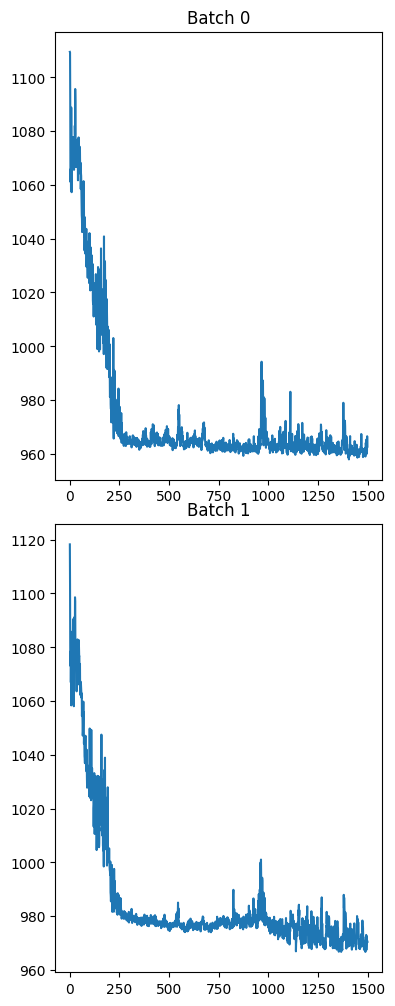

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 1.3110e-01,  0.0000e+00,  2.4640e-09,  ...,  9.0000e-01,
           1.2290e-04,  5.9737e-26],
         [ 6.3275e-02,  0.0000e+00, -3.5913e-08,  ...,  1.3619e-01,
          -1.7913e-03, -8.7066e-25],
         [ 1.2626e-01,  0.0000e+00,  3.7254e-07,  ..., -1.7681e-02,
           1.8601e-02,  9.0318e-24],
         ...,
         [ 5.5515e-02,  0.0000e+00,  7.4509e-14,  ..., -1.6111e-09,
           7.6111e-02, -7.3256e-16],
         [ 6.4358e-02,  0.0000e+00, -1.1901e-14,  ...,  2.5734e-10,
          -1.1816e-02,  1.1701e-16],
         [ 3.6079e-02,  0.0000e+00,  1.8906e-15,  ..., -4.0879e-11,
           1.8760e-03, -1.8588e-17]],

        [[ 1.2385e-01,  0.0000e+00,  7.5775e-09,  ...,  9.1389e-01,
           8.4483e-05,  1.5085e-29],
         [ 4.7252e-02,  0.0000e+00, -3.3588e-08,  ...,  6.1578e-02,
          -3.7448e-04, -6.6867e-29],
         [ 5.3389e-02,  0.0000e+00,  1.0545e-07,  ..., -5.2349e-03,
           1.1758e-03,  2.0992e-28],
         ...,
         [ 6.1278e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



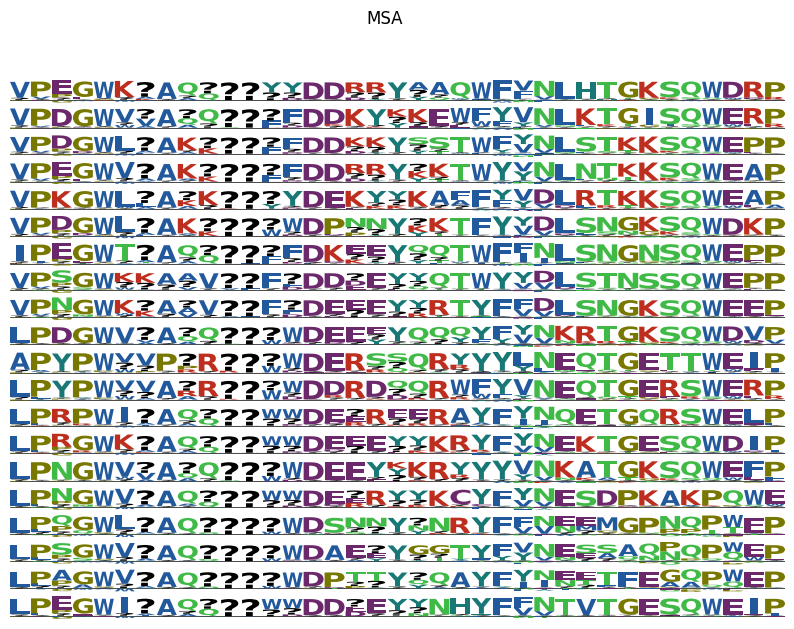

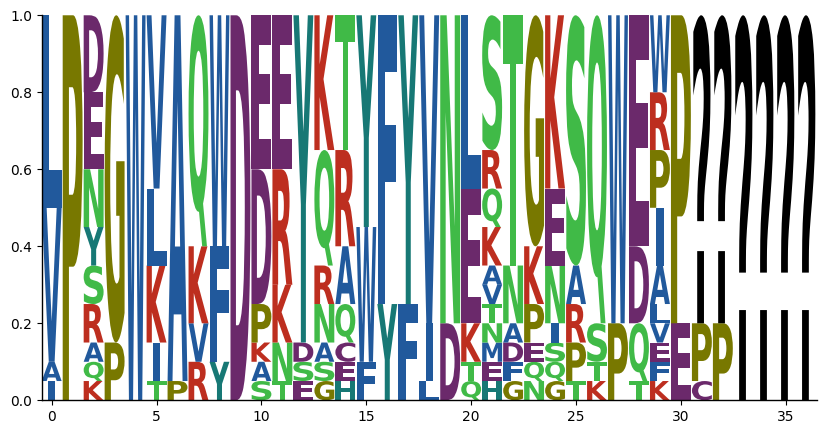

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



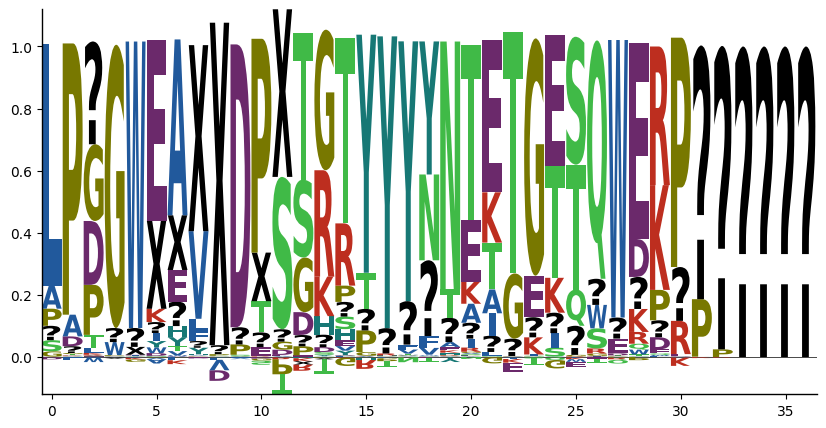

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



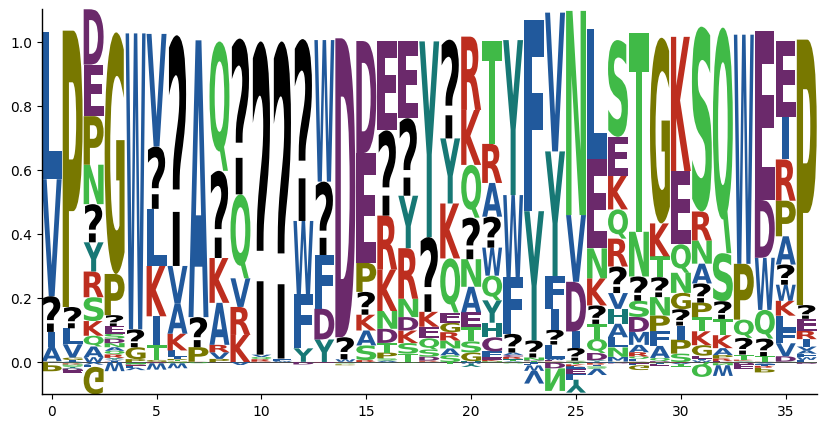

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



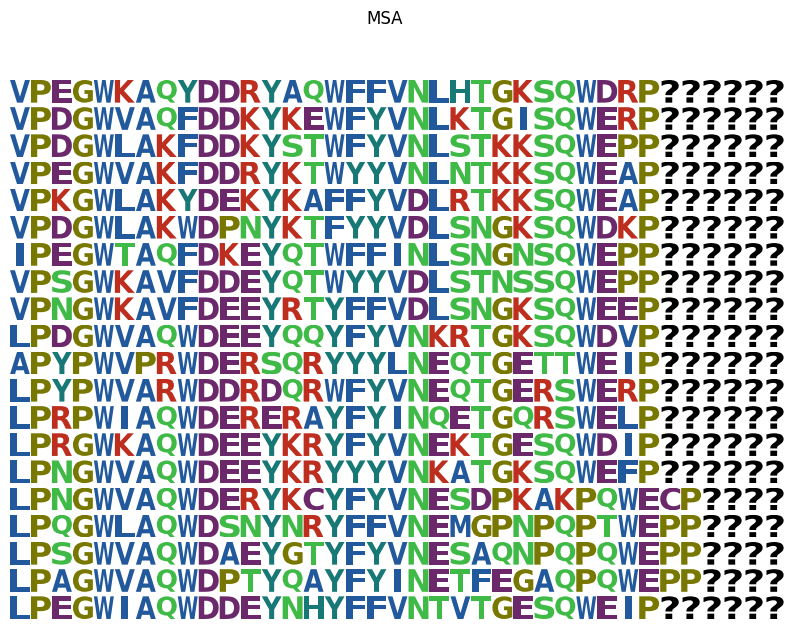

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

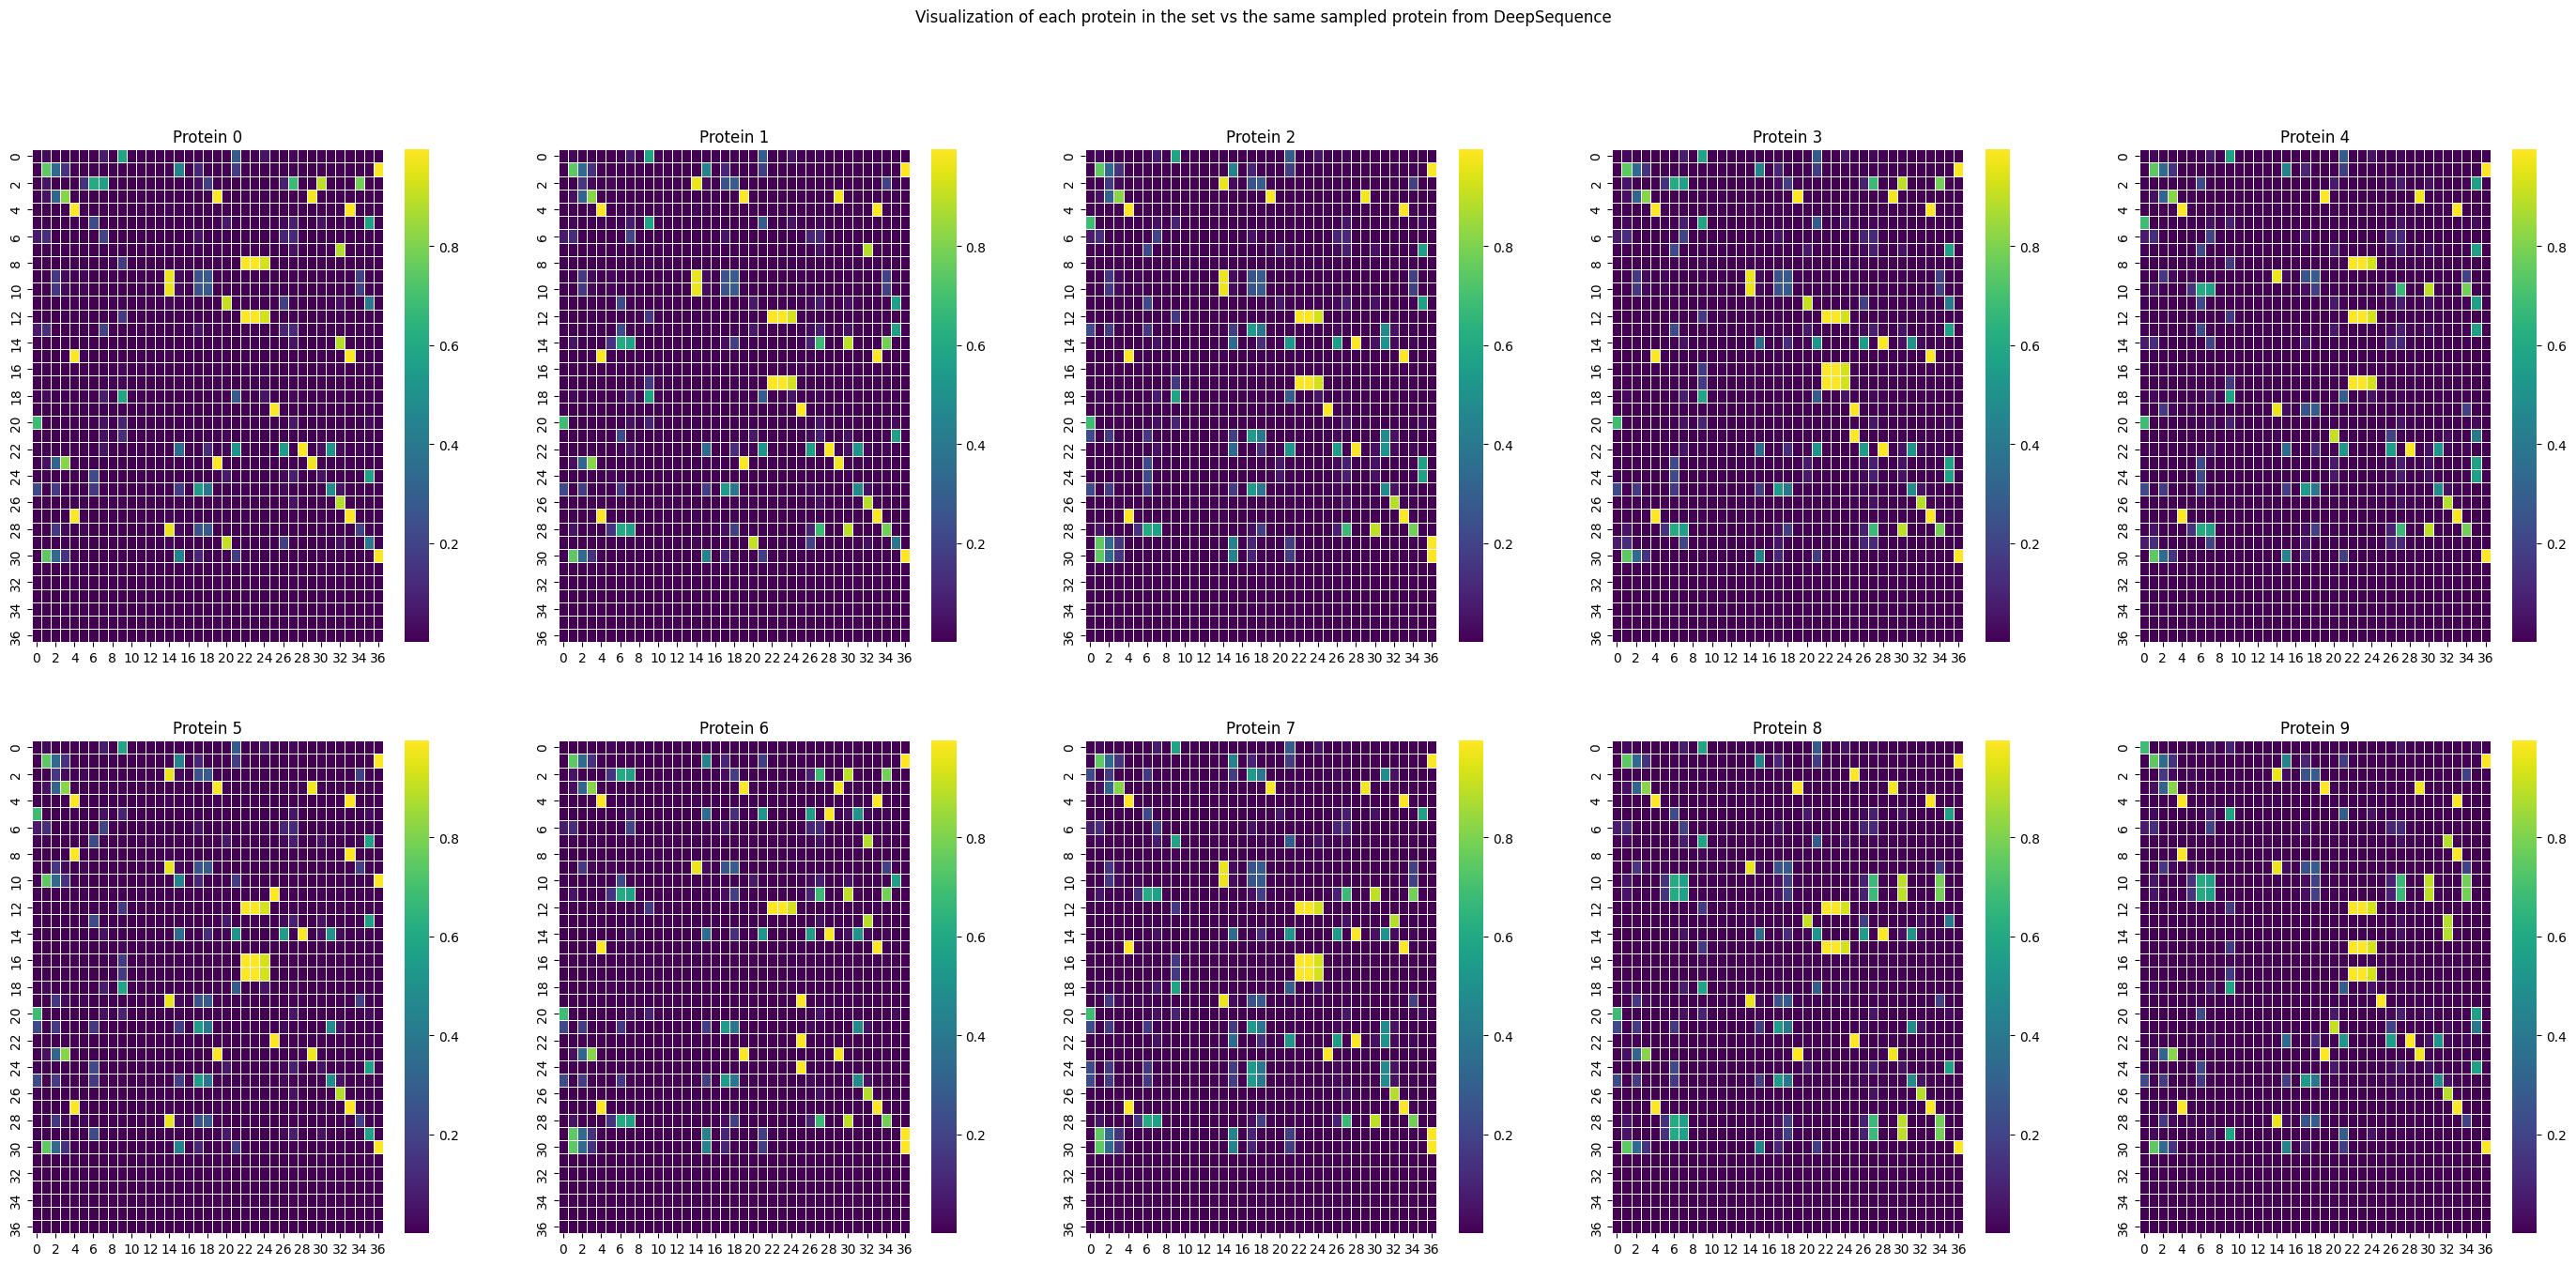

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()